In [ ]:
# Import required libraries for data processing, numerical operations, plotting, and machine learning
import os  # For file and directory operations
import numpy as np  # For numerical computations and array handling
import pandas as pd  # For data manipulation and CSV handling
import math  # For mathematical constants and functions
import matplotlib.pyplot as plt  # For creating plots
%matplotlib inline
# Ensures plots are displayed inline in Jupyter/Colab notebooks

# Import specific modules from scikit-learn for preprocessing and cross-validation
from sklearn import preprocessing  # For data normalization (though not directly used here)
from sklearn.model_selection import KFold  # For splitting data into training/validation sets for cross-validation
from tqdm import tqdm  # For displaying progress bars (not used in this code, but imported)
from scipy import stats as st  # For statistical distributions and fitting
from scipy.sparse import issparse  # For checking if data is in sparse format (not used here)
from scipy.interpolate import UnivariateSpline  # For fitting cubic smoothing splines
import torch  # For tensor operations, used in cross-validation

# Mount Google Drive to access input files and save outputs
from google.colab import drive
drive.mount('/content/drive/')  # Mounts Google Drive to the '/content/drive/' directory in Colab

# Install the pygam library (though not used in this code, likely a leftover import)
!pip install pygam

# Define the base folder path for saving outputs (figures, CSVs, and MSE data)
folder_path = "/content/drive/MyDrive/BQSP_test_1a/Saved_Outputs/"
# Create directories if they don't exist; exist_ok=True prevents errors if directories already exist
os.makedirs(folder_path, exist_ok=True)  # Base output directory
os.makedirs(f"{folder_path}/Figures", exist_ok=True)  # Directory for saving plots
os.makedirs(f"{folder_path}/CSV_data", exist_ok=True)  # Directory for saving combined CSV data
os.makedirs(f"{folder_path}/MSE_data", exist_ok=True)  # Directory for saving cross-validation MSE results

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Define the main function to process a GRB dataset and perform spline fitting, reconstruction, and cross-validation
def run_model(grb_name):
    """
    Reads a trimmed CSV for a given GRB, takes log(time) & log(flux),
    fits a cubic smoothing spline via scipy.interpolate.UnivariateSpline,
    reconstructs the light curve (adding noise using residual σ),
    plots original vs. reconstructed (with updated vertical error bars),
    saves figure + CSV, and finally runs 5‐fold CV to record train/validation MSE.
    Parameters:
        grb_name (str): Name of the GRB (e.g., 'GRB200306C') used to locate the input CSV file
    """
    # Print a header to indicate which GRB is being processed
    print(f"\n----- TRAINING FOR {grb_name} -----\n")

    # (1) Load trimmed data -----------------------------------------------------
    # Construct the file path to the trimmed CSV file for the specified GRB
    data_path = (
        f"/content/drive/MyDrive/GRB Project 1/GRB Files_shared/GRBs_trimmed/"
        f"{grb_name}_trimmed.csv"
    )
    # Read the CSV file into a pandas DataFrame
    trimmed_data = pd.read_csv(data_path)
    # Check the number of columns to assign appropriate column names
    if len(trimmed_data.columns) == 6:
        # If 6 columns, assume standard format: time, positive/negative time errors, flux, positive/negative flux errors
        trimmed_data.columns = ["t", "pos_t_err", "neg_t_err", "flux", "pos_flux_err", "neg_flux_err"]
    else:
        # If more columns (e.g., 7), assume an extra unused column (likely an index or metadata)
        trimmed_data.columns = ["0", "t", "pos_t_err", "neg_t_err", "flux", "pos_flux_err", "neg_flux_err"]

    # Sort the DataFrame by the time column to ensure data points are in increasing time order
    time_col = "t" if "t" in trimmed_data.columns else "time_sec"  # Handle different time column names
    trimmed_data = trimmed_data.sort_values(by=time_col)  # Sort by time column

    # Extract time and flux data as NumPy arrays for numerical processing
    if "t" in trimmed_data.columns:
        ts = trimmed_data["t"].to_numpy()  # Extract time values
        trim_t_val = trimmed_data["t"]  # Keep time column for later use
    else:
        ts = trimmed_data["time_sec"].to_numpy()  # Extract time values (alternative column name)
        trim_t_val = trimmed_data["time_sec"]  # Keep time column
    fluxes = trimmed_data["flux"].to_numpy()  # Extract flux values

    # Extract positive and negative time errors (in linear scale)
    positive_ts_err = (
        trimmed_data["pos_t_err"].to_numpy()  # Positive time error
        if "pos_t_err" in trimmed_data.columns
        else trimmed_data["timePos_sec"].to_numpy()  # Alternative column name
    )
    negative_ts_err = (
        trimmed_data["neg_t_err"].to_numpy()  # Negative time error
        if "neg_t_err" in trimmed_data.columns
        else trimmed_data["timeNeg_sec"].to_numpy()  # Alternative column name
    )

    # Extract positive and negative flux errors (in linear scale)
    positive_fluxes_err = (
        trimmed_data["pos_flux_err"].to_numpy()  # Positive flux error
        if "pos_flux_err" in trimmed_data.columns
        else trimmed_data["flux_errPos"].to_numpy()  # Alternative column name
    )
    negative_fluxes_err = (
        trimmed_data["neg_flux_err"].to_numpy()  # Negative flux error
        if "neg_flux_err" in trimmed_data.columns
        else trimmed_data["flux_errNeg"].to_numpy()  # Alternative column name
    )

    # (2) Compute log‐space values for observed points
    # Convert time and flux to logarithmic scale for spline fitting
    log_ts = np.log10(ts)  # Log10 of time values
    log_fluxes = np.log10(fluxes)  # Log10 of flux values

    # Compute upper and lower log-flux errors based on linear-scale errors
    pos_fluxes = fluxes + positive_fluxes_err  # Upper flux bound (flux + positive error)
    neg_fluxes = fluxes + negative_fluxes_err  # Lower flux bound (flux + negative error)
    pos_log_fluxes = np.log10(pos_fluxes)  # Log10 of upper flux bound
    neg_log_fluxes = np.log10(neg_fluxes)  # Log10 of lower flux bound
    lower_err_log = log_fluxes - neg_log_fluxes  # Lower error in log-flux (difference from mean)
    upper_err_log = pos_log_fluxes - log_fluxes  # Upper error in log-flux (difference from mean)

    # Compute log-scale time and flux errors for synthetic sampling later
    ts_err = (positive_ts_err - negative_ts_err) / 2.0  # Average time error in linear scale
    flux_err = (positive_fluxes_err - negative_fluxes_err) / 2.0  # Average flux error in linear scale
    log_ts_err = ts_err / (ts * np.log(10))  # Convert time error to log scale using derivative of log10
    log_flux_err = flux_err / (fluxes * np.log(10))  # Convert flux error to log scale

    # (3) Quick plot of observed (trimmed) data alone with updated error bars
    plt.figure(figsize=(6, 4))  # Create a new figure with size 6x4 inches
    plt.errorbar(
        log_ts,  # X-axis: log(time)
        log_fluxes,  # Y-axis: log(flux)
        yerr=[np.abs(lower_err_log), np.abs(upper_err_log)],  # Error bars for log(flux)
        fmt='o',  # Plot points as circles
        capsize=5,  # Length of error bar caps
        label="Trimmed Data"  # Legend label
    )
    plt.xlabel("log(Time)")  # X-axis label
    plt.ylabel("log(Flux)")  # Y-axis label
    plt.title(f"Original GRB: {grb_name}")  # Plot title with GRB name
    plt.legend()  # Display legend
    plt.show()  # Display the plot
    print("\n----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----\n")  # Confirmation message

    # (4) Normalize log‐data for spline fitting ---------------------------------
    # Compute mean and standard deviation for normalization
    log_ts_mean = np.mean(log_ts, keepdims=True)  # Mean of log(time), keepdims for broadcasting
    log_ts_std = np.std(log_ts, keepdims=True)  # Standard deviation of log(time)
    log_flux_mean = np.mean(log_fluxes, keepdims=True)  # Mean of log(flux)
    log_flux_std = np.std(log_fluxes, keepdims=True)  # Standard deviation of log(flux)

    # Normalize log-time and log-flux data to zero mean and unit variance
    log_ts_norm = (log_ts - log_ts_mean) / log_ts_std  # Normalized log(time)
    log_flux_norm = (log_fluxes - log_flux_mean) / log_flux_std  # Normalized log(flux)

    # Convert normalized data to PyTorch tensors for cross-validation
    train_x = torch.tensor(log_ts_norm.reshape(-1, 1), dtype=torch.float32)  # Reshape to (N,1) tensor
    train_y = torch.tensor(log_flux_norm, dtype=torch.float32)  # 1D tensor for flux

    # (5) Build a dense grid for reconstruction: geom. spaced in linear‐t
    density_factor = 1  # Unused variable (likely a placeholder for future use)
    # GAP-AWARE reconstruction: create a grid that accounts for gaps in log(time)
    gaps = np.diff(log_ts)  # Compute differences between consecutive log(time) points

    # Define minimum gap size and initialize reconstruction grid
    min_gap = 0.05  # Minimum gap size in log(time) to trigger additional points
    recon_log_t = [log_ts[0]]  # Start reconstruction grid with first log(time) point
    total_span = log_ts[-1] - log_ts[0]  # Total range of log(time)

    # Determine number of reconstruction points based on dataset size
    if len(ts) > 500:  # For very dense light curves
        fraction = 0.05
    elif len(ts) > 250:
        fraction = 0.1
    elif len(ts) > 100:
        fraction = 0.3
    else:  # For sparse light curves
        fraction = 0.4
    n_points = max(20, int(fraction * len(ts)))  # Minimum 20 points, scaled by dataset size

    # Loop through gaps to add points in large gaps
    for i in range(len(ts) - 1):
        gap_size = log_ts[i+1] - log_ts[i]  # Size of gap between consecutive points
        if gap_size > min_gap:
            # Allocate points proportional to gap size
            interval_points = max(2, int(n_points * gap_size / total_span))  # At least 2 points
            interval = np.linspace(log_ts[i], log_ts[i+1], interval_points, endpoint=True)  # Linearly spaced points
            recon_log_t.extend(interval[1:])  # Add points, excluding the start to avoid duplication

    recon_log_t = np.array(recon_log_t)  # Convert to NumPy array
    recon_t = 10**np.array(recon_log_t)  # Convert back to linear time
    recon_t = np.unique(recon_t)  # Remove duplicates to ensure unique time points
    log_recon_t = np.log10(recon_t).reshape(-1, 1)  # Convert back to log(time) for spline evaluation

    # -------------------------------------------------------------------------------
    # Sub‐function: train_spline() using UnivariateSpline with the new plot format
    # -------------------------------------------------------------------------------
    def train_spline():
        print("\n----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----\n")

        # 1) Fit UnivariateSpline on normalized log‐data
        N = len(log_ts_norm)  # Number of data points
        spline = UnivariateSpline(
            x=log_ts_norm.flatten(),  # Normalized log(time) as input
            y=log_flux_norm.flatten(),  # Normalized log(flux) as output
            k=4,  # Quartic spline (degree 4)
            s=N  # Smoothing factor equal to number of points for balanced fit
        )

        # 2) Compute residuals in normalized space and estimate standard deviation
        pred_norm_train = spline(log_ts_norm.flatten())  # Spline predictions on training data
        resid_norm = log_flux_norm.flatten() - pred_norm_train  # Residuals (errors)
        sigma_resid = np.std(resid_norm)  # Standard deviation of residuals

        # 3) Expand the log‐grid by inserting extra points where gaps ≥ 0.1
        expanded = log_recon_t.copy()  # Start with reconstruction grid
        for i in range(len(log_ts) - 1):
            lowb = log_ts[i]  # Lower bound of gap
            upb = log_ts[i + 1]  # Upper bound of gap
            if np.abs(upb - lowb) >= 0.1:  # If gap is large enough
                n_pts = min(5, int(5 * np.abs(upb - lowb) / 0.1))  # Number of points proportional to gap size
                segment = np.linspace(lowb, upb, num=n_pts).reshape(-1, 1)  # Create points in gap
                expanded = np.vstack((expanded, segment))  # Add to expanded grid
        expanded = np.sort(expanded, axis=0)  # Sort to ensure increasing order

        # 4) Normalize the expanded grid for spline evaluation
        expanded_norm = ((expanded - log_ts_mean) / log_ts_std).flatten()  # Normalize log(time) grid

        # 5) Evaluate the spline on the normalized expanded grid
        mean_norm_recon = spline(expanded_norm)  # Predicted normalized log(flux) values

        # 6) Build a 95% confidence interval in normalized space
        lower_norm_recon = mean_norm_recon - 1.96 * sigma_resid  # Lower bound (mean - 1.96 * std)
        upper_norm_recon = mean_norm_recon + 1.96 * sigma_resid  # Upper bound (mean + 1.96 * std)

        # 7) Denormalize predictions back to log‐flux space
        mean_denorm_log = (mean_norm_recon * log_flux_std) + log_flux_mean  # Denormalized mean
        lower_denorm_log = (lower_norm_recon * log_flux_std) + log_flux_mean  # Denormalized lower bound
        upper_denorm_log = (upper_norm_recon * log_flux_std) + log_flux_mean  # Denormalized upper bound

        # 8) Generate one random‐noise realization of log‐flux with best fit noise
        # Compute flux errors in linear scale
        fluxes_error = (positive_fluxes_err - negative_fluxes_err) / 2  # Average flux error
        logfluxerrs = fluxes_error / (fluxes * np.log(10))  # Convert to log-scale flux errors

        # Fit normal and Laplace distributions to log-flux errors
        distributions = [st.norm, st.laplace]  # List of distributions to try
        fits = {}
        for dist in distributions:
            params = dist.fit(logfluxerrs)  # Fit distribution to log-flux errors
            loglikelihood = np.sum(dist.logpdf(logfluxerrs, *params))  # Compute log-likelihood
            fits[dist.name] = (params, loglikelihood)  # Store parameters and log-likelihood

        # Select the best-fitting distribution based on log-likelihood
        best_dist_name = max(fits, key=lambda d: fits[d][1])  # Distribution with highest log-likelihood
        best_params = fits[best_dist_name][0]  # Parameters of best distribution
        best_dist = getattr(st, best_dist_name)  # Get the distribution object

        # Generate random noise for each reconstructed point
        rand_noise = []
        for j in range(len(mean_norm_recon)):
            # Sample noise from the best distribution, scaled by 3.5 and centered
            noise = 3.5 * (best_dist.rvs(*best_params, size=1)[0] - best_params[0])
            rand_noise.append(noise)

        rand_noise = np.array(rand_noise)  # Convert noise list to array
        recon_norm_flux = mean_norm_recon + rand_noise  # Add noise to normalized predictions
        recon_denorm_log = (recon_norm_flux * log_flux_std) + log_flux_mean  # Denormalize noisy predictions

        # 9) Fit distributions of original log‐errors (flux & time) to sample synthetic errors
        loc_f, scale_f = st.norm.fit(log_flux_err)  # Fit normal distribution to log-flux errors
        dist_f = st.norm(loc=loc_f, scale=scale_f)  # Create normal distribution object
        sampled_flux_errs = dist_f.rvs(size=len(expanded))  # Sample flux errors for reconstructed points

        loc_t, scale_t = st.norm.fit(log_ts_err)  # Fit normal distribution to log-time errors
        dist_t = st.norm(loc=loc_t, scale=scale_t)  # Create normal distribution object
        sampled_time_errs = dist_t.rvs(size=len(expanded))  # Sample time errors for reconstructed points

        # 10) Plot original + reconstructed data with updated vertical error bars
        # Denormalize training points for plotting
        train_x_denorm = (train_x.numpy().flatten() * log_ts_std) + log_ts_mean  # Denormalized log(time)
        train_y_denorm = (train_y.numpy().flatten() * log_flux_std) + log_flux_mean  # Denormalized log(flux)

        # Prepare arrays for reconstructed data
        test_x_denorm = expanded.flatten()  # Denormalized log(time) grid for reconstruction
        log_reconstructed_flux = recon_denorm_log.flatten()  # Noisy reconstructed log(flux)
        mean_prediction_denorm = mean_denorm_log.flatten()  # Mean predicted log(flux)
        lower_denorm = lower_denorm_log.flatten()  # Lower CI bound
        upper_denorm = upper_denorm_log.flatten()  # Upper CI bound
        recon_errorbar = sampled_flux_errs  # Synthetic log-flux errors for error bars

        plt.figure(figsize=(8, 6))  # Create a new figure with size 8x6 inches

        # a) Plot original data with updated y-errors
        plt.errorbar(
            train_x_denorm,  # Log(time)
            train_y_denorm,  # Log(flux)
            zorder=4,  # Plot on top (higher z-order)
            yerr=[lower_err_log, upper_err_log],  # Error bars for log(flux)
            linestyle=""  # No connecting lines
        )

        # b) Plot reconstructed points with synthetic error bars
        plt.errorbar(
            test_x_denorm,  # Reconstructed log(time)
            log_reconstructed_flux,  # Noisy reconstructed log(flux)
            linestyle='none',  # No connecting lines
            yerr=np.abs(recon_errorbar),  # Synthetic error bars
            marker='o',  # Circle markers
            capsize=5,  # Error bar cap length
            color='yellow',  # Yellow color for reconstructed points
            zorder=3,  # Slightly lower z-order
            label="Reconstructed Points"  # Legend label
        )

        # c) Scatter original observed points on top
        plt.scatter(
            train_x_denorm,  # Log(time)
            train_y_denorm,  # Log(flux)
            zorder=5,  # Highest z-order to ensure visibility
            label="Observed Points"  # Legend label
        )

        # d) Plot the mean prediction curve
        plt.plot(
            test_x_denorm,  # Log(time)
            mean_prediction_denorm,  # Mean predicted log(flux)
            label="Mean Prediction",  # Legend label
            zorder=2  # Lower z-order
        )

        # e) Add 95% confidence interval shading
        plt.fill_between(
            test_x_denorm.flatten(),  # Log(time)
            lower_denorm,  # Lower CI bound
            upper_denorm,  # Upper CI bound
            alpha=0.5,  # Transparency
            color='orange',  # Orange color for CI
            label="95% Confidence Region",  # Legend label
            zorder=1  # Lowest z-order
        )

        plt.legend(loc='lower left')  # Place legend in lower-left corner
        plt.xlabel('log$_{10}$(Time) (s)', fontsize=15)  # X-axis label with LaTeX formatting
        plt.ylabel('log$_{10}$(Flux) ($erg\\,cm^{-2}\\,s^{-1}$)', fontsize=15)  # Y-axis label with LaTeX
        plt.title(f'Quartic Smoothing Spline on {grb_name}', fontsize=18)  # Plot title
        plt.savefig(f"{folder_path}/Figures/{grb_name}.png", dpi=300)  # Save plot as PNG
        print("\n----- RECONSTRUCTED GRB (Figure saved) -----\n")  # Confirmation message
        plt.show()  # Display the plot

        # 11) Build combined DataFrame with original and reconstructed data
        combined_df = trimmed_data.copy(deep=True)  # Deep copy of original DataFrame
        new_rows = []  # List to store reconstructed data rows
        for i in range(len(expanded)):
            logt_pt = expanded[i][0]  # Log(time) for reconstructed point
            t_lin = 10 ** logt_pt  # Convert to linear time

            # Convert log-time errors to linear scale for positive/negative errors
            pos_t_lin = 10 ** (logt_pt + sampled_time_errs[i])  # Upper time bound
            neg_t_lin = 10 ** (logt_pt - sampled_time_errs[i])  # Lower time bound

            flux_lin = 10 ** recon_denorm_log[i]  # Convert reconstructed log(flux) to linear scale
            pos_f_lin = 10 ** (recon_denorm_log[i] + sampled_flux_errs[i])  # Upper flux bound
            neg_f_lin = 10 ** (recon_denorm_log[i] - sampled_flux_errs[i])  # Lower flux bound

            # Create a dictionary for the new row
            new_rows.append({
                "t": t_lin,  # Linear time
                "pos_t_err": abs(pos_t_lin - t_lin),  # Positive time error
                "neg_t_err": abs(t_lin - neg_t_lin),  # Negative time error
                "flux": flux_lin,  # Linear flux
                "pos_flux_err": abs(pos_f_lin - flux_lin),  # Positive flux error
                "neg_flux_err": abs(flux_lin - neg_f_lin)  # Negative flux error
            })

        new_df = pd.DataFrame(new_rows)  # Create DataFrame from reconstructed rows
        combined_df = pd.concat([combined_df, new_df], ignore_index=True)  # Append reconstructed rows
        combined_df.to_csv(f"{folder_path}/CSV_data/{grb_name}.csv", index=False)  # Save combined DataFrame
        print(f"Saved combined CSV to: {folder_path}/CSV_data/{grb_name}.csv")  # Confirmation message

    # Call the spline-training sub-function
    train_spline()

    # # -------------------------------------------------------------------------------
    # # (6) 5‐Fold Cross‐Validation (on normalized log‐data) to record MSE
    # # -------------------------------------------------------------------------------
    print("\n----- 5‐FOLD VALIDATION BEGIN -----\n")

    # Convert PyTorch tensors back to NumPy arrays for cross-validation
    all_x = train_x.numpy().astype(float)  # Normalized log(time), shape (N, 1)
    all_y = train_y.numpy().astype(float)  # Normalized log(flux), shape (N,)

    # Initialize KFold with 5 splits, shuffling data, and a fixed random seed for reproducibility
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_records = []  # List to store MSE for each fold

    # Iterate through folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(all_x, all_y), start=1):
        print(f"--- Fold {fold} / 5 ---")  # Print fold number

        # Split data into training and validation sets
        x_tr = all_x[train_idx].reshape(-1, 1)  # Training log(time)
        y_tr = all_y[train_idx]  # Training log(flux)
        x_te = all_x[test_idx].reshape(-1, 1)  # Validation log(time)
        y_te = all_y[test_idx]  # Validation log(flux)

        # Fit a new spline on the training set
        spline_cv = UnivariateSpline(
            x=x_tr.flatten(),  # Normalized training log(time)
            y=y_tr.flatten(),  # Normalized training log(flux)
            k=4,  # Quartic spline
            s=len(x_tr)  # Smoothing factor equal to number of training points
        )

        # Compute predictions for training and validation sets
        pred_tr = spline_cv(x_tr.flatten())  # Training predictions (normalized)
        pred_tr_denorm = (pred_tr * log_flux_std) + log_flux_mean  # Denormalized training predictions
        truth_tr_denorm = (y_tr * log_flux_std) + log_flux_mean  # Denormalized training true values
        mse_tr = np.mean((pred_tr_denorm - truth_tr_denorm) ** 2)  # Training MSE in log-flux space

        pred_te = spline_cv(x_te.flatten())  # Validation predictions (normalized)
        pred_te_denorm = (pred_te * log_flux_std) + log_flux_mean  # Denormalized validation predictions
        truth_te_denorm = (y_te * log_flux_std) + log_flux_mean  # Denormalized validation true values
        mse_te = np.mean((pred_te_denorm - truth_te_denorm) ** 2)  # Validation MSE in log-flux space

        # Print MSE for the current fold
        print(
            f"Fold {fold} → Train MSE (log‐flux): {mse_tr:.4e}  |  Val MSE (log‐flux): {mse_te:.4e}"
        )
        mse_records.append((mse_tr, mse_te))  # Store MSE values

    # Compute mean MSE across all folds
    mse_arr = np.array(mse_records)  # Shape (5, 2) for train and validation MSE
    mean_tr_mse = np.mean(mse_arr[:, 0])  # Mean training MSE
    mean_te_mse = np.mean(mse_arr[:, 1])  # Mean validation MSE

    # Create a DataFrame to store MSE results
    mse_df = pd.DataFrame({
        "GRB_Name": [grb_name],  # GRB name
        "Mean_Train_MSE": [mean_tr_mse],  # Mean training MSE
        "Mean_Val_MSE": [mean_te_mse]  # Mean validation MSE
    })
    mse_csv_path = f"{folder_path}/MSE_data/MSE_data.csv"  # Path to save MSE results
    write_header = not os.path.exists(mse_csv_path)  # Write header only if file doesn't exist
    mse_df.to_csv(mse_csv_path, mode='a', header=write_header, index=False)  # Append to CSV

    # Print final cross-validation results
    print("\n----- 5‐FOLD VALIDATION COMPLETE -----\n")
    print(f"Overall Mean Train MSE: {mean_tr_mse:.4e}")
    print(f"Overall Mean Val   MSE: {mean_te_mse:.4e}")


In [ ]:
GRBs = [
    'GRB050128', 'GRB050502B', 'GRB050607', 'GRB050712', 'GRB050713A']

In [ ]:
GRBs =[ 'GRB050713B', 'GRB050726',
    'GRB050814', 'GRB050822', 'GRB050915B', 'GRB050922B', 'GRB051016A', 'GRB060105', 'GRB060108',
    'GRB060109', 'GRB060219', 'GRB060312', 'GRB060413', 'GRB060421', 'GRB060510A', 'GRB060719',
    'GRB060805A', 'GRB060807', 'GRB060813', 'GRB060923A', 'GRB061019', 'GRB061202', 'GRB070103',
    'GRB070107', 'GRB070129', 'GRB070224', 'GRB070328', 'GRB070420', 'GRB070517', 'GRB070621',
    'GRB070628', 'GRB070714A', 'GRB080129', 'GRB080205', 'GRB080212', 'GRB080218B', 'GRB080229A',
    'GRB080328', 'GRB080409', 'GRB080426', 'GRB080605', 'GRB081126', 'GRB081222', 'GRB090113',
    'GRB090404', 'GRB090407', 'GRB090518', 'GRB090727', 'GRB090728', 'GRB090807', 'GRB090813',
    'GRB090904A', 'GRB091130B', 'GRB100302A', 'GRB100305A', 'GRB100424A', 'GRB100522A', 'GRB100606A',
    'GRB100725A', 'GRB100725B', 'GRB100727A', 'GRB100802A', 'GRB101011A',
    'GRB101024A', 'GRB110102A', 'GRB110201A', 'GRB110208A', 'GRB110312A', 'GRB110315A', 'GRB110318B',
    'GRB110319A', 'GRB110402A', 'GRB110411A', 'GRB110414A', 'GRB110420A', 'GRB110530A', 'GRB110610A',
    'GRB110709A', 'GRB110801A', 'GRB111107A', 'GRB111121A', 'GRB111129A', 'GRB120102A', 'GRB120116A',
    'GRB120119A', 'GRB120211A', 'GRB120213A', 'GRB120215A', 'GRB120224A', 'GRB120308A', 'GRB120324A',
    'GRB120326A', 'GRB120701A', 'GRB120703A', 'GRB120927A', 'GRB121123A', 'GRB121209A', 'GRB121217A',
    'GRB130131A', 'GRB130211A',

In [ ]:
 GRBs =['GRB130427B', 'GRB130504A', 'GRB130527A', 'GRB130528A', 'GRB130603A',
    'GRB130609B', 'GRB130725B', 'GRB130812A', 'GRB130816A', 'GRB131002A', 'GRB131002B', 'GRB131018A',
    'GRB131024A', 'GRB131229A', 'GRB140108A', 'GRB140114A', 'GRB140215A', 'GRB140304A', 'GRB140323A',
    'GRB140331A', 'GRB140626A', 'GRB140703A', 'GRB140706A', 'GRB140709A', 'GRB140713A', 'GRB140719A',
    'GRB140730A', 'GRB140817A', 'GRB140818B', 'GRB140824A', 'GRB140916A', 'GRB140927A', 'GRB141005A',
    'GRB141017A', 'GRB141020A', 'GRB141026A', 'GRB141031A', 'GRB141109B', 'GRB141221A', 'GRB150323A',
    'GRB150323C', 'GRB150424A', 'GRB150428B', 'GRB150430A', 'GRB150530A', 'GRB150607A', 'GRB150615A',
    'GRB150626B', 'GRB150711A', 'GRB150801B', 'GRB150817A', 'GRB150911A', 'GRB151001A', 'GRB151114A',
    'GRB151118A', 'GRB151205A', 'GRB151228B', 'GRB151229A', 'GRB160104A',

In [ ]:
 GRBs =['GRB160119A', 'GRB160123A',
    'GRB160127A', 'GRB160412A', 'GRB160417A', 'GRB160504A', 'GRB160630A', 'GRB160705B', 'GRB160815A',
    'GRB160824A', 'GRB160905A', 'GRB161001A', 'GRB161004B', 'GRB161113A', 'GRB161214B', 'GRB170208B',
    'GRB170317A', 'GRB170331A', 'GRB170711A', 'GRB170803A', 'GRB170822A', 'GRB171027A', 'GRB171120A',
    'GRB180115A', 'GRB180224A', 'GRB180314A', 'GRB180316A', 'GRB180331B', 'GRB180411A', 'GRB180425A',
    'GRB180514A', 'GRB180623A', 'GRB180626A', 'GRB180630A', 'GRB180706A', 'GRB180720C', 'GRB180818B',
    'GRB180821A', 'GRB180823A', 'GRB180924A', 'GRB180925A', 'GRB180930A', 'GRB181023A', 'GRB181103A',
    'GRB190109A', 'GRB190202A', 'GRB190203A', 'GRB190204A', 'GRB190211A', 'GRB190219A', 'GRB190311A',
    'GRB190422A', 'GRB190511A', 'GRB190515B', 'GRB190519A', 'GRB190604B', 'GRB190613B', 'GRB190706B',
    'GRB190719C', 'GRB050315', 'GRB050319', 'GRB050401', 'GRB050416A', 'GRB050730', 'GRB050802',
    'GRB050803', 'GRB050824', 'GRB051016B', 'GRB051109A', 'GRB051109B', 'GRB051221A', 'GRB060115',
    'GRB060124', 'GRB060206', 'GRB060210', 'GRB060218', 'GRB060223A', 'GRB060306', 'GRB060502A',
    'GRB060526', 'GRB060604', 'GRB060605', 'GRB060607A', 'GRB060614', 'GRB060708', 'GRB060714',
    'GRB060729', 'GRB060814', 'GRB060904B', 'GRB060906', 'GRB060908', 'GRB061021', 'GRB060927',
    'GRB061121', 'GRB061201', 'GRB070110', 'GRB070208', 'GRB070306', 'GRB070521', 'GRB070529',
    'GRB070714B', 'GRB070802', 'GRB070809', 'GRB070810A', 'GRB080310', 'GRB080319B', 'GRB080319C',
    'GRB080411', 'GRB080430', 'GRB080516', 'GRB080607', 'GRB080710', 'GRB080721', 'GRB080810',
    'GRB080905B', 'GRB080928', 'GRB081007', 'GRB081008', 'GRB081028A', 'GRB081029', 'GRB081221',
    'GRB081230', 'GRB090102', 'GRB090205', 'GRB090418A', 'GRB090424', 'GRB090510', 'GRB090516',
    'GRB090529', 'GRB090530', 'GRB090618', 'GRB090927', 'GRB091018', 'GRB091020', 'GRB091029',
    'GRB091109A', 'GRB091127', 'GRB091208B', 'GRB100219A', 'GRB100418A', 'GRB100425A', 'GRB100513A',
    'GRB100621A', 'GRB100704A', 'GRB100724A', 'GRB100728A', 'GRB100814A', 'GRB100816A', 'GRB100901A',
    'GRB100906A', 'GRB101219B', 'GRB110106B', 'GRB110213A', 'GRB110422A', 'GRB110503A', 'GRB110715A',
    'GRB110731A', 'GRB110818A', 'GRB111008A', 'GRB111123A', 'GRB111228A', 'GRB120118B', 'GRB120327A',
    'GRB120404A', 'GRB120422A', 'GRB120729A', 'GRB120811C', 'GRB120907A', 'GRB120922A', 'GRB121024A',
    'GRB121027A', 'GRB121128A', 'GRB121211A', 'GRB130408A', 'GRB130418A', 'GRB130420A', 'GRB130511A',
    'GRB130514A', 'GRB130603B', 'GRB130606A', 'GRB130831A', 'GRB130925A', 'GRB131004A', 'GRB131105A',
    'GRB131117A', 'GRB140206A', 'GRB140419A', 'GRB140423A', 'GRB140430A', 'GRB140506A', 'GRB140512A',
    'GRB140518A', 'GRB140629A', 'GRB140903A', 'GRB141004A', 'GRB141121A', 'GRB150120B', 'GRB150910A',
    'GRB151031A', 'GRB151112A', 'GRB151215A', 'GRB160117B', 'GRB160121A', 'GRB160227A', 'GRB160327A',
    'GRB160804A', 'GRB161108A', 'GRB161117A', 'GRB161129A', 'GRB161219B', 'GRB170202A', 'GRB170519A',
    'GRB170531B', 'GRB170705A', 'GRB170903A', 'GRB171205A', 'GRB180205A', 'GRB180329B', 'GRB180404A',
    'GRB180620B', 'GRB180728A', 'GRB181010A', 'GRB181020A', 'GRB181110A', 'GRB190106A', 'GRB190114A',
    'GRB190627A', 'GRB050922C', 'GRB060926', 'GRB061110A', 'GRB061222A', 'GRB070508', 'GRB130505A',
    'GRB131030A', 'GRB150314A', 'GRB150403A', 'GRB150821A', 'GRB151021A', 'GRB151027A', 'GRB180720B',
    'GRB050904', 'GRB090423', 'GRB090429B', 'GRB170405A', 'GRB170714A', 'GRB180624A', 'GRB070223',
    'GRB111209A', 'GRB121229A', 'GRB050318', 'GRB050505', 'GRB071020', 'GRB071117', 'GRB050820A',
    'GRB060912A', 'GRB111117A',

In [ ]:
GRBs =['GRB130604A', 'GRB140213A', 'GRB160203A', 'GRB070721B', 'GRB071003',
    'GRB080916A', 'GRB081203A', 'GRB090812', 'GRB110808A', 'GRB120804A', 'GRB141220A', 'GRB060418',
    'GRB060707', 'GRB090426', 'GRB140509A', 'GRB151029A', 'GRB190824A', 'GRB191004A', 'GRB191017B',
    'GRB191029A', 'GRB191101A', 'GRB191122A', 'GRB191123A', 'GRB191220A', 'GRB191228A', 'GRB200131A',
    'GRB200215A', 'GRB200219A', 'GRB200227A', 'GRB200303A', 'GRB200306A', 'GRB200324A',
    'GRB200409A', 'GRB200410A', 'GRB200512A', 'GRB200519A', 'GRB200528A', 'GRB200711A', 'GRB200713A',
    'GRB200716C', 'GRB200729A', 'GRB200906A', 'GRB200925B', 'GRB201027A', 'GRB201128A', 'GRB201209A',
    'GRB201223A', 'GRB201229A', 'GRB210104A', 'GRB210104B', 'GRB210112A', 'GRB210207B', 'GRB210217A',
    'GRB210226A', 'GRB210308A', 'GRB210318B', 'GRB210712A', 'GRB210725A', 'GRB210807A', 'GRB210912A',
    'GRB210930A', 'GRB220325A', 'GRB220403B', 'GRB220408A', 'GRB220430A', 'GRB220518A', 'GRB220706A',
    'GRB220711B', 'GRB220714B', 'GRB220715B', 'GRB220813A', 'GRB220826A', 'GRB221024A', 'GRB230228A',
    'GRB230322B', 'GRB230405B', 'GRB230409B', 'GRB230420A',

In [ ]:
GRBs =['GRB230618A', 'GRB230628E', 'GRB230815A',
    'GRB230826A', 'GRB230903A', 'GRB231104A', 'GRB231205B', 'GRB240101A', 'GRB240112C', 'GRB240123A',
    'GRB240204A', 'GRB191011A', 'GRB200205B', 'GRB201020A', 'GRB201221A', 'GRB210210A', 'GRB210222B',
    'GRB210722A', 'GRB210731A', 'GRB220611A', 'GRB230116D', 'GRB230328B', 'GRB230506C', 'GRB230818A',
    'GRB190821A'
]

In [ ]:
GRBs =['GRB060418', 'GRB060707', 'GRB070721B', 'GRB071003', 'GRB080916A', 'GRB081203A', 'GRB090426', 'GRB090812', 'GRB110808A', 'GRB120804A', 'GRB130604A', 'GRB140213A', 'GRB140509A', 'GRB141220A', 'GRB151029A', 'GRB160203A', 'GRB191011A', 'GRB200205B', 'GRB201020A', 'GRB201221A', 'GRB210210A', 'GRB210731A', 'GRB220611A', 'GRB230116D', 'GRB230328B', 'GRB230506C', 'GRB230618A', 'GRB230628E', 'GRB230815A', 'GRB230818A', 'GRB230826A', 'GRB230903A', 'GRB231104A', 'GRB231205B', 'GRB240101A', 'GRB240112C', 'GRB240123A', 'GRB240204A', 'GRB190821A', 'GRB190824A', 'GRB191004A', 'GRB191017B', 'GRB191029A', 'GRB191101A', 'GRB191122A', 'GRB191123A', 'GRB191220A', 'GRB191228A', 'GRB200131A', 'GRB200215A', 'GRB200219A', 'GRB200227A', 'GRB200303A', 'GRB200306A', 'GRB200324A', 'GRB200409A', 'GRB200410A', 'GRB200512A', 'GRB200519A', 'GRB200528A', 'GRB200711A', 'GRB200713A', 'GRB200716C', 'GRB200729A', 'GRB200906A', 'GRB200925B', 'GRB201027A', 'GRB201128A', 'GRB201209A', 'GRB201223A', 'GRB201229A', 'GRB210104A', 'GRB210104B', 'GRB210112A', 'GRB210207B', 'GRB210217A', 'GRB210226A']


----- TRAINING FOR GRB060418 -----



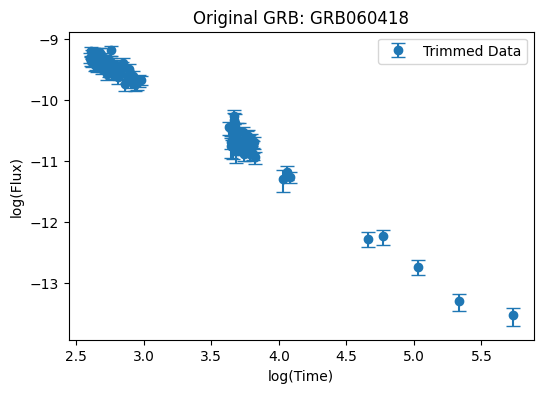


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



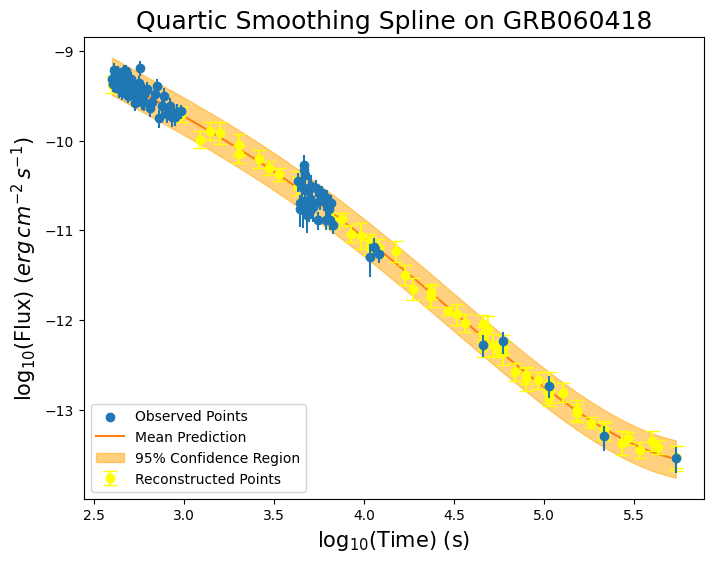

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB060418.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.2022e-02  |  Val MSE (log‐flux): 8.3273e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.2229e-02  |  Val MSE (log‐flux): 7.5113e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.1462e-02  |  Val MSE (log‐flux): 1.1342e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.6684e-03  |  Val MSE (log‐flux): 1.4114e-01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.9393e-03  |  Val MSE (log‐flux): 1.6696e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.1064e-02
Overall Mean Val   MSE: 3.7004e-02

----- TRAINING FOR GRB060707 -----



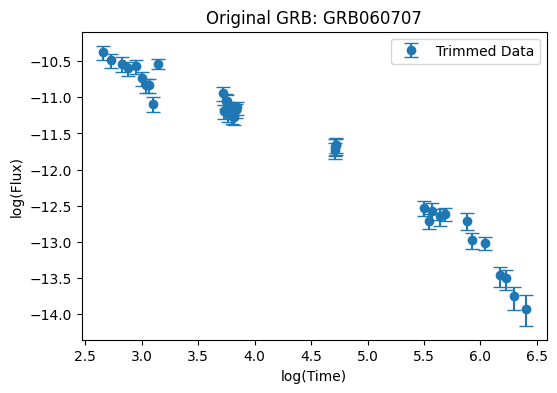


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



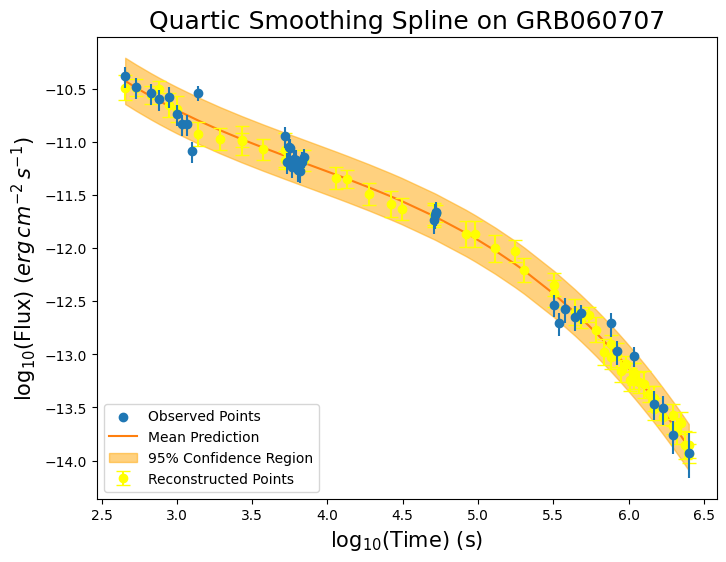

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB060707.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.1441e-02  |  Val MSE (log‐flux): 1.9188e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 8.3430e-03  |  Val MSE (log‐flux): 2.7873e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.4801e-02  |  Val MSE (log‐flux): 3.3336e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.2780e-02  |  Val MSE (log‐flux): 1.3085e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.3230e-02  |  Val MSE (log‐flux): 9.0596e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.2119e-02
Overall Mean Val   MSE: 1.4508e-02

----- TRAINING FOR GRB070721B -----



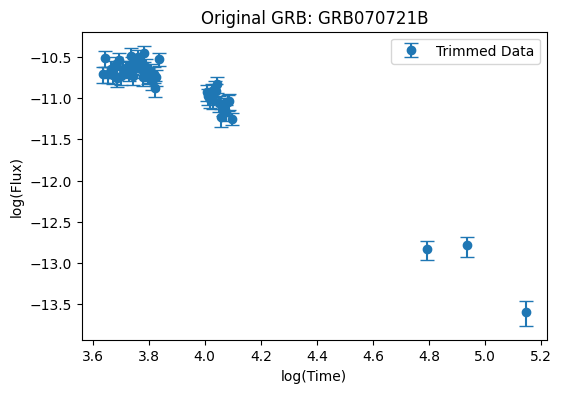


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



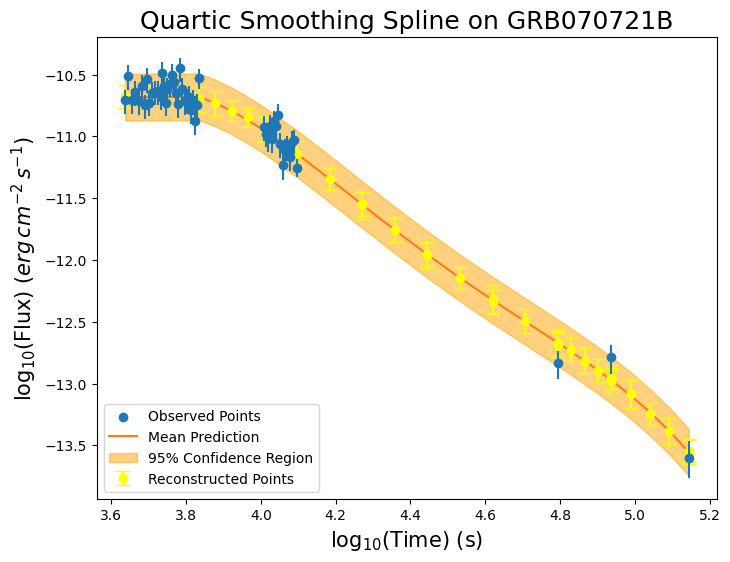

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB070721B.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.0036e-02  |  Val MSE (log‐flux): 6.5776e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 8.1735e-03  |  Val MSE (log‐flux): 3.8308e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.0628e-02  |  Val MSE (log‐flux): 4.0055e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 6.9001e-03  |  Val MSE (log‐flux): 2.0851e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.6857e-03  |  Val MSE (log‐flux): 2.5568e-01

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.6847e-03
Overall Mean Val   MSE: 6.5084e-02

----- TRAINING FOR GRB071003 -----



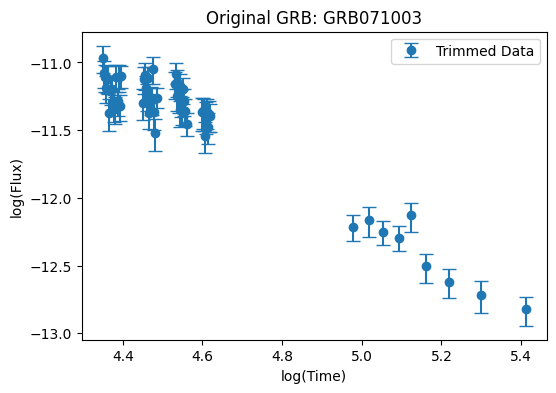


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



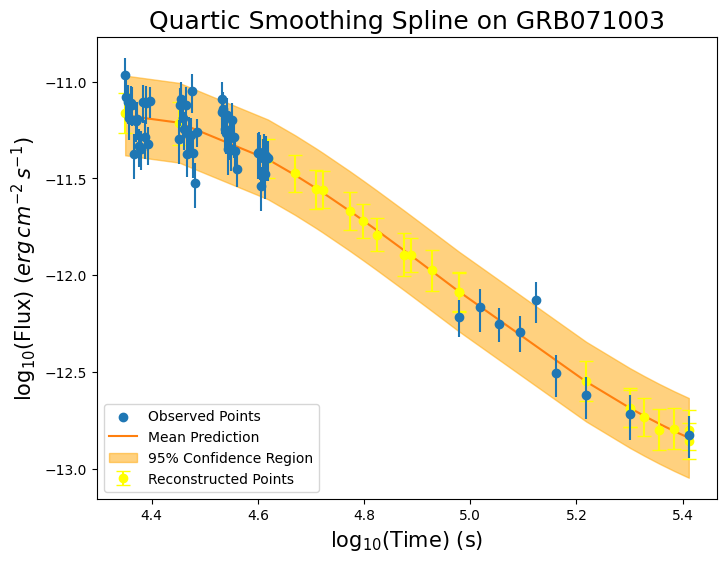

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB071003.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.1439e-02  |  Val MSE (log‐flux): 1.0829e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.1710e-02  |  Val MSE (log‐flux): 9.0784e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 7.6663e-03  |  Val MSE (log‐flux): 2.5576e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.2365e-02  |  Val MSE (log‐flux): 6.1100e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.1069e-02  |  Val MSE (log‐flux): 1.5244e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.0850e-02
Overall Mean Val   MSE: 1.3367e-02

----- TRAINING FOR GRB080916A -----



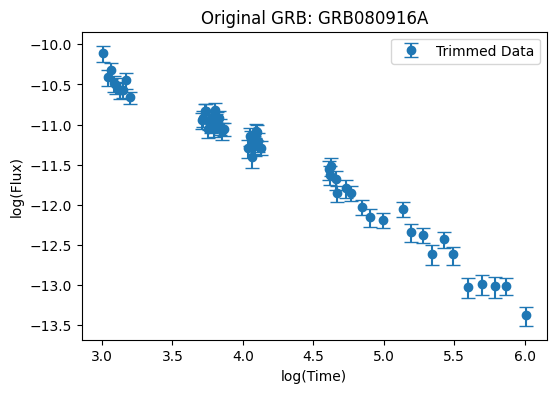


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



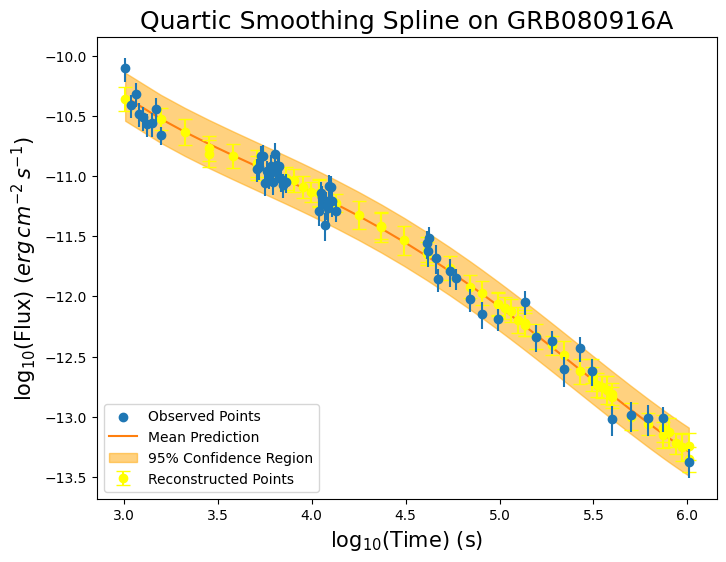

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB080916A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 9.8545e-03  |  Val MSE (log‐flux): 1.3791e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.1597e-02  |  Val MSE (log‐flux): 6.8632e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.0511e-02  |  Val MSE (log‐flux): 1.0309e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.6390e-03  |  Val MSE (log‐flux): 1.3737e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 8.9848e-03  |  Val MSE (log‐flux): 2.1747e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.0117e-02
Overall Mean Val   MSE: 1.3289e-02

----- TRAINING FOR GRB081203A -----



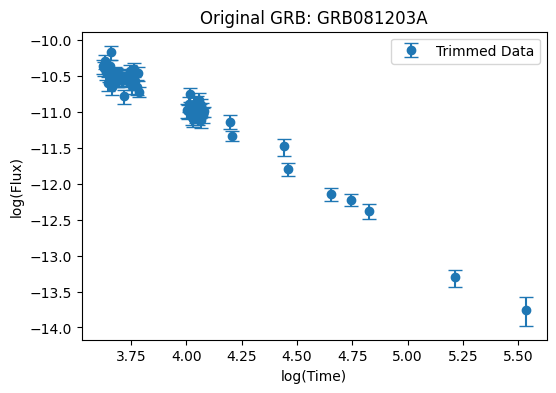


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



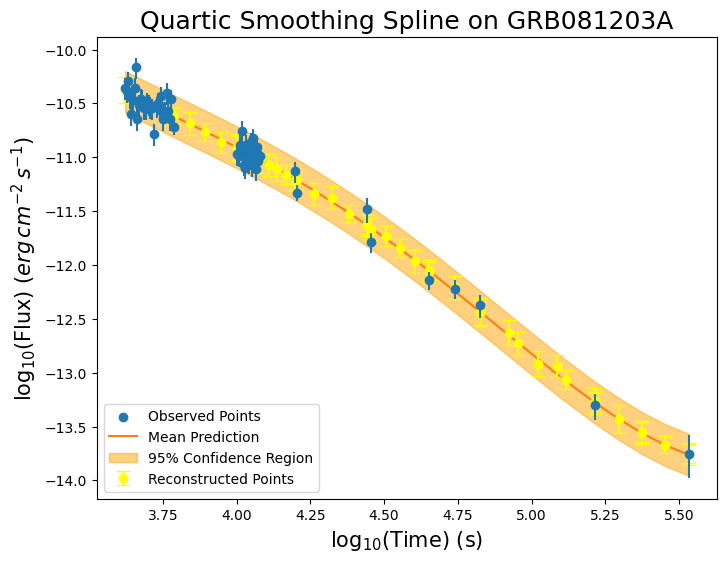

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB081203A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.0528e-02  |  Val MSE (log‐flux): 7.9227e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 9.6359e-03  |  Val MSE (log‐flux): 1.1429e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.0315e-02  |  Val MSE (log‐flux): 9.7213e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0242e-02  |  Val MSE (log‐flux): 8.4876e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.6408e-03  |  Val MSE (log‐flux): 2.0292e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 9.6723e-03
Overall Mean Val   MSE: 1.1571e-02

----- TRAINING FOR GRB090426 -----



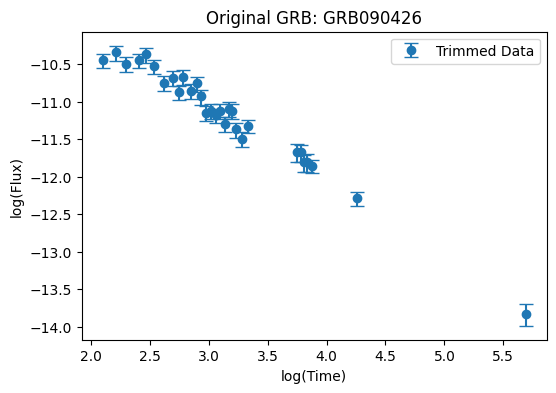


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



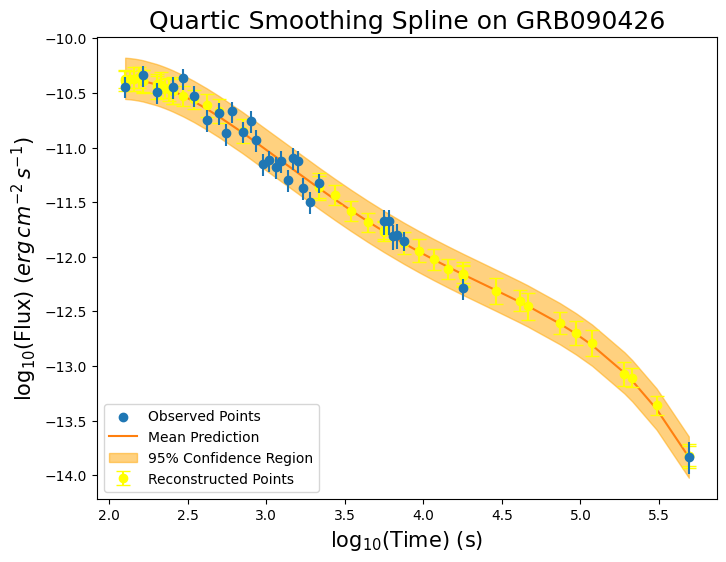

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB090426.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 8.7065e-03  |  Val MSE (log‐flux): 1.2415e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 8.3471e-03  |  Val MSE (log‐flux): 2.0565e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.0170e-03  |  Val MSE (log‐flux): 1.0480e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 7.3429e-03  |  Val MSE (log‐flux): 3.2169e+01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.8649e-03  |  Val MSE (log‐flux): 7.3106e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.6557e-03
Overall Mean Val   MSE: 6.4439e+00

----- TRAINING FOR GRB090812 -----



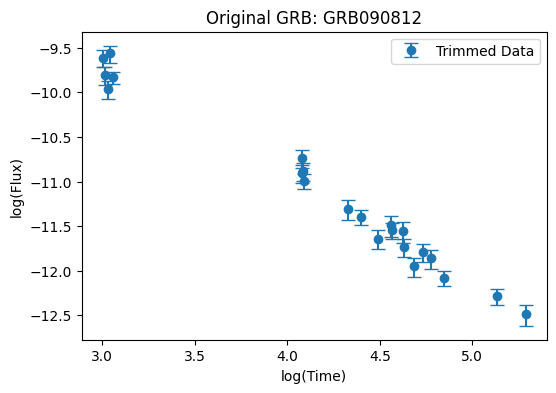


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



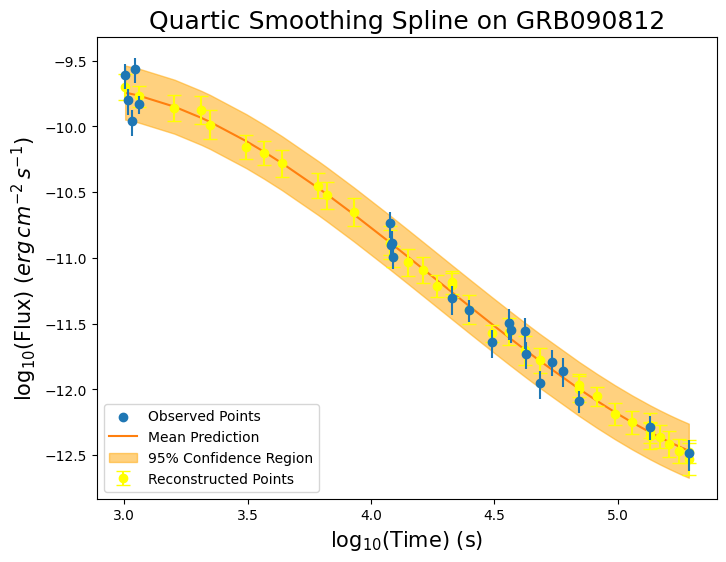

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB090812.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.1389e-02  |  Val MSE (log‐flux): 1.6080e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 7.2444e-03  |  Val MSE (log‐flux): 4.1791e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.0715e-02  |  Val MSE (log‐flux): 1.2333e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0123e-02  |  Val MSE (log‐flux): 2.1938e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.1806e-02  |  Val MSE (log‐flux): 7.6927e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.0255e-02
Overall Mean Val   MSE: 1.9967e-02

----- TRAINING FOR GRB110808A -----



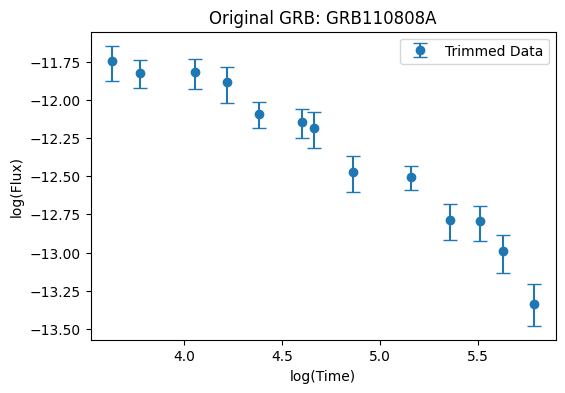


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



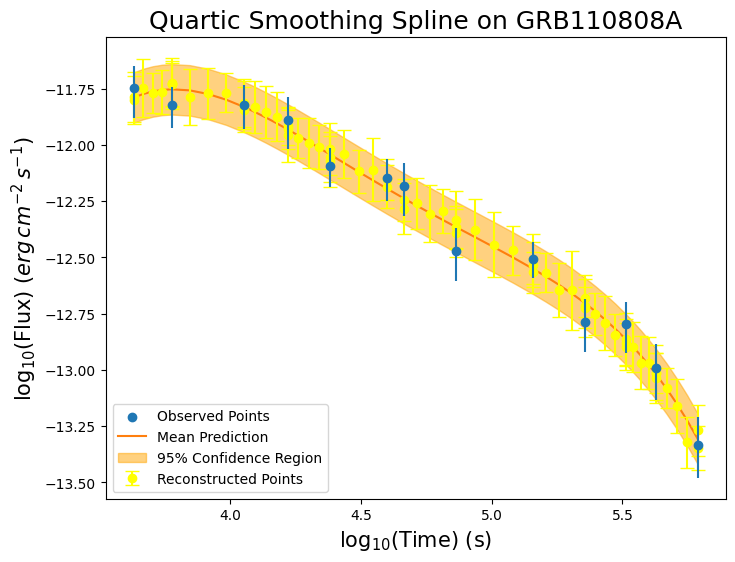

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB110808A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 2.1808e-03  |  Val MSE (log‐flux): 2.6161e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 3.5879e-03  |  Val MSE (log‐flux): 3.4307e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 2.5910e-03  |  Val MSE (log‐flux): 1.6273e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.8914e-03  |  Val MSE (log‐flux): 1.5294e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 3.1736e-03  |  Val MSE (log‐flux): 5.9122e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 2.6849e-03
Overall Mean Val   MSE: 1.3414e-02

----- TRAINING FOR GRB120804A -----



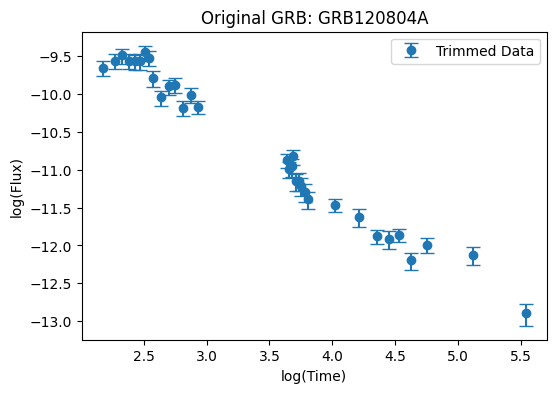


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



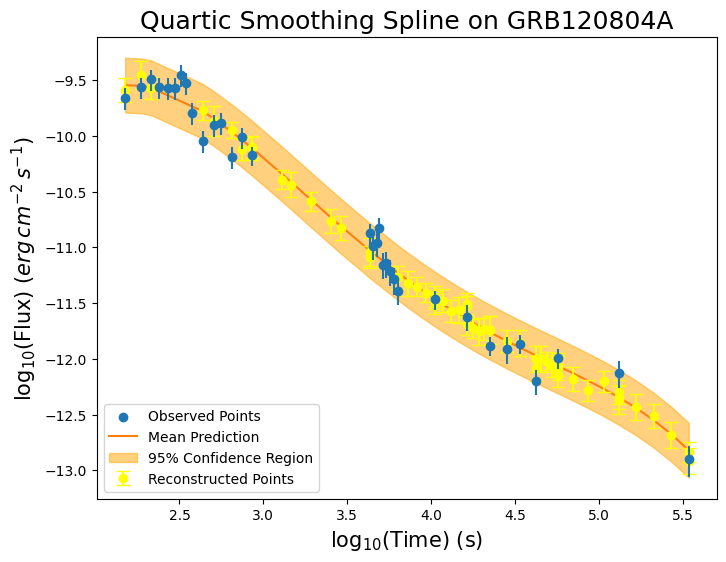

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB120804A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.2386e-02  |  Val MSE (log‐flux): 3.1117e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.6893e-02  |  Val MSE (log‐flux): 1.2299e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.6632e-02  |  Val MSE (log‐flux): 1.6950e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.3116e-02  |  Val MSE (log‐flux): 2.8596e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.4419e-02  |  Val MSE (log‐flux): 2.2342e-01

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.4689e-02
Overall Mean Val   MSE: 6.2476e-02

----- TRAINING FOR GRB130604A -----



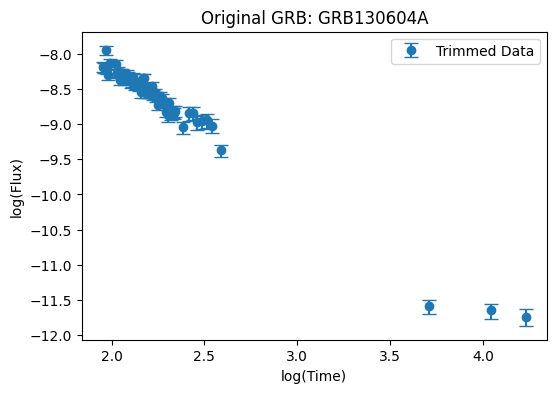


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



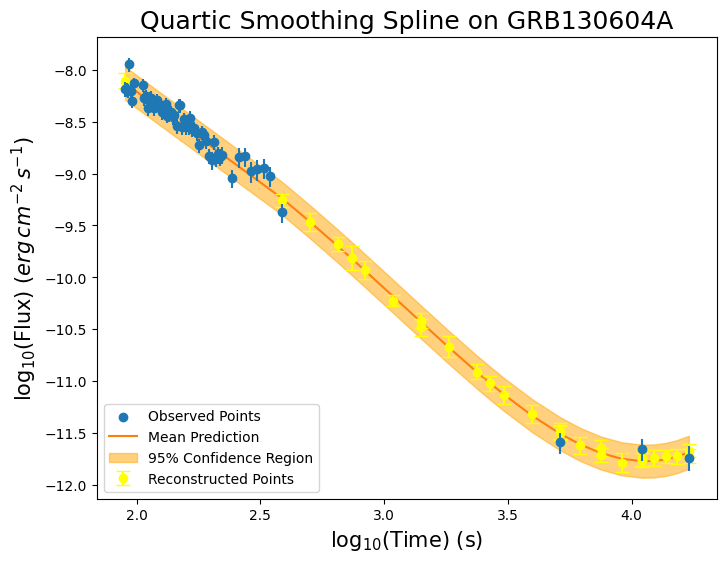

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB130604A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 6.2534e-03  |  Val MSE (log‐flux): 1.4603e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 5.6502e-03  |  Val MSE (log‐flux): 1.2346e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 7.2862e-03  |  Val MSE (log‐flux): 3.7652e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 7.1692e-03  |  Val MSE (log‐flux): 4.6432e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 5.1299e-03  |  Val MSE (log‐flux): 2.7054e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 6.2978e-03
Overall Mean Val   MSE: 1.2482e-02

----- TRAINING FOR GRB140213A -----



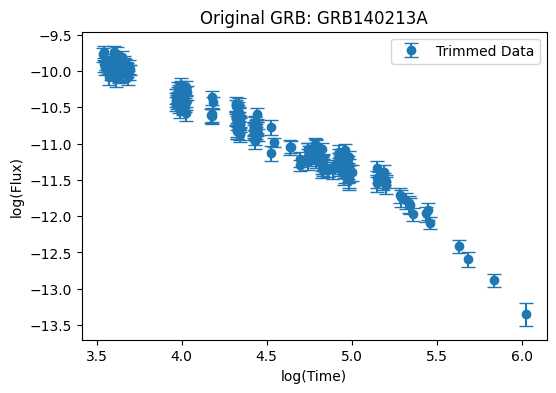


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



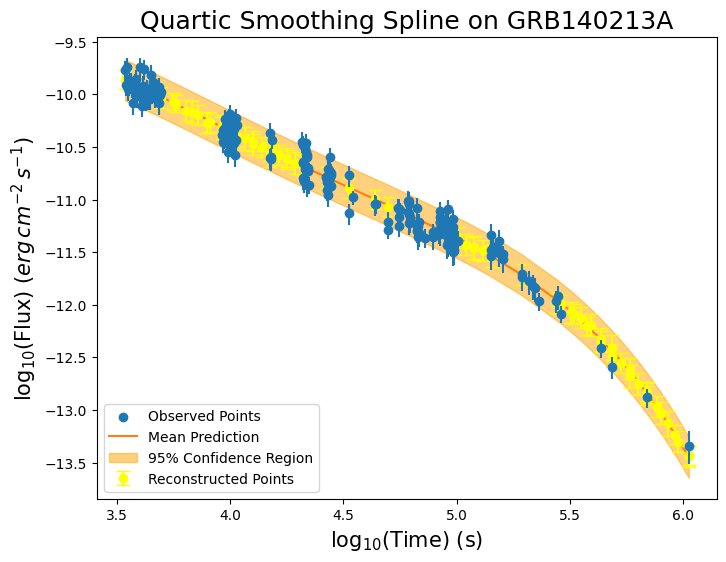

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB140213A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 9.1525e-03  |  Val MSE (log‐flux): 1.2438e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.0377e-02  |  Val MSE (log‐flux): 7.4900e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.0465e-02  |  Val MSE (log‐flux): 7.1967e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.8091e-03  |  Val MSE (log‐flux): 1.0217e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 8.8151e-03  |  Val MSE (log‐flux): 2.1861e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 9.7238e-03
Overall Mean Val   MSE: 1.1840e-02

----- TRAINING FOR GRB140509A -----



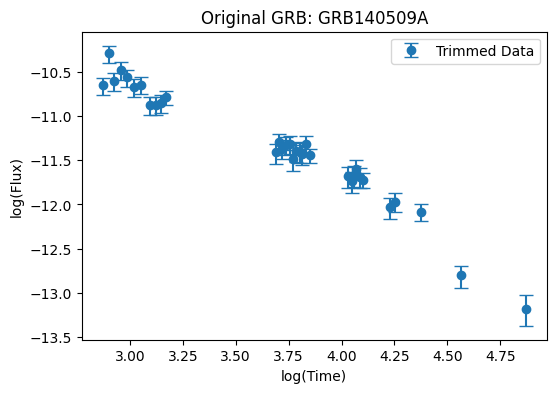


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



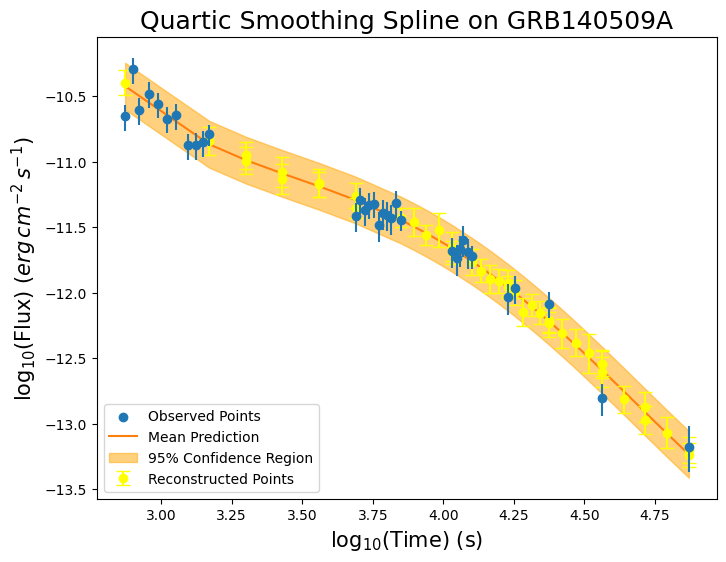

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB140509A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 7.4223e-03  |  Val MSE (log‐flux): 1.8800e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 6.5385e-03  |  Val MSE (log‐flux): 2.1905e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 6.9594e-03  |  Val MSE (log‐flux): 1.9911e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 8.2067e-03  |  Val MSE (log‐flux): 1.0992e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 5.8734e-03  |  Val MSE (log‐flux): 3.3516e-01

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 7.0001e-03
Overall Mean Val   MSE: 8.1353e-02

----- TRAINING FOR GRB141220A -----



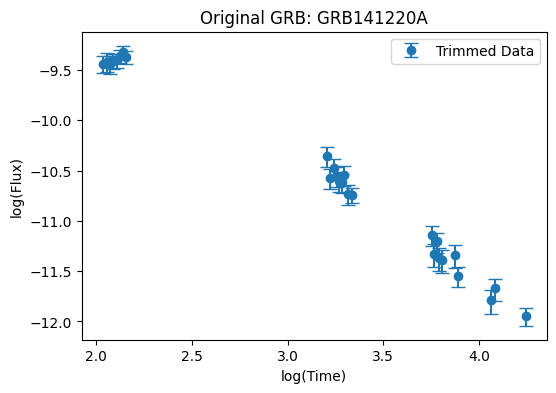


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



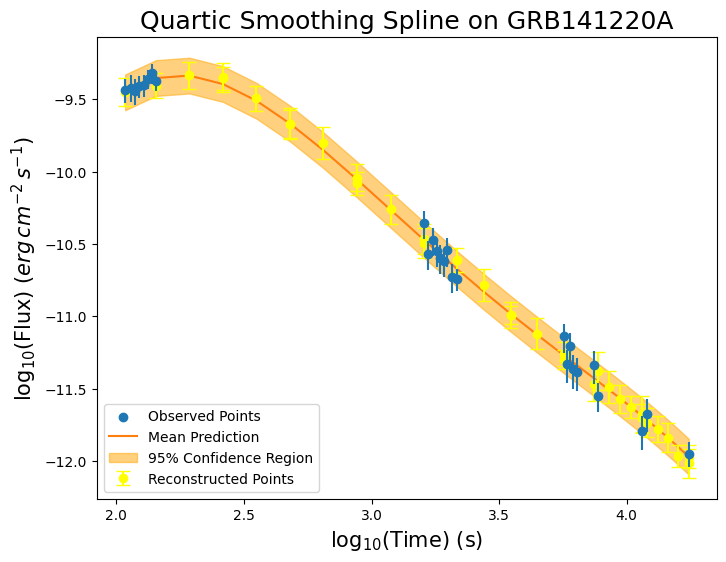

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB141220A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 4.0377e-03  |  Val MSE (log‐flux): 3.8495e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 3.3988e-03  |  Val MSE (log‐flux): 6.4280e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 3.9962e-03  |  Val MSE (log‐flux): 4.3838e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 3.1124e-03  |  Val MSE (log‐flux): 3.9019e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 3.8500e-03  |  Val MSE (log‐flux): 5.4449e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 3.6790e-03
Overall Mean Val   MSE: 1.1825e-02

----- TRAINING FOR GRB151029A -----



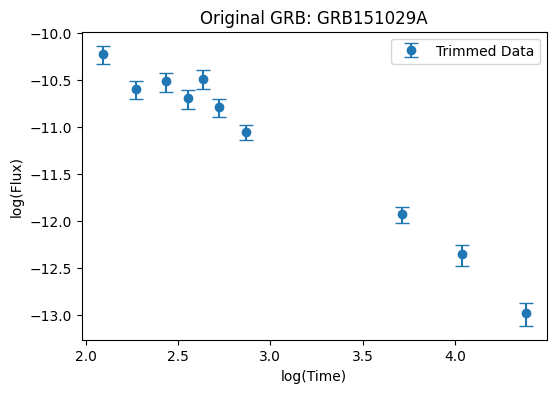


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



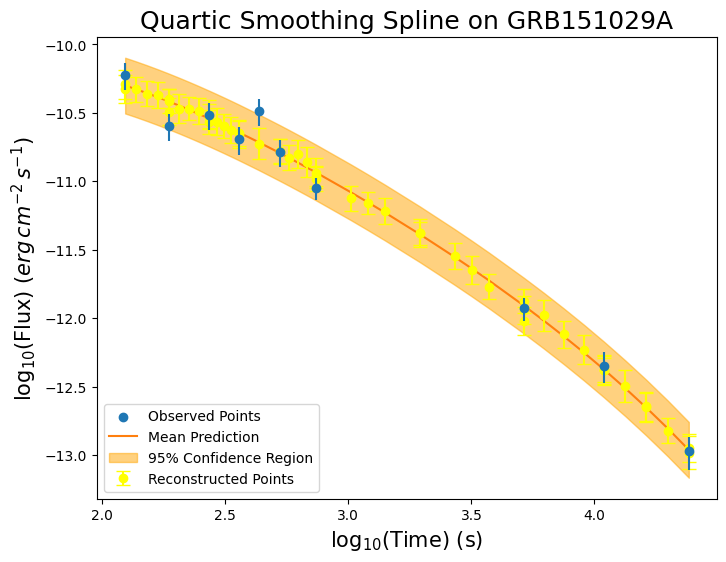

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB151029A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 7.3999e-03  |  Val MSE (log‐flux): 3.8084e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 6.9591e-03  |  Val MSE (log‐flux): 2.3134e-01
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.3157e-02  |  Val MSE (log‐flux): 3.4799e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 4.8798e-03  |  Val MSE (log‐flux): 9.3606e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.5077e-03  |  Val MSE (log‐flux): 3.2754e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.3807e-03
Overall Mean Val   MSE: 7.9852e-02

----- TRAINING FOR GRB160203A -----



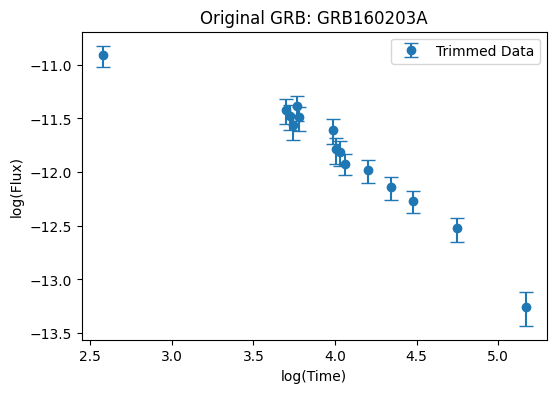


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



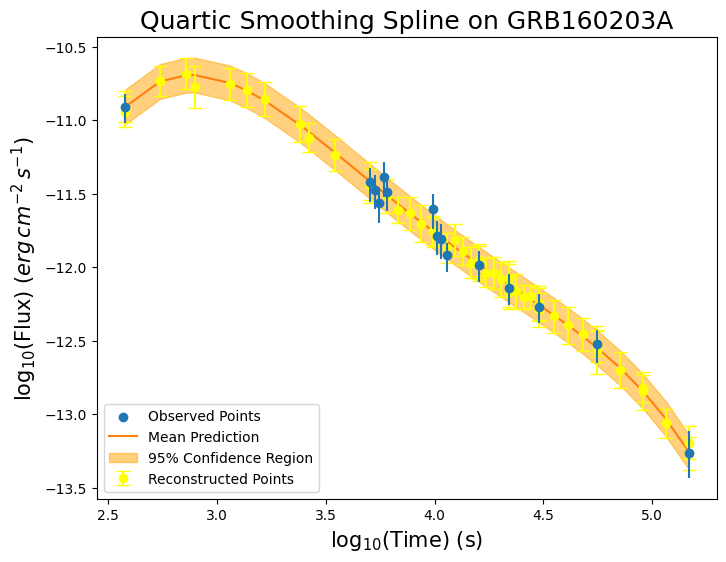

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB160203A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 2.9679e-03  |  Val MSE (log‐flux): 5.0874e+01
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 4.3017e-03  |  Val MSE (log‐flux): 2.9868e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 4.2055e-03  |  Val MSE (log‐flux): 1.0049e-01
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 3.4494e-03  |  Val MSE (log‐flux): 5.1992e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.5276e-03  |  Val MSE (log‐flux): 1.3780e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 3.2904e-03
Overall Mean Val   MSE: 1.0199e+01

----- TRAINING FOR GRB191011A -----



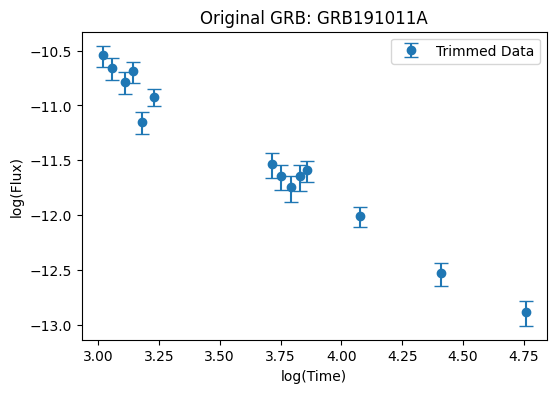


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



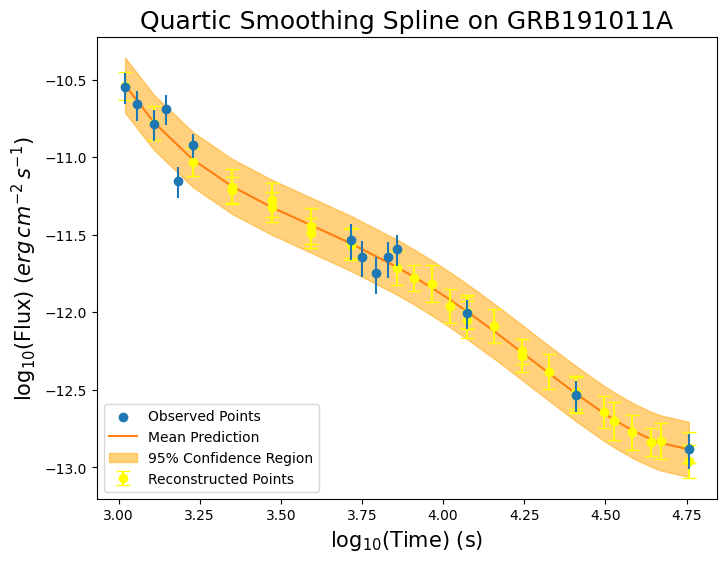

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB191011A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.0316e-02  |  Val MSE (log‐flux): 5.5610e-04
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 7.9477e-03  |  Val MSE (log‐flux): 1.3155e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.0328e-02  |  Val MSE (log‐flux): 2.8372e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 2.4745e-03  |  Val MSE (log‐flux): 4.0028e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 6.4913e-03  |  Val MSE (log‐flux): 2.3519e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 7.5115e-03
Overall Mean Val   MSE: 2.1126e-02

----- TRAINING FOR GRB200205B -----



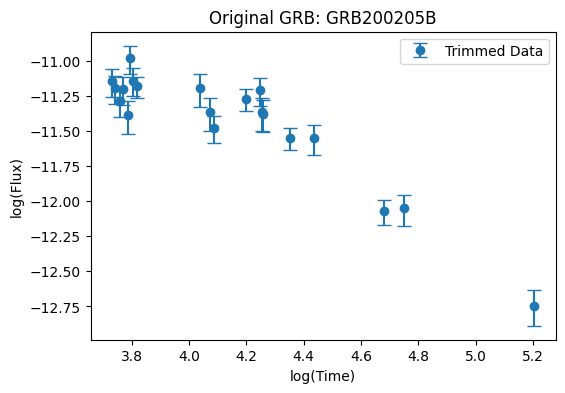


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



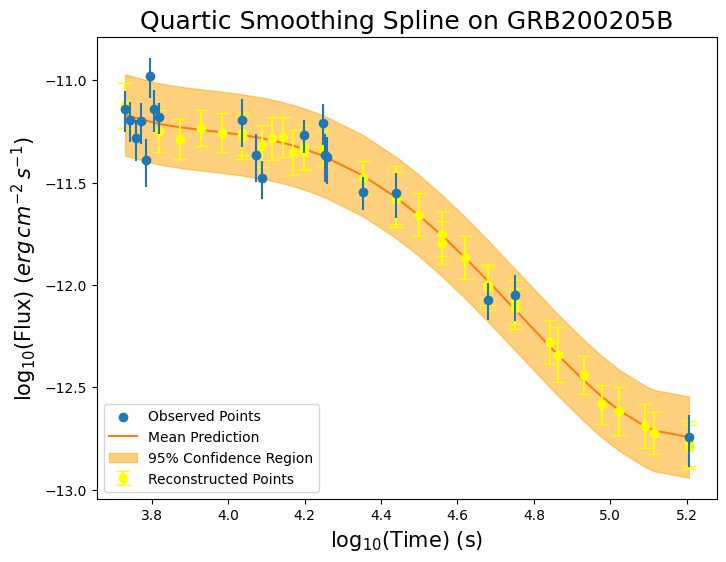

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200205B.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.1194e-02  |  Val MSE (log‐flux): 1.0393e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 7.8280e-03  |  Val MSE (log‐flux): 2.6779e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.1262e-02  |  Val MSE (log‐flux): 1.1775e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 7.7818e-03  |  Val MSE (log‐flux): 2.7453e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.6416e-03  |  Val MSE (log‐flux): 1.4767e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 9.5415e-03
Overall Mean Val   MSE: 1.8233e-02

----- TRAINING FOR GRB201020A -----



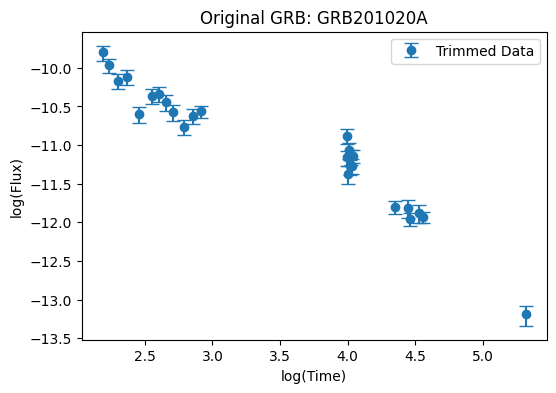


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



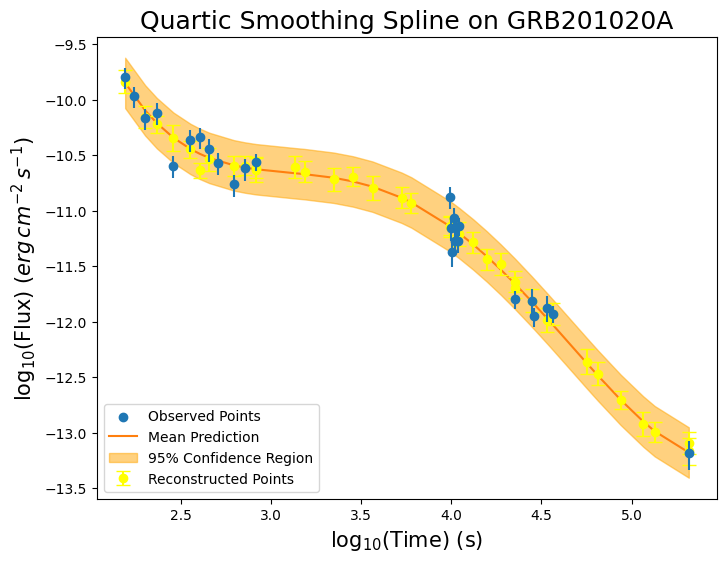

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB201020A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.3960e-02  |  Val MSE (log‐flux): 1.5966e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.5414e-02  |  Val MSE (log‐flux): 6.5152e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 7.8918e-03  |  Val MSE (log‐flux): 4.5232e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.3882e-02  |  Val MSE (log‐flux): 2.8885e-01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.2137e-02  |  Val MSE (log‐flux): 2.3315e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.2657e-02
Overall Mean Val   MSE: 7.5976e-02

----- TRAINING FOR GRB201221A -----



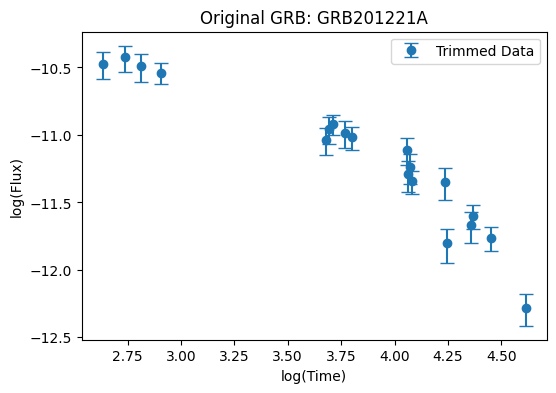


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



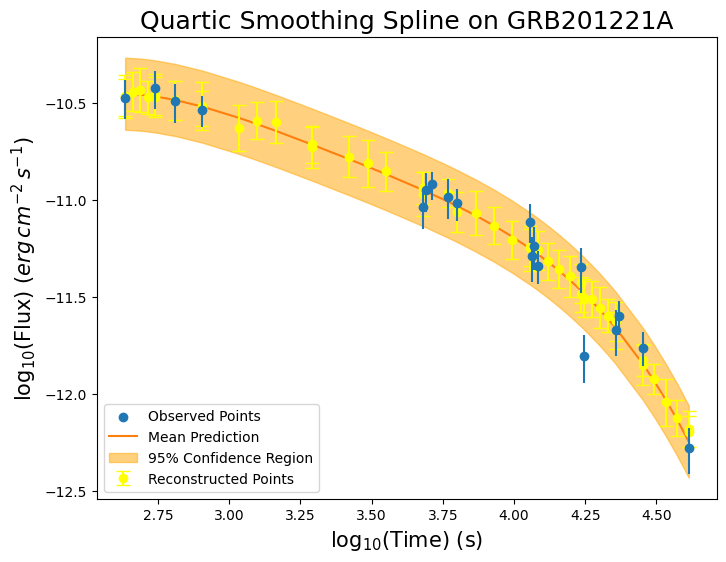

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB201221A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.1116e-02  |  Val MSE (log‐flux): 1.0984e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 9.3627e-03  |  Val MSE (log‐flux): 1.0479e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.2200e-03  |  Val MSE (log‐flux): 1.0153e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.8194e-03  |  Val MSE (log‐flux): 1.8921e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 2.4885e-03  |  Val MSE (log‐flux): 5.4146e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.4013e-03
Overall Mean Val   MSE: 1.8959e-02

----- TRAINING FOR GRB210210A -----



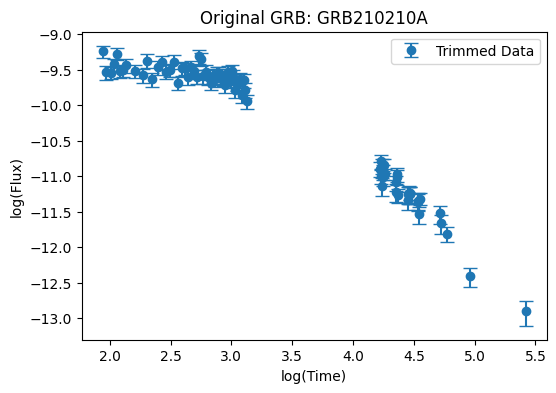


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



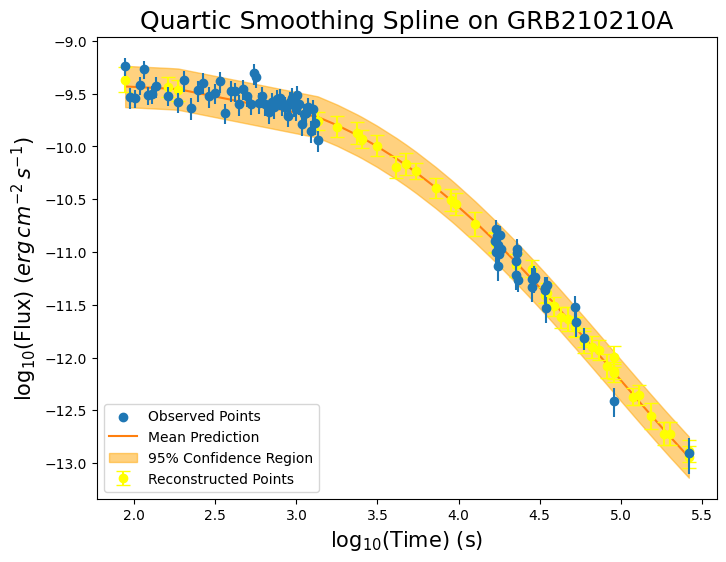

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB210210A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.0484e-02  |  Val MSE (log‐flux): 1.0677e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 9.5139e-03  |  Val MSE (log‐flux): 2.7053e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.5771e-03  |  Val MSE (log‐flux): 1.1499e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 8.1780e-03  |  Val MSE (log‐flux): 1.8348e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.0549e-02  |  Val MSE (log‐flux): 8.5026e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 9.6604e-03
Overall Mean Val   MSE: 1.5216e-02

----- TRAINING FOR GRB210731A -----



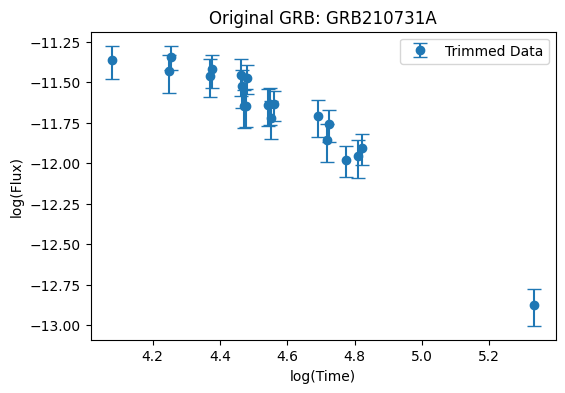


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



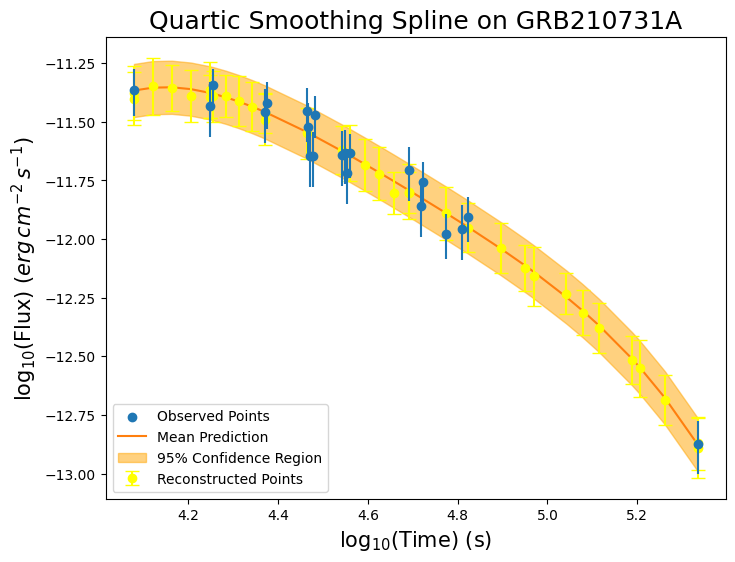

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB210731A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 2.7328e-03  |  Val MSE (log‐flux): 1.4195e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 3.5685e-03  |  Val MSE (log‐flux): 2.8416e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 3.1124e-03  |  Val MSE (log‐flux): 5.2293e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 2.9221e-03  |  Val MSE (log‐flux): 4.7739e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 3.3881e-03  |  Val MSE (log‐flux): 4.2946e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 3.1448e-03
Overall Mean Val   MSE: 1.4860e-02

----- TRAINING FOR GRB220611A -----



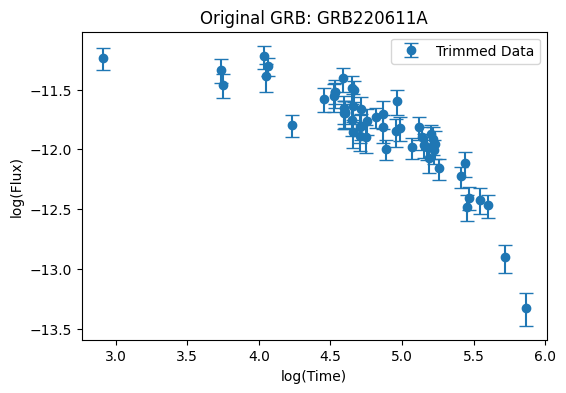


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



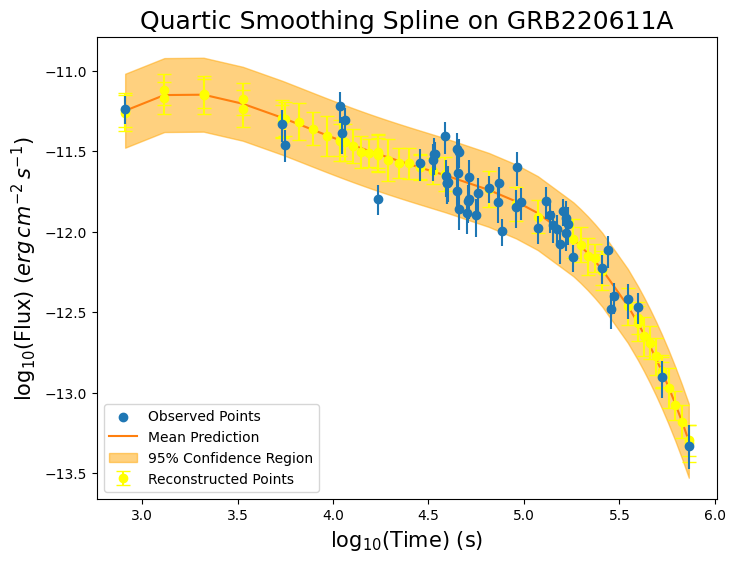

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB220611A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.1971e-02  |  Val MSE (log‐flux): 2.2320e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.4203e-02  |  Val MSE (log‐flux): 1.2848e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.1344e-02  |  Val MSE (log‐flux): 3.6914e-01
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.3468e-02  |  Val MSE (log‐flux): 2.4222e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.5502e-02  |  Val MSE (log‐flux): 1.1685e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.3298e-02
Overall Mean Val   MSE: 8.8044e-02

----- TRAINING FOR GRB230116D -----



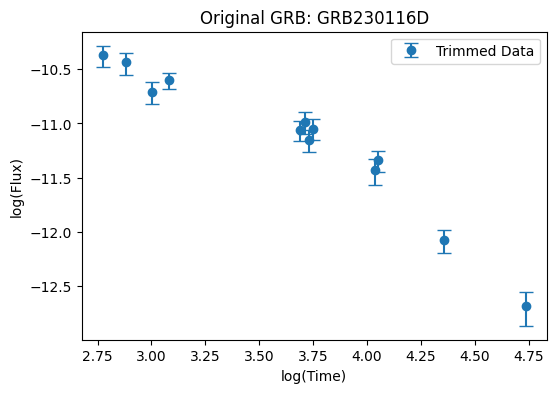


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



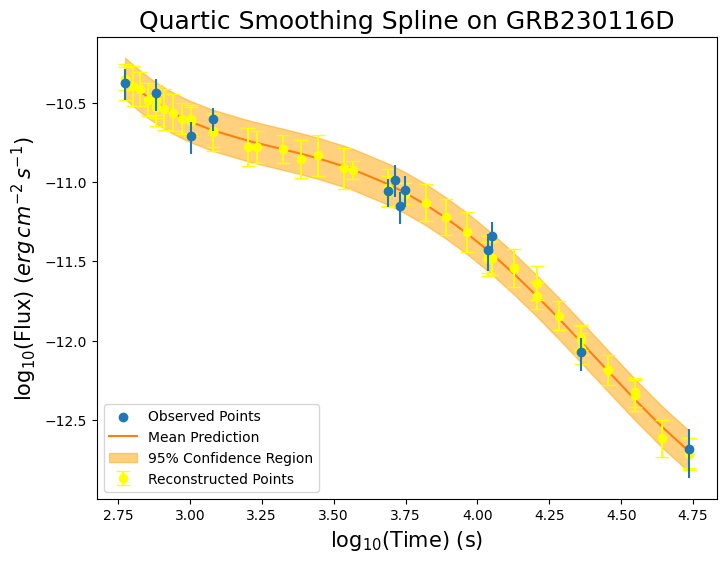

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB230116D.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 3.4177e-03  |  Val MSE (log‐flux): 9.4567e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 3.9650e-03  |  Val MSE (log‐flux): 8.8001e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 3.6019e-03  |  Val MSE (log‐flux): 5.2213e-01
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 4.9790e-03  |  Val MSE (log‐flux): 1.6149e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 2.9505e-03  |  Val MSE (log‐flux): 1.6890e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 3.7828e-03
Overall Mean Val   MSE: 1.1178e-01

----- TRAINING FOR GRB230328B -----



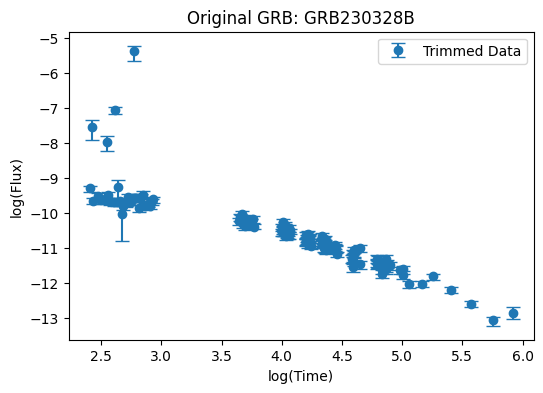


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



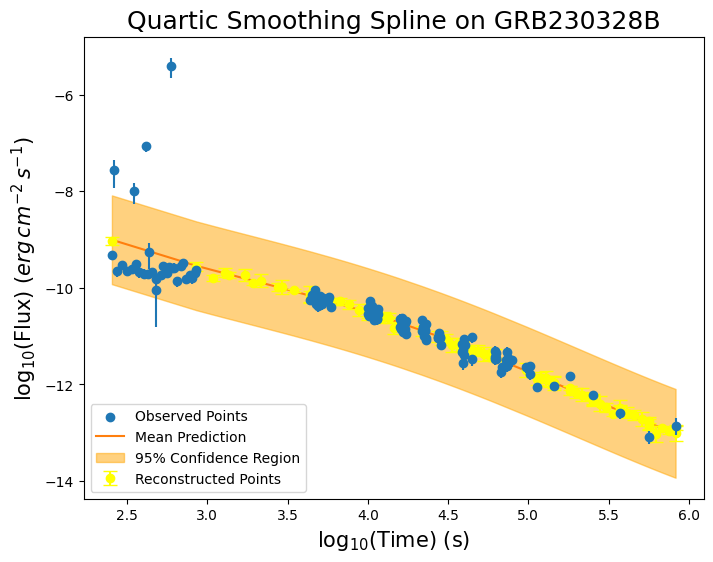

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB230328B.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 2.2148e-01  |  Val MSE (log‐flux): 2.1479e-01
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 2.6324e-01  |  Val MSE (log‐flux): 5.9023e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 2.5891e-01  |  Val MSE (log‐flux): 8.4649e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 2.5978e-01  |  Val MSE (log‐flux): 6.4499e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 8.5752e-02  |  Val MSE (log‐flux): 8.0217e-01

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 2.1783e-01
Overall Mean Val   MSE: 2.4503e-01

----- TRAINING FOR GRB230506C -----



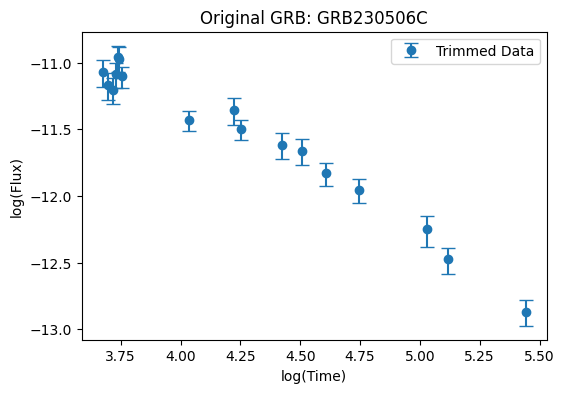


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



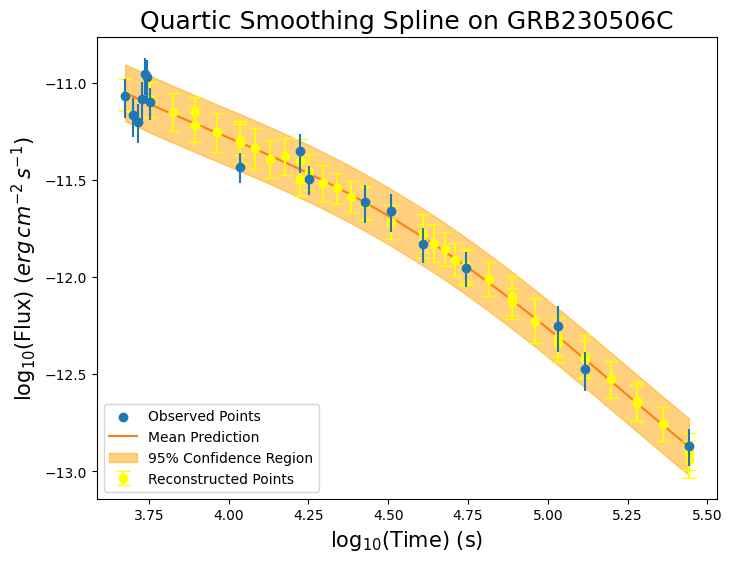

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB230506C.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 4.7634e-03  |  Val MSE (log‐flux): 8.9947e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 5.7696e-03  |  Val MSE (log‐flux): 7.7958e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 5.3800e-03  |  Val MSE (log‐flux): 6.7231e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 3.4837e-03  |  Val MSE (log‐flux): 2.0654e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 6.5905e-03  |  Val MSE (log‐flux): 9.4979e-04

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 5.1974e-03
Overall Mean Val   MSE: 2.1125e-02

----- TRAINING FOR GRB230618A -----



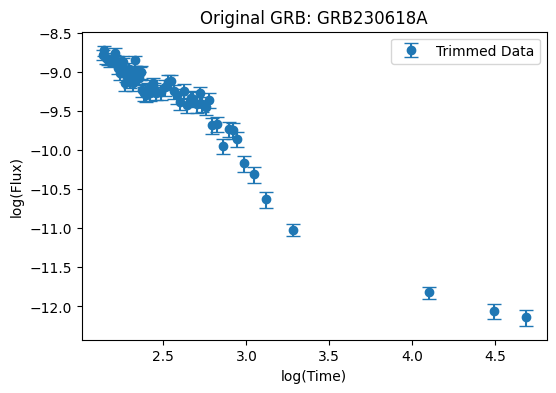


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



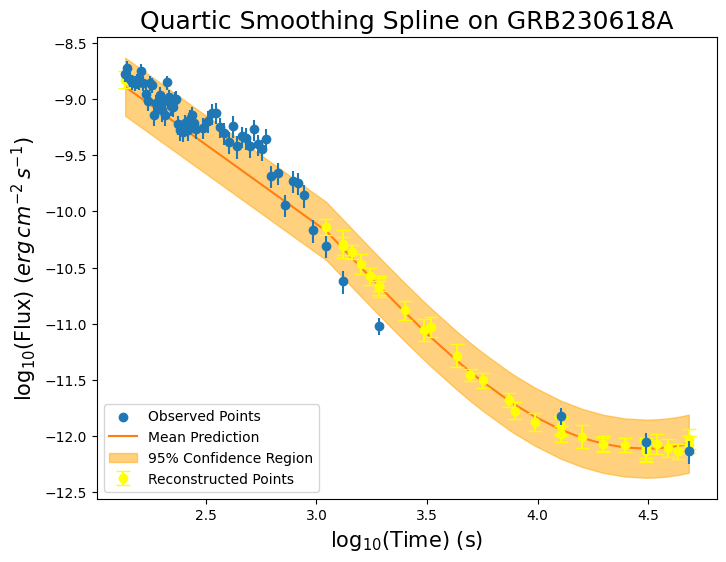

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB230618A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.9387e-02  |  Val MSE (log‐flux): 1.8045e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.5016e-02  |  Val MSE (log‐flux): 2.9544e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.2626e-02  |  Val MSE (log‐flux): 4.5044e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.9073e-02  |  Val MSE (log‐flux): 1.1191e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.7400e-02  |  Val MSE (log‐flux): 3.1841e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.6700e-02
Overall Mean Val   MSE: 2.7133e-02

----- TRAINING FOR GRB230628E -----



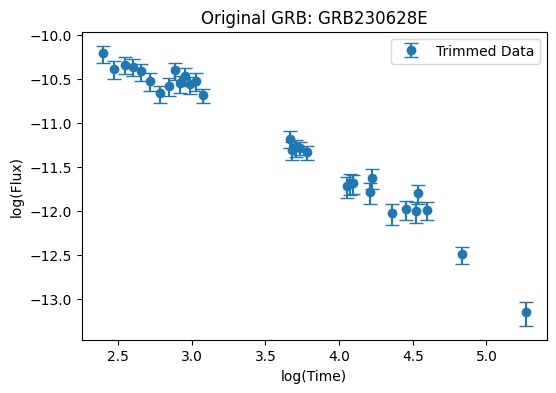


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



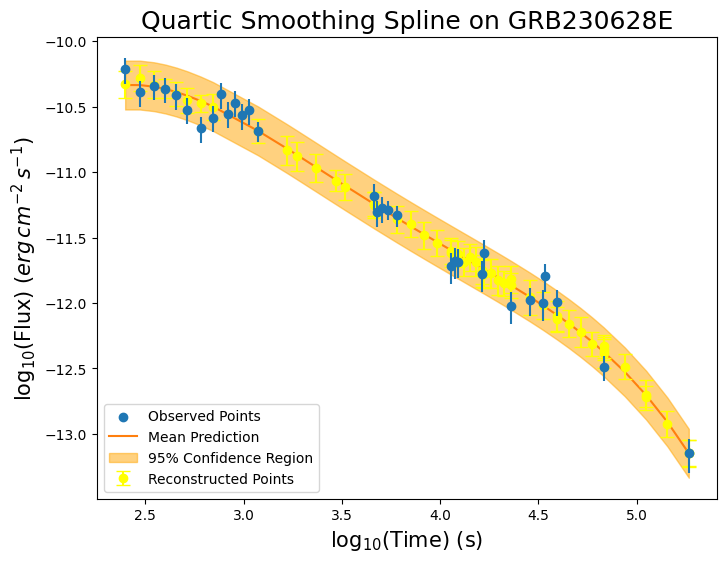

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB230628E.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 6.9826e-03  |  Val MSE (log‐flux): 1.8248e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 8.2396e-03  |  Val MSE (log‐flux): 1.5436e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.0806e-02  |  Val MSE (log‐flux): 2.4717e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0857e-02  |  Val MSE (log‐flux): 3.1603e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.2945e-03  |  Val MSE (log‐flux): 1.7305e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.8360e-03
Overall Mean Val   MSE: 1.1324e-02

----- TRAINING FOR GRB230815A -----



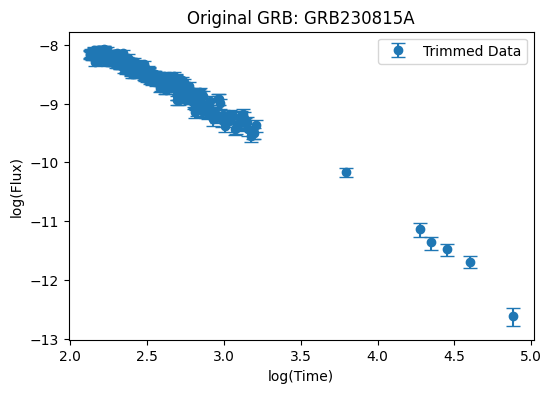


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



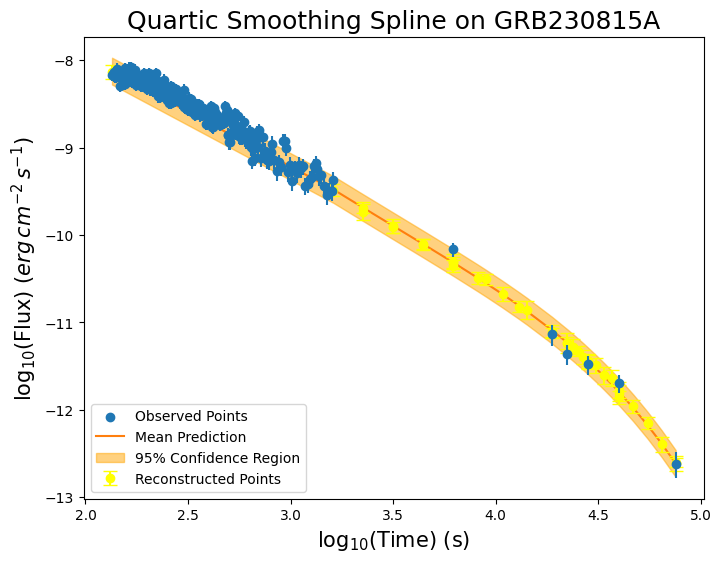

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB230815A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 6.2758e-03  |  Val MSE (log‐flux): 5.6725e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 5.8605e-03  |  Val MSE (log‐flux): 7.3105e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 6.0445e-03  |  Val MSE (log‐flux): 6.5499e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 6.2439e-03  |  Val MSE (log‐flux): 5.7309e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 6.0561e-03  |  Val MSE (log‐flux): 6.4437e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 6.0962e-03
Overall Mean Val   MSE: 6.3415e-03

----- TRAINING FOR GRB230818A -----



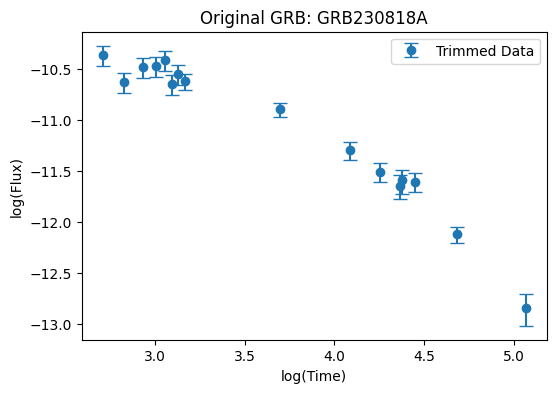


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



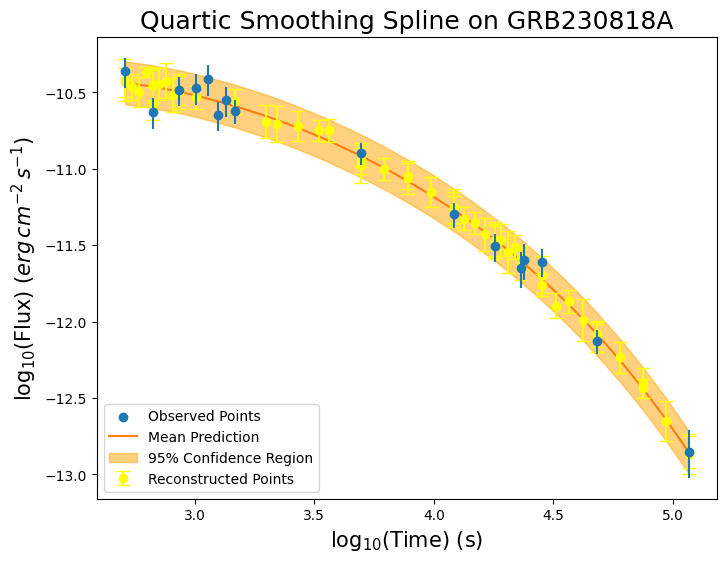

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB230818A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 2.2797e-03  |  Val MSE (log‐flux): 1.8809e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 4.9774e-03  |  Val MSE (log‐flux): 6.7299e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 6.1657e-03  |  Val MSE (log‐flux): 3.6293e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 4.5545e-03  |  Val MSE (log‐flux): 8.9951e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 5.9183e-03  |  Val MSE (log‐flux): 2.1786e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 4.7791e-03
Overall Mean Val   MSE: 8.0684e-03

----- TRAINING FOR GRB230826A -----



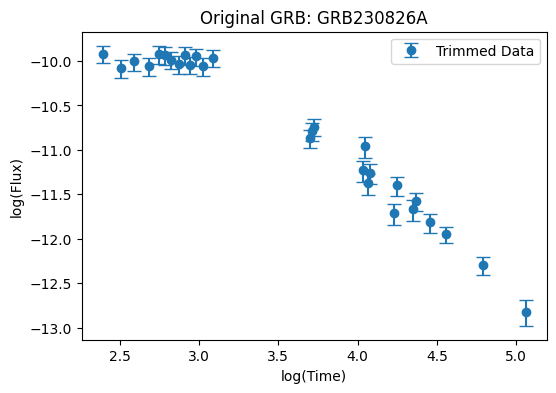


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



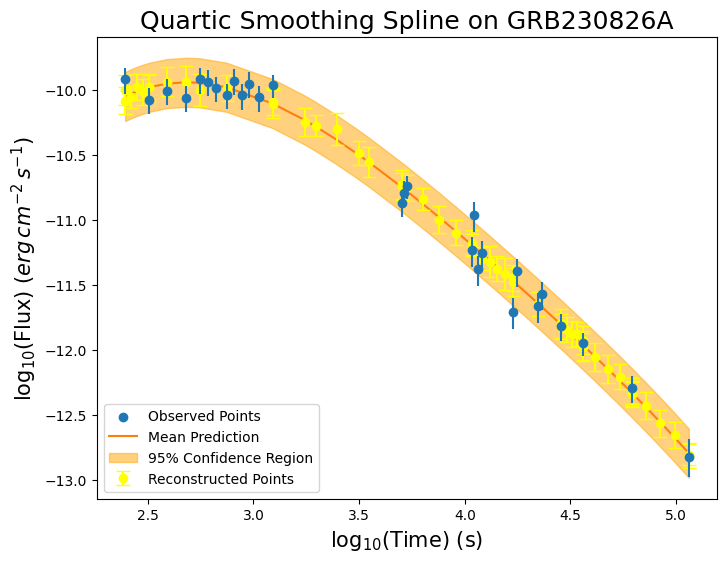

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB230826A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 8.3335e-03  |  Val MSE (log‐flux): 2.2319e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 7.5158e-03  |  Val MSE (log‐flux): 1.7450e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.0319e-02  |  Val MSE (log‐flux): 6.4314e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 7.1681e-03  |  Val MSE (log‐flux): 2.4655e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.0813e-02  |  Val MSE (log‐flux): 2.2649e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.8299e-03
Overall Mean Val   MSE: 1.4624e-02

----- TRAINING FOR GRB230903A -----



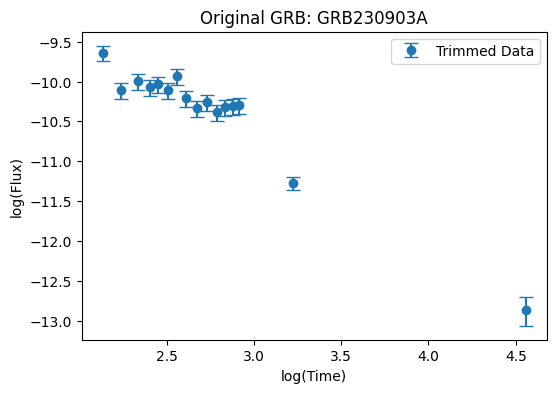


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



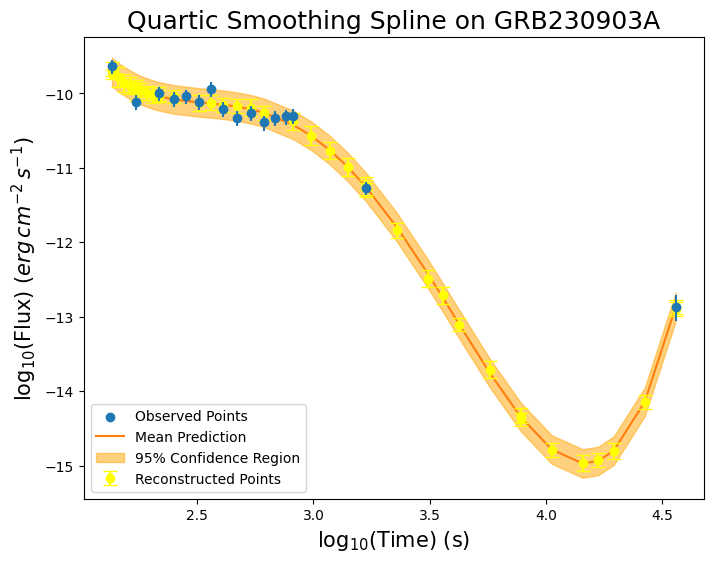

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB230903A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 4.3009e-03  |  Val MSE (log‐flux): 1.4879e+00
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 8.5176e-03  |  Val MSE (log‐flux): 1.5047e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.1358e-02  |  Val MSE (log‐flux): 1.0288e+01
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.5218e-03  |  Val MSE (log‐flux): 1.1731e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.6212e-03  |  Val MSE (log‐flux): 2.2141e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.2638e-03
Overall Mean Val   MSE: 2.3649e+00

----- TRAINING FOR GRB231104A -----



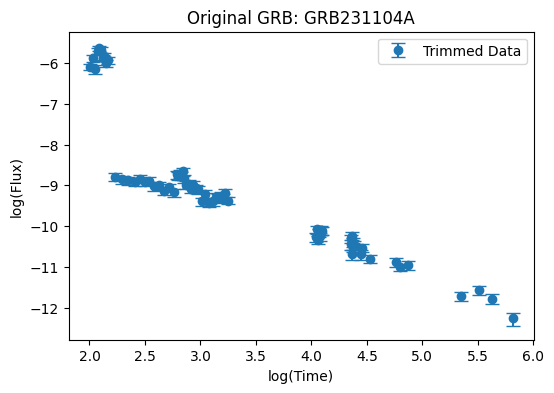


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



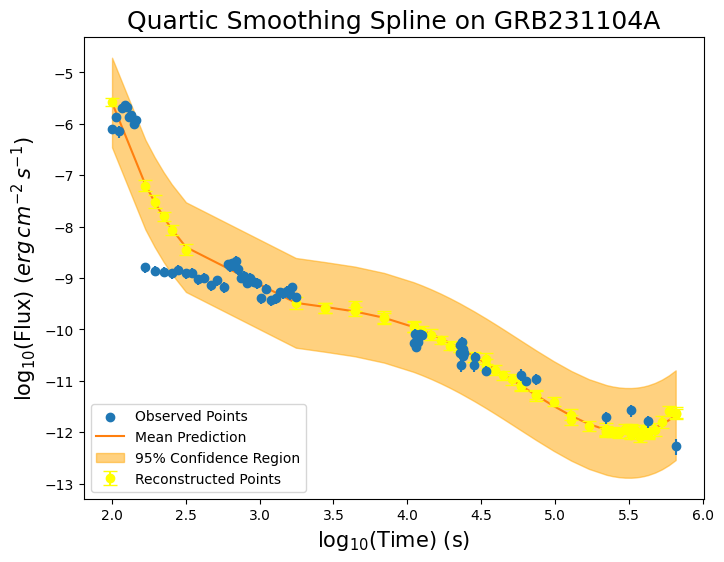

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB231104A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.3727e-01  |  Val MSE (log‐flux): 4.4101e-01
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 2.1187e-01  |  Val MSE (log‐flux): 2.5375e-01
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 2.0173e-01  |  Val MSE (log‐flux): 2.0213e-01
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.8250e-01  |  Val MSE (log‐flux): 3.7546e-01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 2.3017e-01  |  Val MSE (log‐flux): 6.2975e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.9271e-01
Overall Mean Val   MSE: 2.6706e-01

----- TRAINING FOR GRB231205B -----



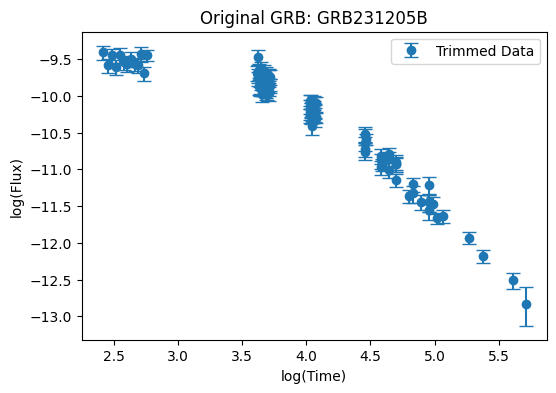


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



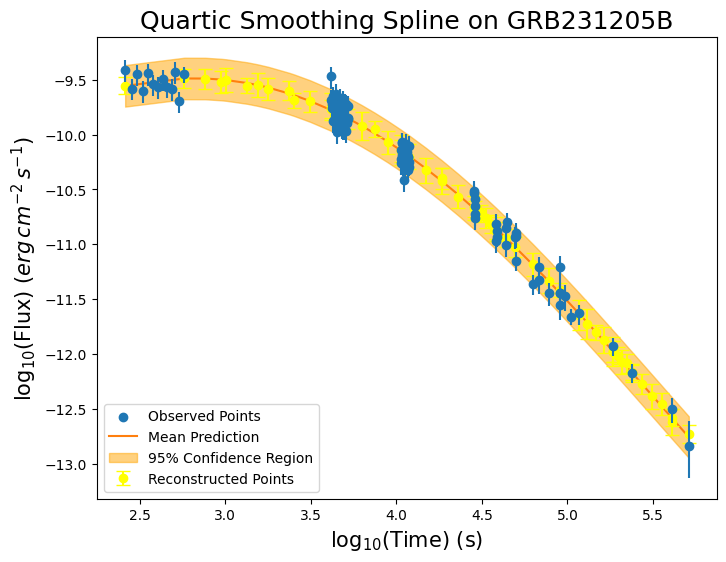

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB231205B.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 9.1415e-03  |  Val MSE (log‐flux): 1.1611e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 9.1644e-03  |  Val MSE (log‐flux): 1.1695e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.9962e-03  |  Val MSE (log‐flux): 7.0200e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.7976e-03  |  Val MSE (log‐flux): 8.2296e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.6874e-03  |  Val MSE (log‐flux): 1.6508e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 9.1574e-03
Overall Mean Val   MSE: 1.1013e-02

----- TRAINING FOR GRB240101A -----



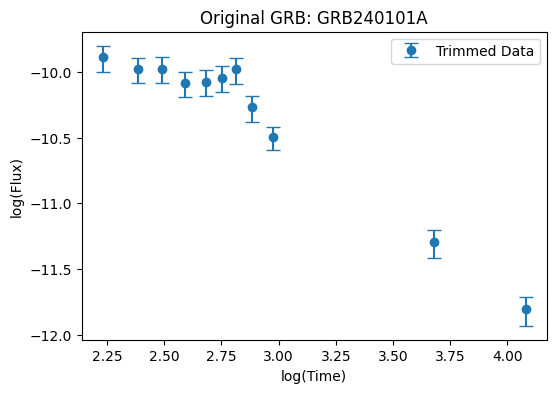


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



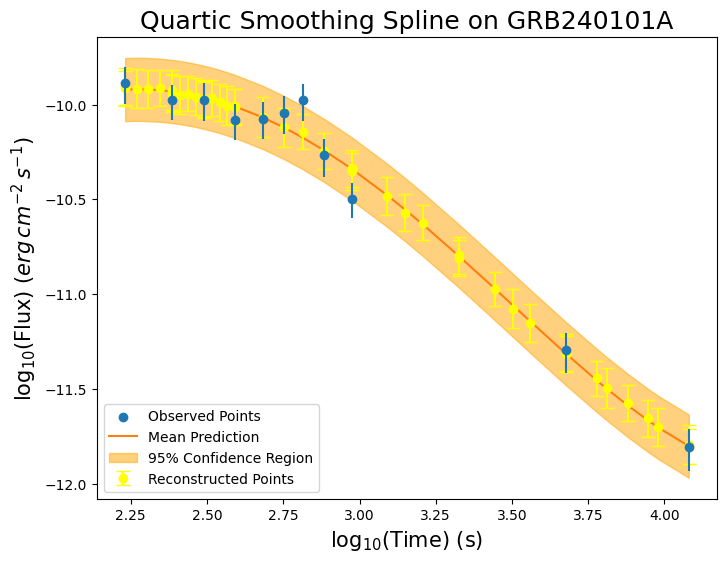

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB240101A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 3.3851e-03  |  Val MSE (log‐flux): 5.2901e+00
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 4.2012e-03  |  Val MSE (log‐flux): 4.0386e+01
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 4.0339e-03  |  Val MSE (log‐flux): 3.6650e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 8.7355e-03  |  Val MSE (log‐flux): 7.1930e-04
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 3.1067e-03  |  Val MSE (log‐flux): 3.0375e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 4.6925e-03
Overall Mean Val   MSE: 9.1488e+00

----- TRAINING FOR GRB240112C -----



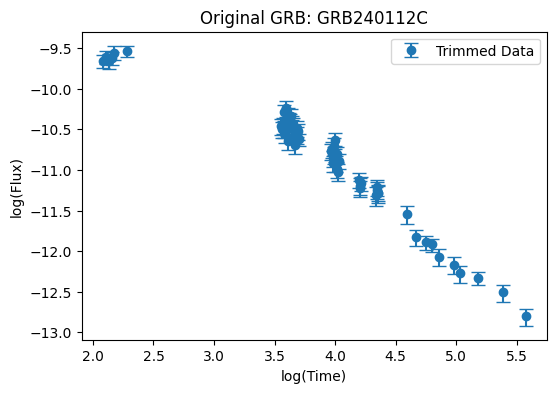


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



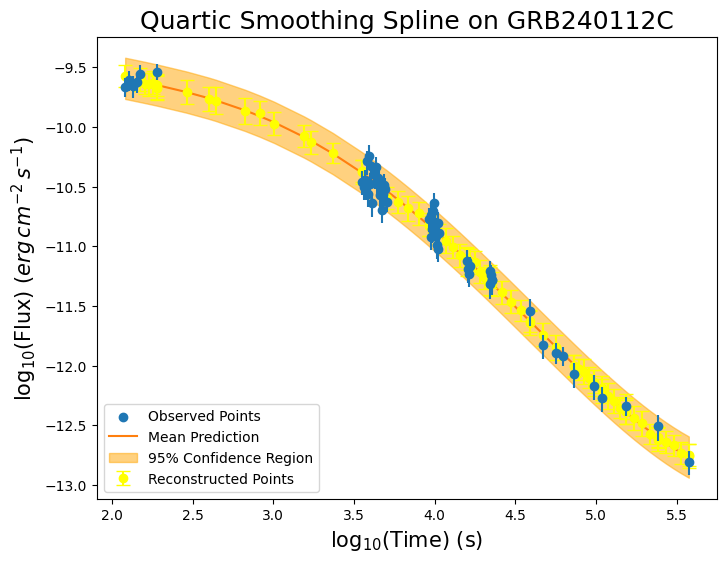

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB240112C.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 7.7612e-03  |  Val MSE (log‐flux): 9.2853e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 7.8335e-03  |  Val MSE (log‐flux): 7.9253e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 7.0415e-03  |  Val MSE (log‐flux): 1.2217e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 7.8655e-03  |  Val MSE (log‐flux): 7.7105e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.6344e-03  |  Val MSE (log‐flux): 9.4838e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 7.6272e-03
Overall Mean Val   MSE: 9.3245e-03

----- TRAINING FOR GRB240123A -----



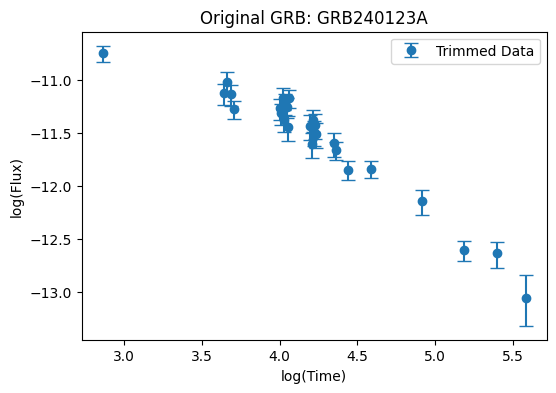


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



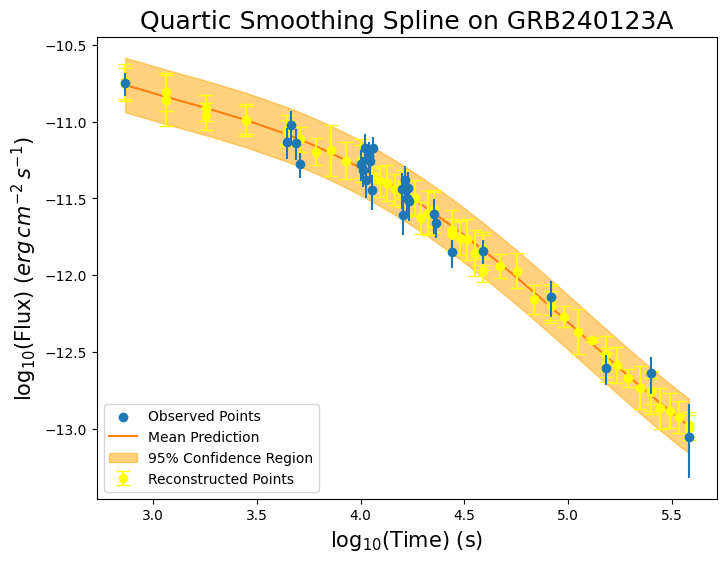

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB240123A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 6.5193e-03  |  Val MSE (log‐flux): 1.7261e+00
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 6.1651e-03  |  Val MSE (log‐flux): 2.3299e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.2931e-03  |  Val MSE (log‐flux): 3.9610e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 7.1834e-03  |  Val MSE (log‐flux): 1.3061e-01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.8290e-03  |  Val MSE (log‐flux): 1.0161e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 7.3980e-03
Overall Mean Val   MSE: 3.7882e-01

----- TRAINING FOR GRB240204A -----



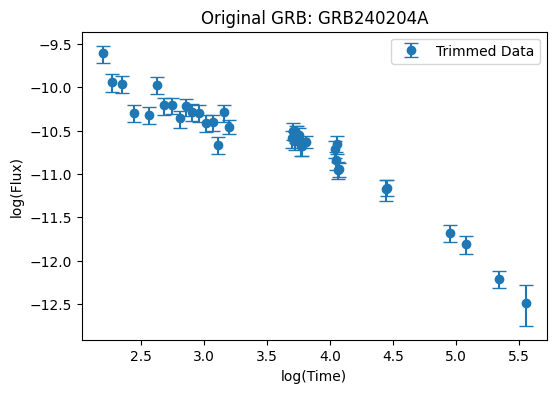


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



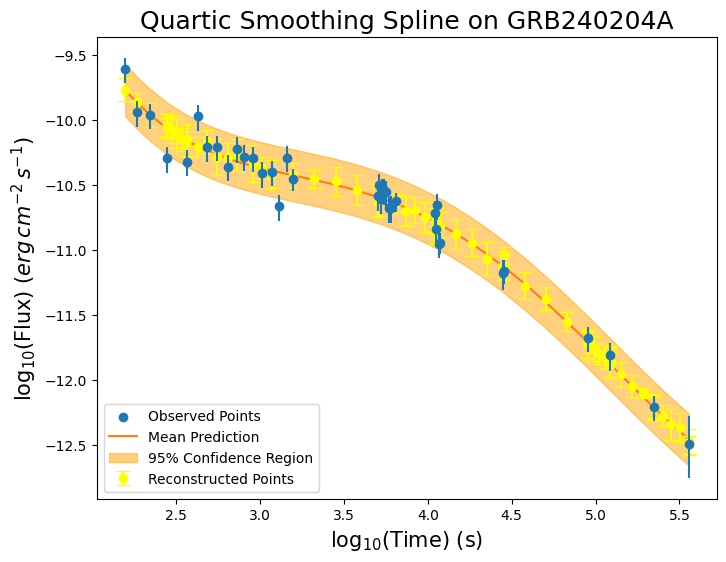

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB240204A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.1234e-02  |  Val MSE (log‐flux): 7.6183e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.2009e-02  |  Val MSE (log‐flux): 4.6644e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 8.4979e-03  |  Val MSE (log‐flux): 3.0916e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.4885e-03  |  Val MSE (log‐flux): 1.8421e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 8.8591e-03  |  Val MSE (log‐flux): 1.8281e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.0018e-02
Overall Mean Val   MSE: 1.5980e-02

----- TRAINING FOR GRB190821A -----



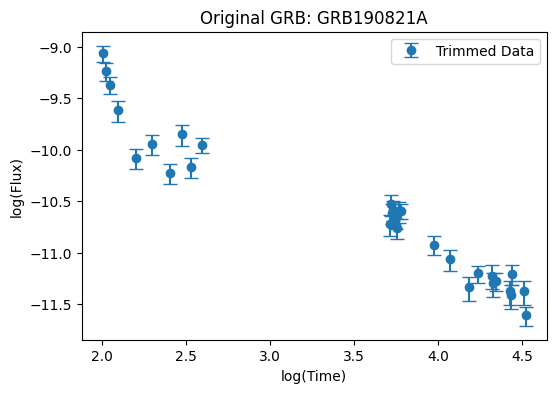


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



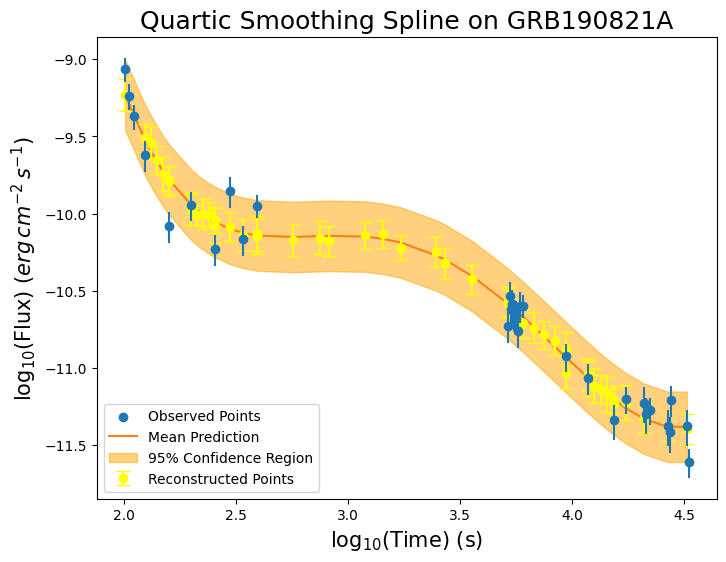

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB190821A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.2571e-02  |  Val MSE (log‐flux): 2.3175e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.1772e-02  |  Val MSE (log‐flux): 2.3204e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.5602e-02  |  Val MSE (log‐flux): 5.2556e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.2807e-02  |  Val MSE (log‐flux): 2.4786e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.2125e-02  |  Val MSE (log‐flux): 2.0469e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.2975e-02
Overall Mean Val   MSE: 1.9378e-02

----- TRAINING FOR GRB190824A -----



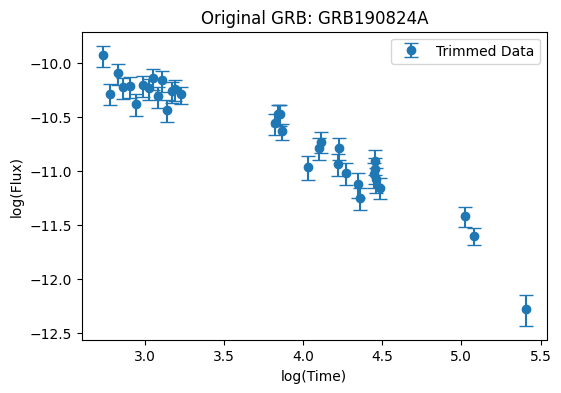


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



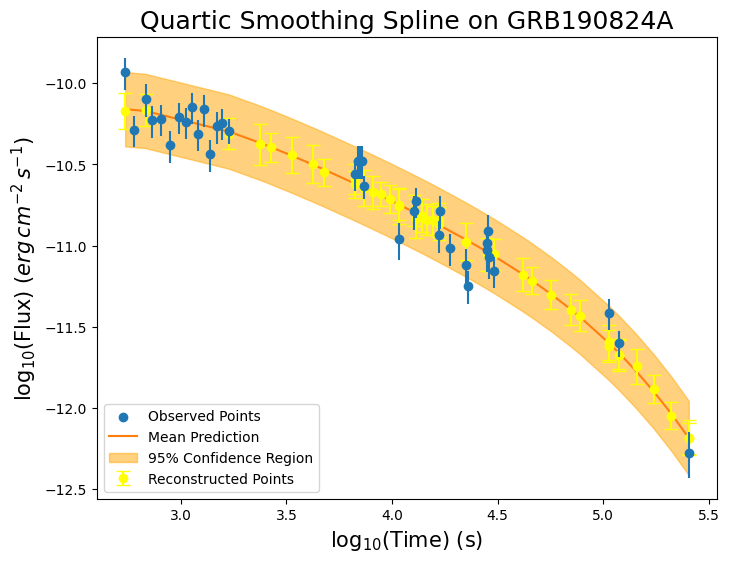

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB190824A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.1856e-02  |  Val MSE (log‐flux): 1.4463e-01
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.2475e-02  |  Val MSE (log‐flux): 2.6118e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.2942e-02  |  Val MSE (log‐flux): 2.0216e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.1605e-02  |  Val MSE (log‐flux): 2.5145e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.3988e-02  |  Val MSE (log‐flux): 1.2603e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.2573e-02
Overall Mean Val   MSE: 4.5742e-02

----- TRAINING FOR GRB191004A -----



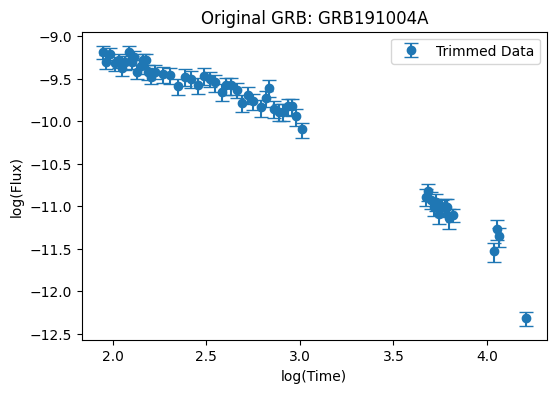


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



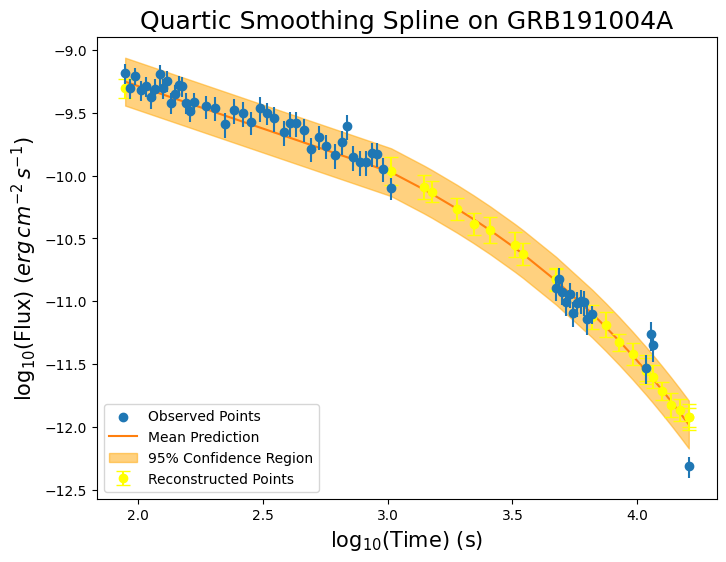

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB191004A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.0248e-02  |  Val MSE (log‐flux): 7.8805e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.1154e-02  |  Val MSE (log‐flux): 3.3284e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 5.1254e-03  |  Val MSE (log‐flux): 3.6920e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0093e-02  |  Val MSE (log‐flux): 7.9061e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 4.7219e-03  |  Val MSE (log‐flux): 6.8094e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.2683e-03
Overall Mean Val   MSE: 2.4826e-02

----- TRAINING FOR GRB191017B -----



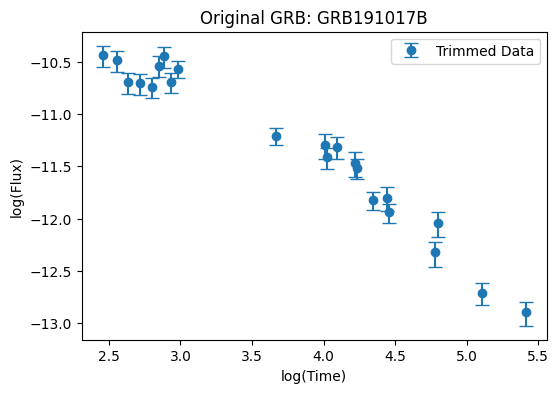


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



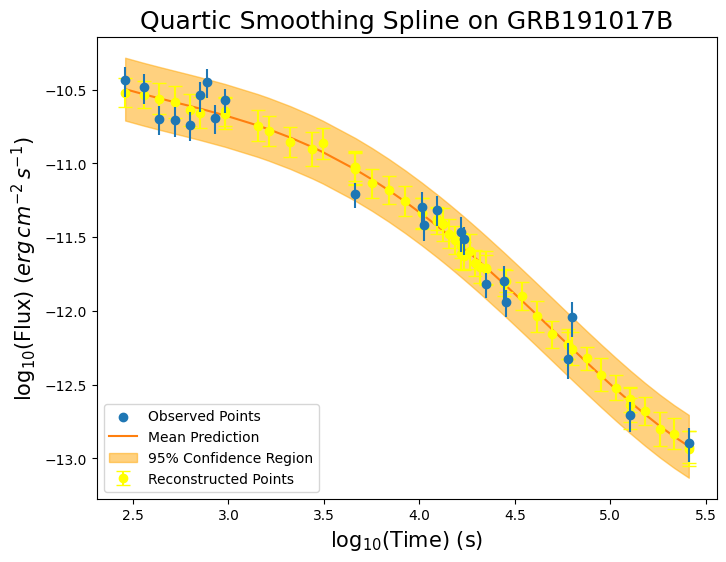

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB191017B.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.1736e-02  |  Val MSE (log‐flux): 3.8604e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.1699e-02  |  Val MSE (log‐flux): 1.5468e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.2031e-02  |  Val MSE (log‐flux): 1.4844e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0887e-02  |  Val MSE (log‐flux): 2.1343e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.9391e-03  |  Val MSE (log‐flux): 3.8232e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.0858e-02
Overall Mean Val   MSE: 2.5698e-02

----- TRAINING FOR GRB191029A -----



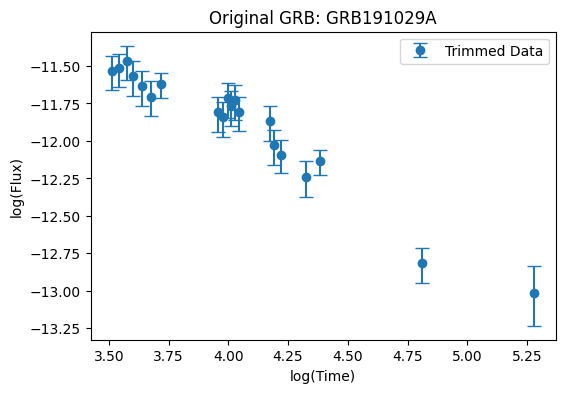


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



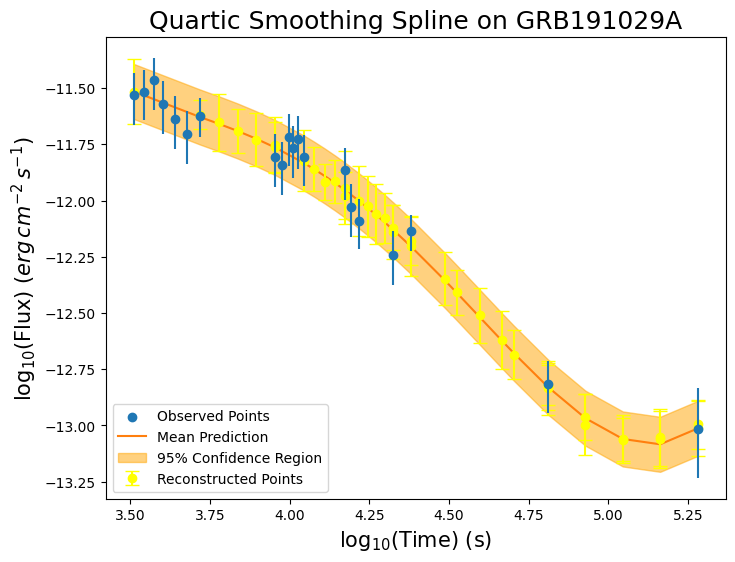

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB191029A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 4.0315e-03  |  Val MSE (log‐flux): 3.4329e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 3.3803e-03  |  Val MSE (log‐flux): 6.8507e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 2.9743e-03  |  Val MSE (log‐flux): 8.5092e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 4.1434e-03  |  Val MSE (log‐flux): 1.9372e-01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 4.4557e-03  |  Val MSE (log‐flux): 1.8036e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 3.7970e-03
Overall Mean Val   MSE: 4.2864e-02

----- TRAINING FOR GRB191101A -----



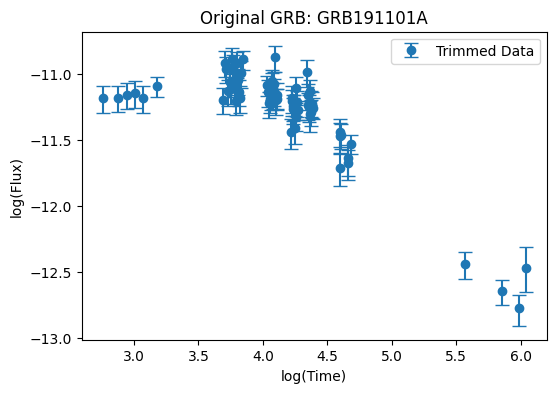


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



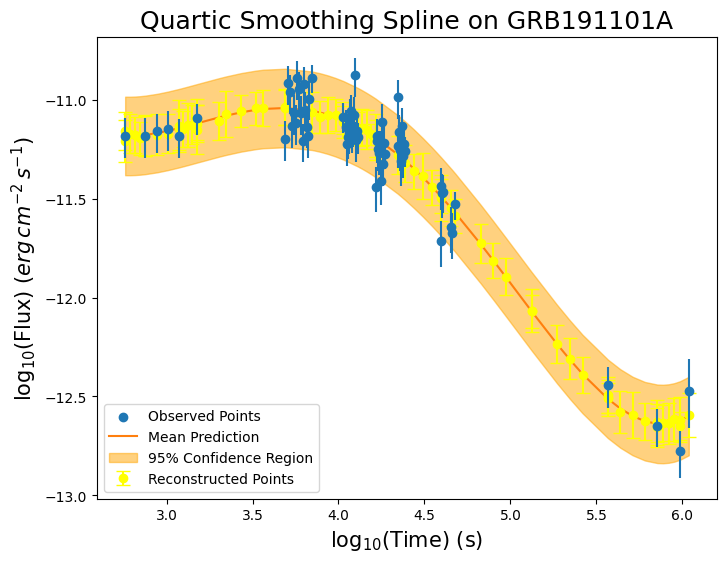

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB191101A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 9.9133e-03  |  Val MSE (log‐flux): 1.1782e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 9.6285e-03  |  Val MSE (log‐flux): 1.2763e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.0327e-02  |  Val MSE (log‐flux): 1.0747e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0090e-02  |  Val MSE (log‐flux): 1.1257e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.0929e-02  |  Val MSE (log‐flux): 7.4163e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.0178e-02
Overall Mean Val   MSE: 1.0793e-02

----- TRAINING FOR GRB191122A -----



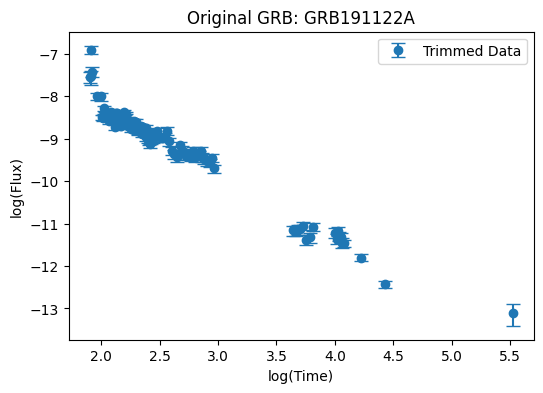


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



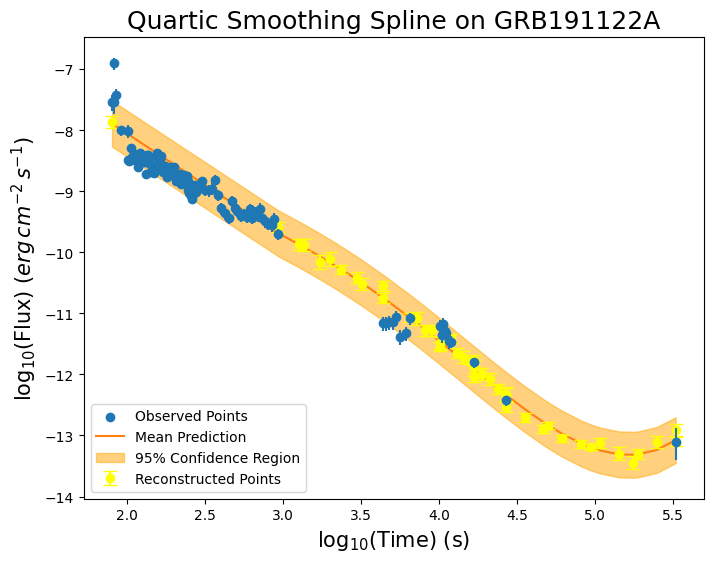

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB191122A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 4.0615e-02  |  Val MSE (log‐flux): 2.1952e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 4.2306e-02  |  Val MSE (log‐flux): 1.6726e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 3.3248e-02  |  Val MSE (log‐flux): 5.4499e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 3.8186e-02  |  Val MSE (log‐flux): 3.4626e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 2.6038e-02  |  Val MSE (log‐flux): 5.6408e-01

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 3.6079e-02
Overall Mean Val   MSE: 1.3838e-01

----- TRAINING FOR GRB191123A -----



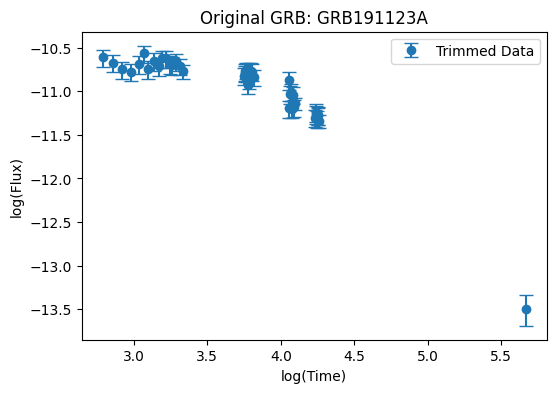


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



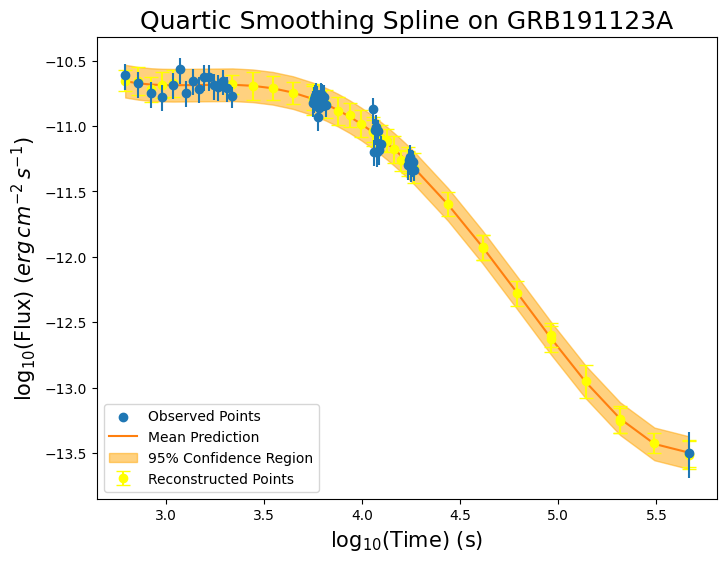

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB191123A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 4.7235e-03  |  Val MSE (log‐flux): 1.8020e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 2.9405e-03  |  Val MSE (log‐flux): 8.9961e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 4.1833e-03  |  Val MSE (log‐flux): 4.7573e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 3.9147e-03  |  Val MSE (log‐flux): 1.9738e+00
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 4.0709e-03  |  Val MSE (log‐flux): 4.4097e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 3.9666e-03
Overall Mean Val   MSE: 3.9875e-01

----- TRAINING FOR GRB191220A -----



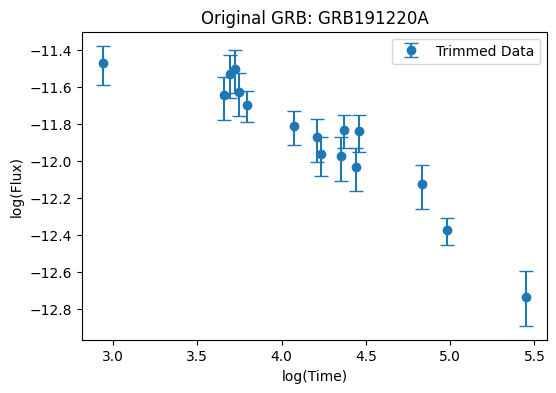


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



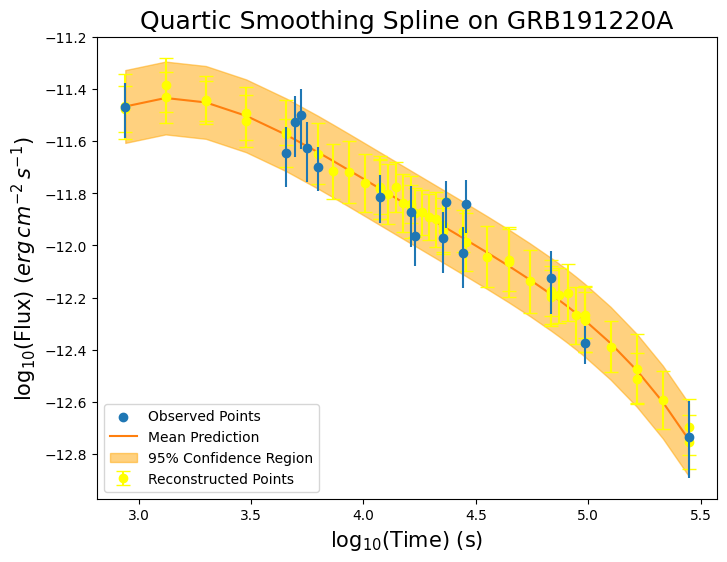

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB191220A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 3.3495e-03  |  Val MSE (log‐flux): 4.0270e+00
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 4.4411e-03  |  Val MSE (log‐flux): 1.0812e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 4.0115e-03  |  Val MSE (log‐flux): 1.0917e+00
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 5.3523e-03  |  Val MSE (log‐flux): 4.6008e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 3.5445e-03  |  Val MSE (log‐flux): 1.3629e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 4.1398e-03
Overall Mean Val   MSE: 1.0296e+00

----- TRAINING FOR GRB191228A -----



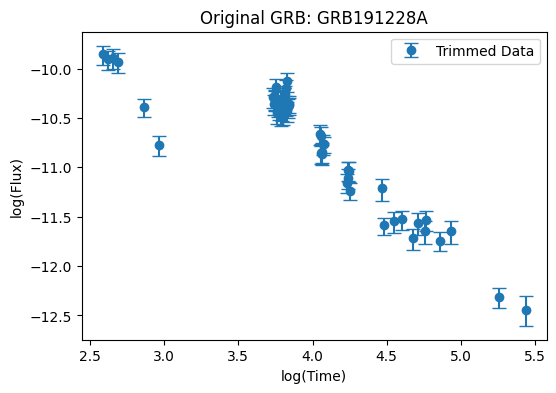


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



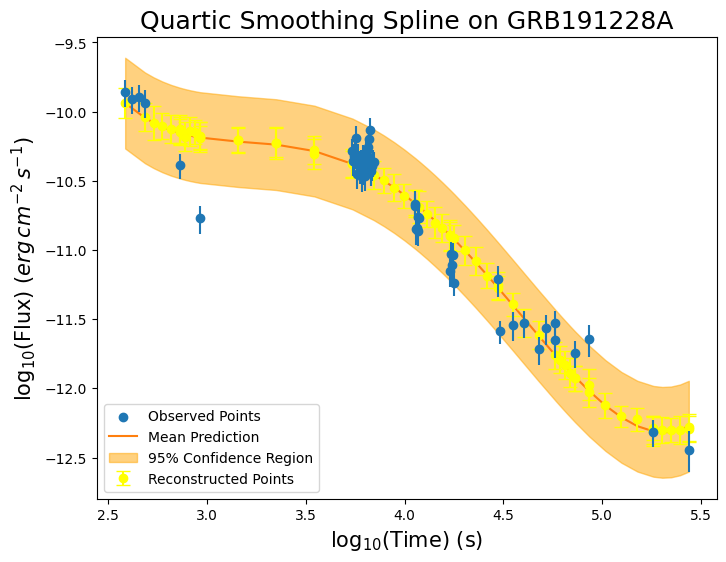

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB191228A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 2.0943e-02  |  Val MSE (log‐flux): 7.5812e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 2.9519e-02  |  Val MSE (log‐flux): 2.2884e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 3.1468e-02  |  Val MSE (log‐flux): 1.4849e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 2.4493e-02  |  Val MSE (log‐flux): 4.9895e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 2.6487e-02  |  Val MSE (log‐flux): 6.6201e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 2.6582e-02
Overall Mean Val   MSE: 4.5928e-02

----- TRAINING FOR GRB200131A -----



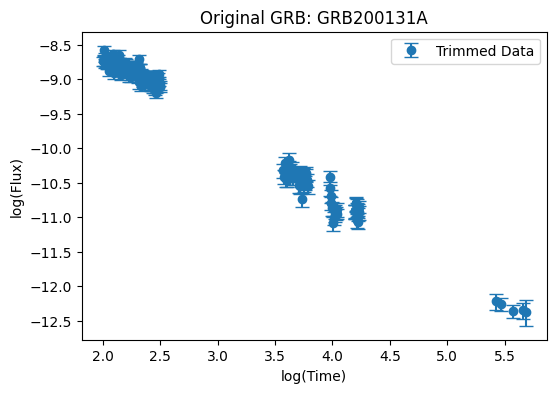


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



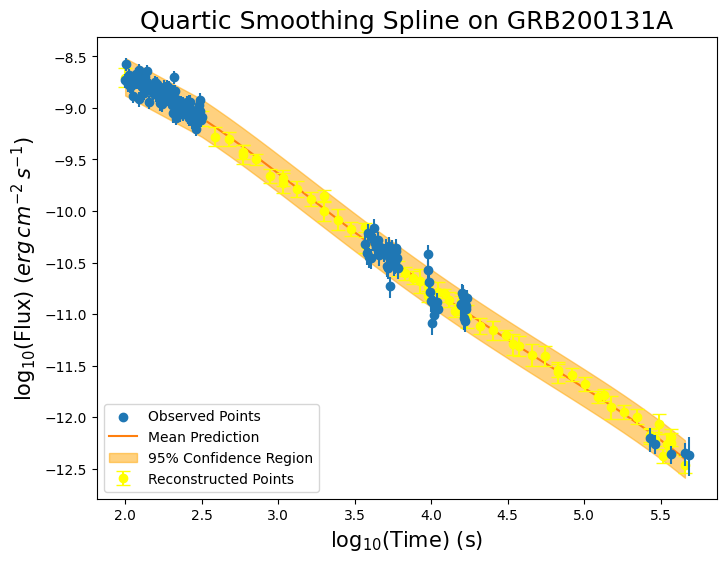

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200131A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 8.4227e-03  |  Val MSE (log‐flux): 9.3497e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 8.9962e-03  |  Val MSE (log‐flux): 7.1784e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 8.3223e-03  |  Val MSE (log‐flux): 1.0143e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.1680e-03  |  Val MSE (log‐flux): 6.5344e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.8265e-03  |  Val MSE (log‐flux): 1.2371e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.5472e-03
Overall Mean Val   MSE: 9.1153e-03

----- TRAINING FOR GRB200215A -----



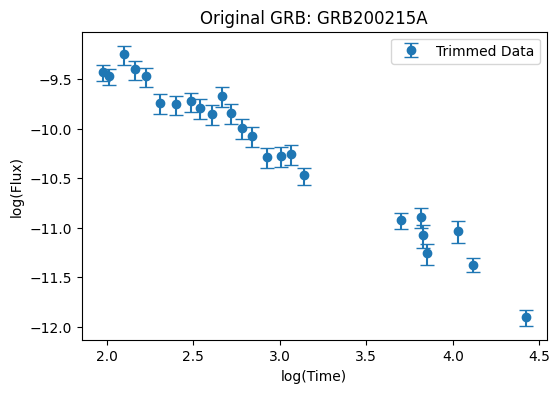


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



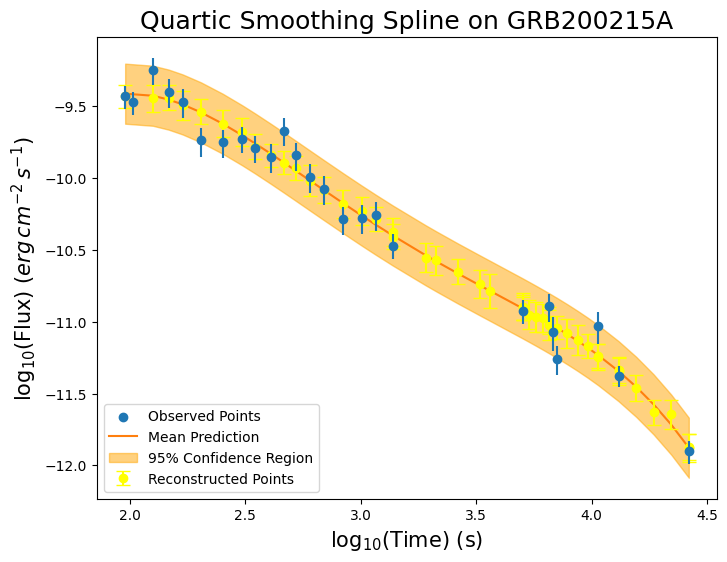

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200215A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.3065e-02  |  Val MSE (log‐flux): 5.8142e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 9.1283e-03  |  Val MSE (log‐flux): 2.5191e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.1645e-02  |  Val MSE (log‐flux): 1.5575e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.6798e-03  |  Val MSE (log‐flux): 5.4712e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.4412e-03  |  Val MSE (log‐flux): 1.9767e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.0592e-02
Overall Mean Val   MSE: 2.4212e-02

----- TRAINING FOR GRB200219A -----



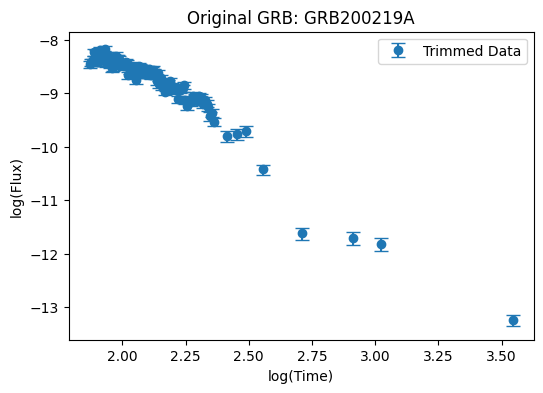


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



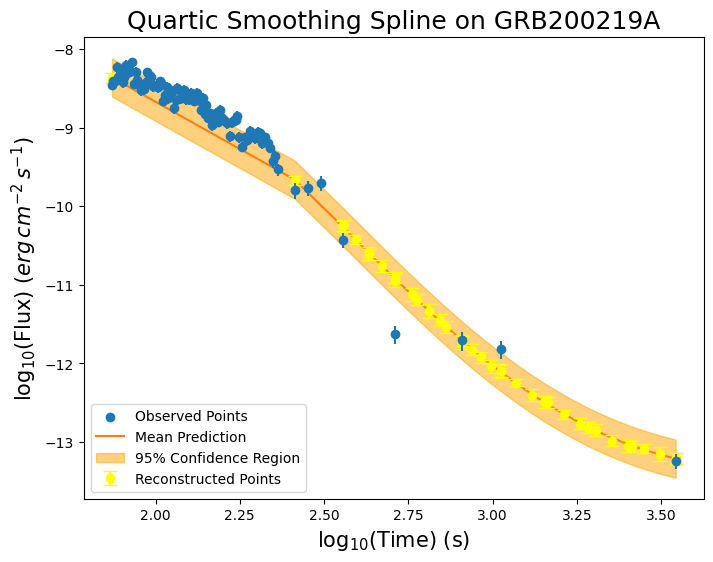

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200219A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 8.8061e-03  |  Val MSE (log‐flux): 4.8373e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.7521e-02  |  Val MSE (log‐flux): 7.4747e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.6769e-02  |  Val MSE (log‐flux): 1.0487e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.2789e-03  |  Val MSE (log‐flux): 7.1327e+01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.5130e-02  |  Val MSE (log‐flux): 1.8592e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.3501e-02
Overall Mean Val   MSE: 1.4282e+01

----- TRAINING FOR GRB200227A -----



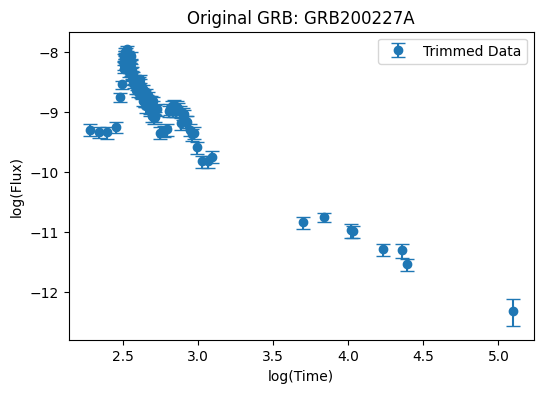


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



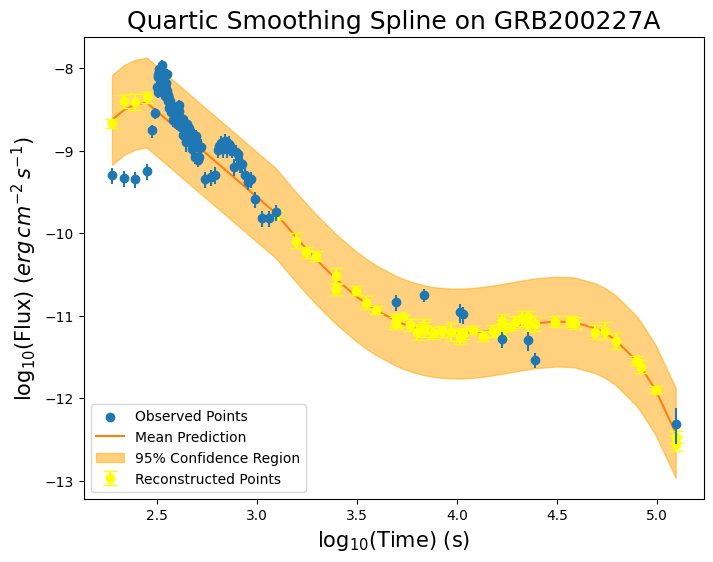

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200227A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 7.0840e-02  |  Val MSE (log‐flux): 1.0571e-01
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 7.8266e-02  |  Val MSE (log‐flux): 8.1520e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 7.5901e-02  |  Val MSE (log‐flux): 8.4295e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 8.8459e-02  |  Val MSE (log‐flux): 3.4518e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 5.8356e-02  |  Val MSE (log‐flux): 4.7319e+00

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 7.4364e-02
Overall Mean Val   MSE: 1.0076e+00

----- TRAINING FOR GRB200303A -----



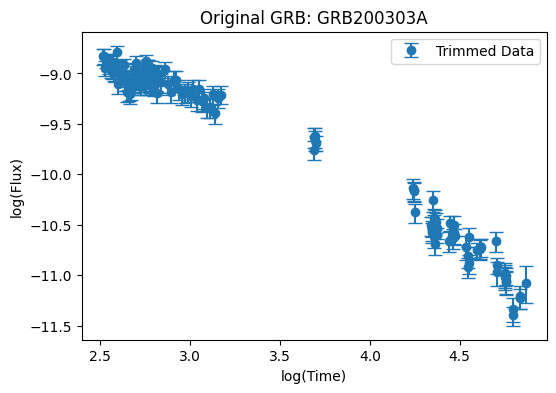


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



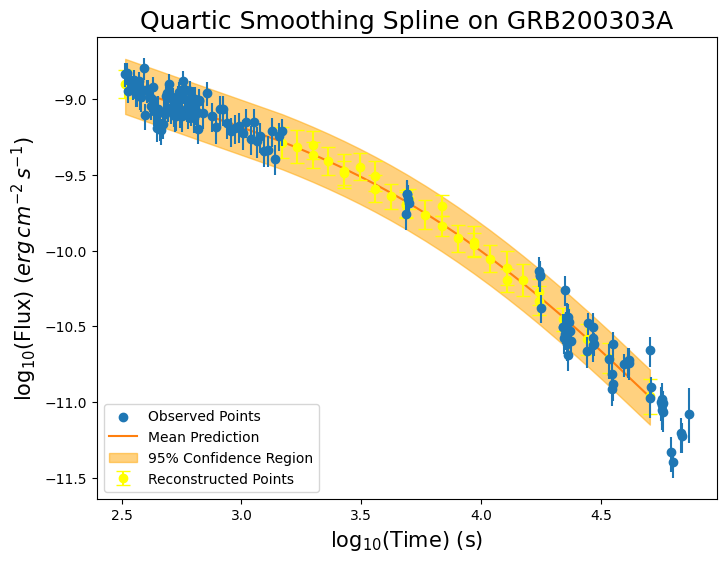

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200303A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 9.1723e-03  |  Val MSE (log‐flux): 6.6645e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 7.4818e-03  |  Val MSE (log‐flux): 1.3329e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 8.3039e-03  |  Val MSE (log‐flux): 1.0441e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.2255e-03  |  Val MSE (log‐flux): 6.6492e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 8.4859e-03  |  Val MSE (log‐flux): 1.0008e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.5339e-03
Overall Mean Val   MSE: 9.4181e-03

----- TRAINING FOR GRB200306A -----



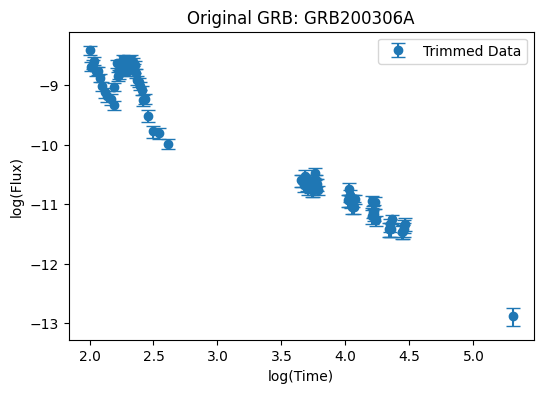


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



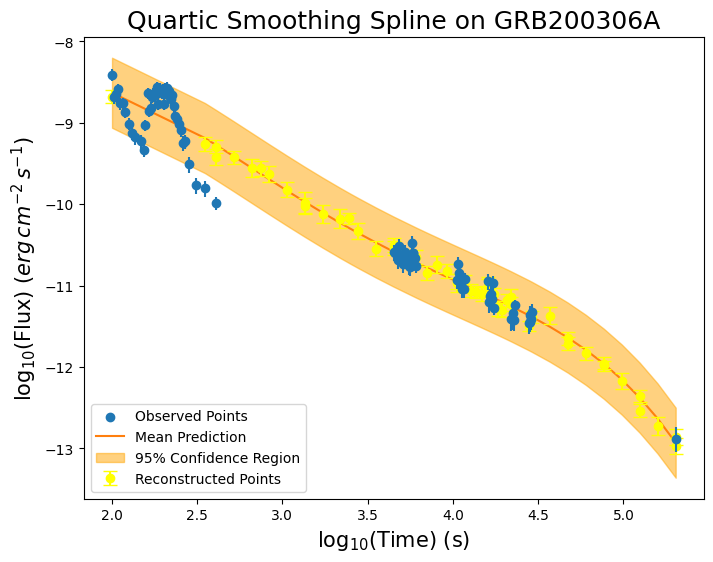

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200306A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 4.6825e-02  |  Val MSE (log‐flux): 5.4534e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 4.1992e-02  |  Val MSE (log‐flux): 7.2904e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 4.9704e-02  |  Val MSE (log‐flux): 4.6371e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 4.3778e-02  |  Val MSE (log‐flux): 1.2943e+00
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 5.3582e-02  |  Val MSE (log‐flux): 2.8580e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 4.7176e-02
Overall Mean Val   MSE: 2.9935e-01

----- TRAINING FOR GRB200324A -----



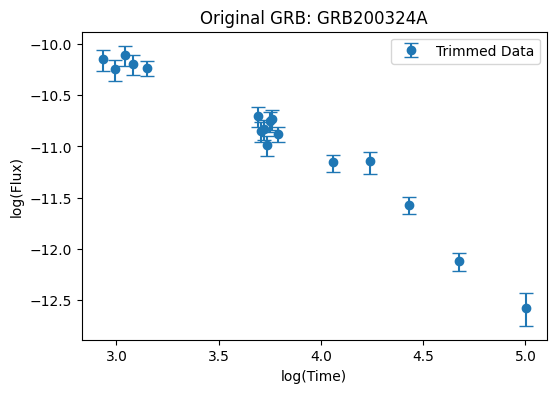


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



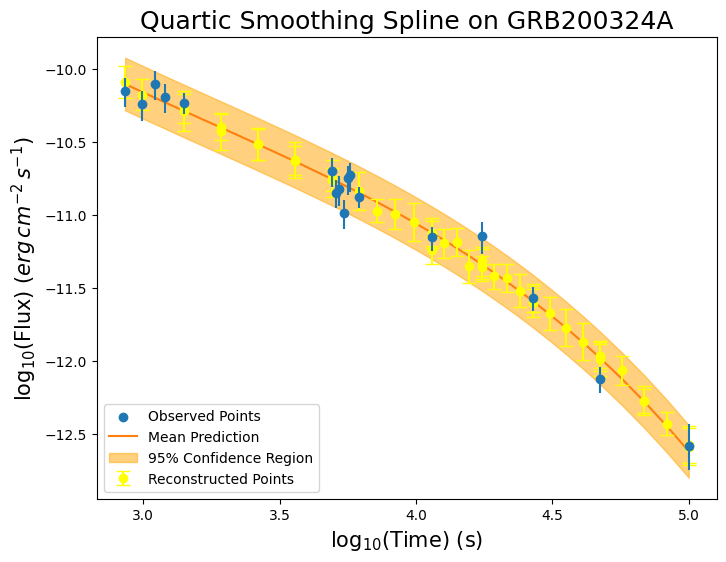

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200324A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 5.6492e-03  |  Val MSE (log‐flux): 4.7834e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 2.9583e-03  |  Val MSE (log‐flux): 4.2177e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 5.3409e-03  |  Val MSE (log‐flux): 6.3859e-01
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.1699e-03  |  Val MSE (log‐flux): 6.3059e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.4456e-03  |  Val MSE (log‐flux): 4.8408e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 6.5128e-03
Overall Mean Val   MSE: 1.4795e-01

----- TRAINING FOR GRB200409A -----



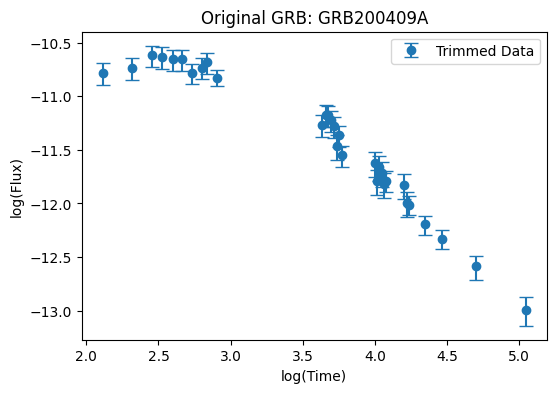


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



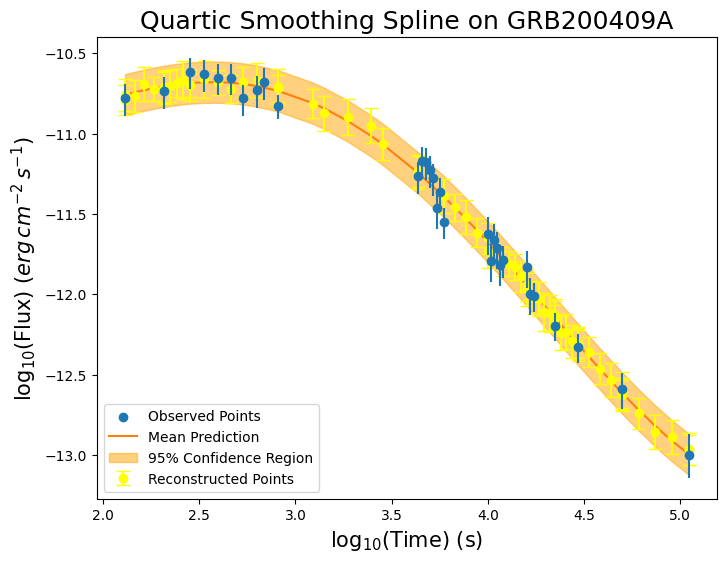

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200409A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 2.9822e-03  |  Val MSE (log‐flux): 1.1032e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 3.9911e-03  |  Val MSE (log‐flux): 7.3829e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 4.1244e-03  |  Val MSE (log‐flux): 5.6097e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 4.8652e-03  |  Val MSE (log‐flux): 4.6823e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 4.3449e-03  |  Val MSE (log‐flux): 4.6456e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 4.0616e-03
Overall Mean Val   MSE: 6.6706e-03

----- TRAINING FOR GRB200410A -----



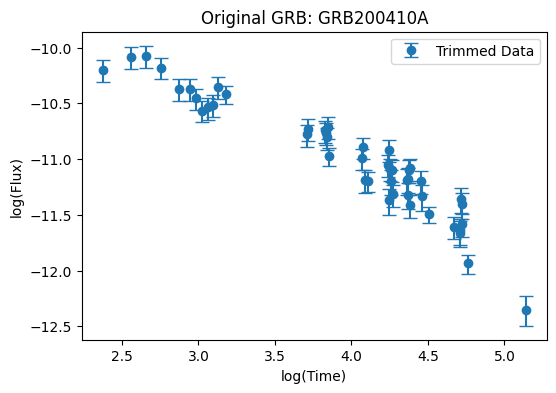


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



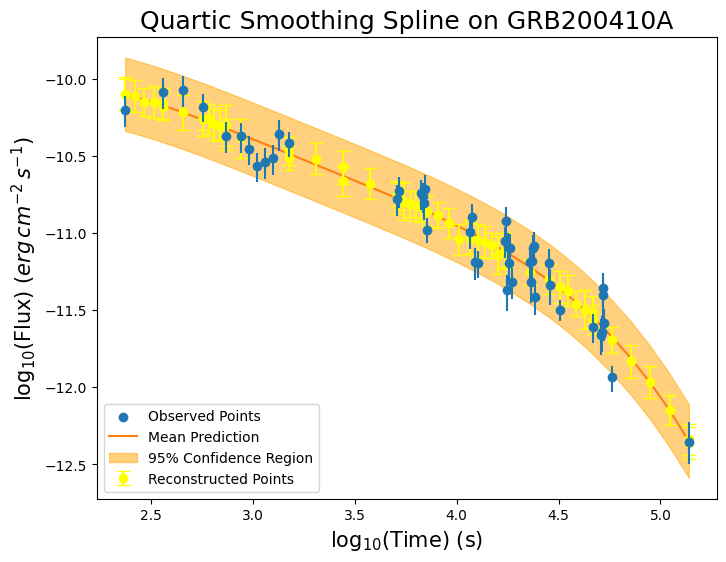

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200410A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.3931e-02  |  Val MSE (log‐flux): 1.8080e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.6026e-02  |  Val MSE (log‐flux): 1.1332e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.3743e-02  |  Val MSE (log‐flux): 3.1846e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.4172e-02  |  Val MSE (log‐flux): 2.0069e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.3246e-02  |  Val MSE (log‐flux): 2.6093e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.4224e-02
Overall Mean Val   MSE: 2.1484e-02

----- TRAINING FOR GRB200512A -----



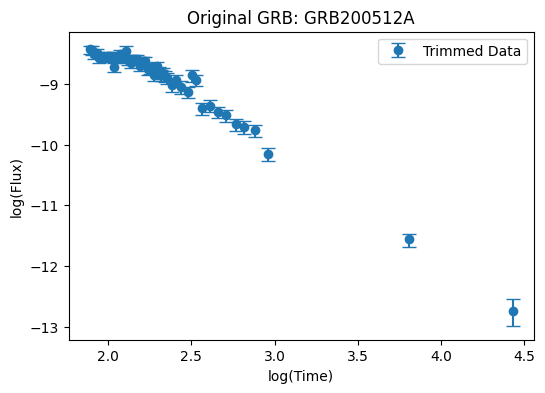


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



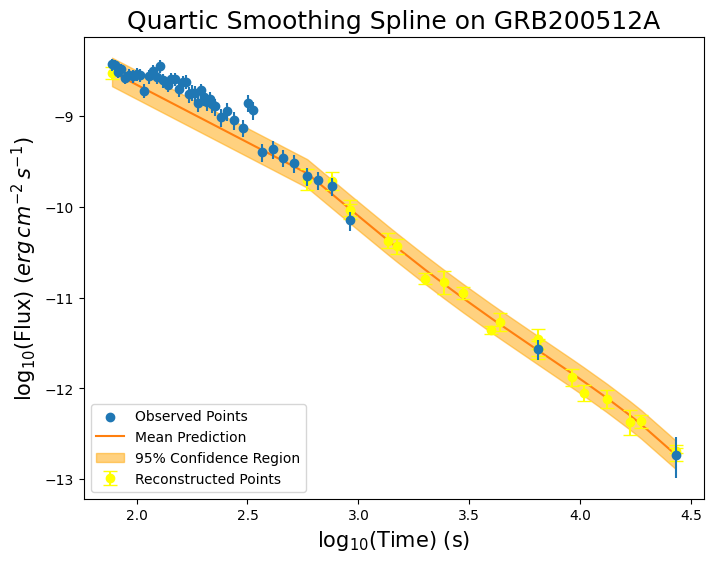

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200512A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 5.6816e-03  |  Val MSE (log‐flux): 9.9272e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 5.9109e-03  |  Val MSE (log‐flux): 9.0652e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 6.9851e-03  |  Val MSE (log‐flux): 4.7372e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 5.0476e-03  |  Val MSE (log‐flux): 1.2234e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.3491e-03  |  Val MSE (log‐flux): 1.0489e+00

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 6.1949e-03
Overall Mean Val   MSE: 2.2551e-01

----- TRAINING FOR GRB200519A -----



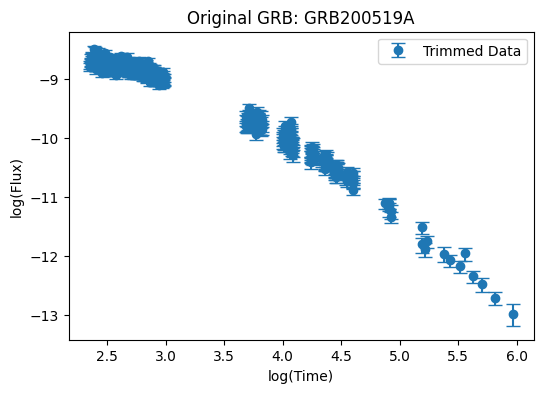


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



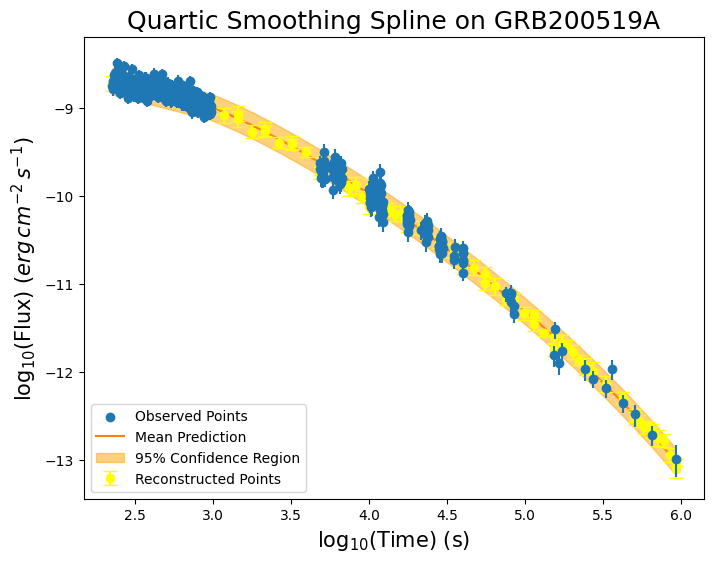

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200519A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 5.5116e-03  |  Val MSE (log‐flux): 7.0588e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 5.5629e-03  |  Val MSE (log‐flux): 6.7751e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 6.0297e-03  |  Val MSE (log‐flux): 4.9237e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 5.9764e-03  |  Val MSE (log‐flux): 5.2360e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 5.8217e-03  |  Val MSE (log‐flux): 5.8994e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 5.7804e-03
Overall Mean Val   MSE: 5.9786e-03

----- TRAINING FOR GRB200528A -----



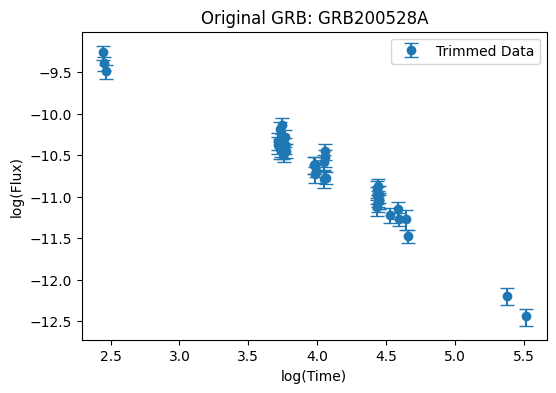


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



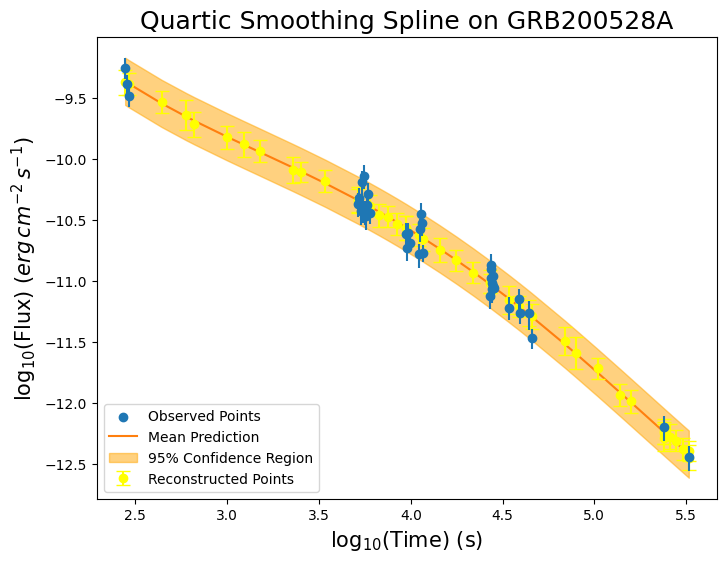

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200528A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 8.8521e-03  |  Val MSE (log‐flux): 1.3666e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 8.5018e-03  |  Val MSE (log‐flux): 1.5477e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.8958e-03  |  Val MSE (log‐flux): 1.4169e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0926e-02  |  Val MSE (log‐flux): 6.7420e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.1169e-03  |  Val MSE (log‐flux): 1.6061e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 9.4586e-03
Overall Mean Val   MSE: 1.3223e-02

----- TRAINING FOR GRB200711A -----



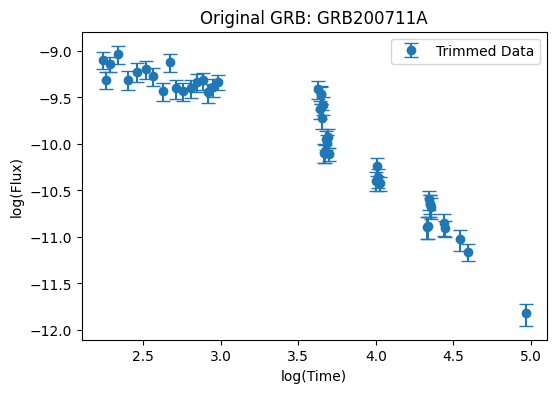


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



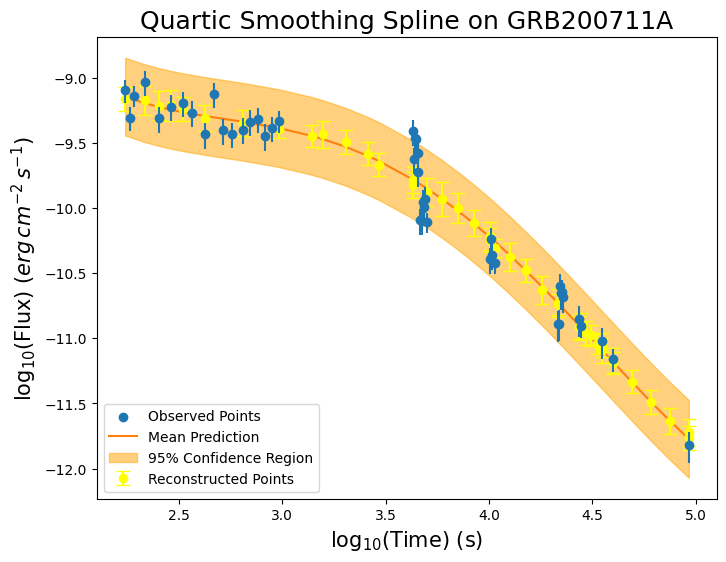

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200711A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 2.4337e-02  |  Val MSE (log‐flux): 2.0884e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 2.4123e-02  |  Val MSE (log‐flux): 2.0894e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 2.3447e-02  |  Val MSE (log‐flux): 2.6559e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 2.0632e-02  |  Val MSE (log‐flux): 3.6636e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.9280e-02  |  Val MSE (log‐flux): 7.0186e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 2.2364e-02
Overall Mean Val   MSE: 3.5032e-02

----- TRAINING FOR GRB200713A -----



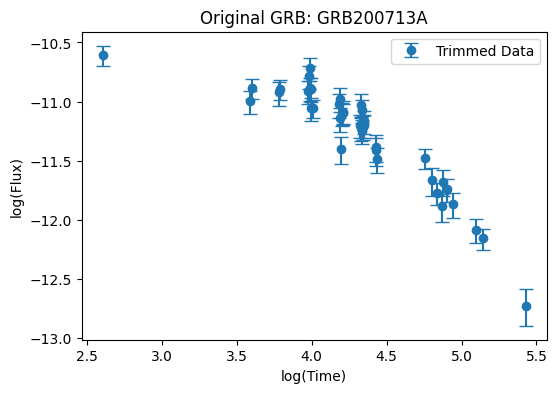


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



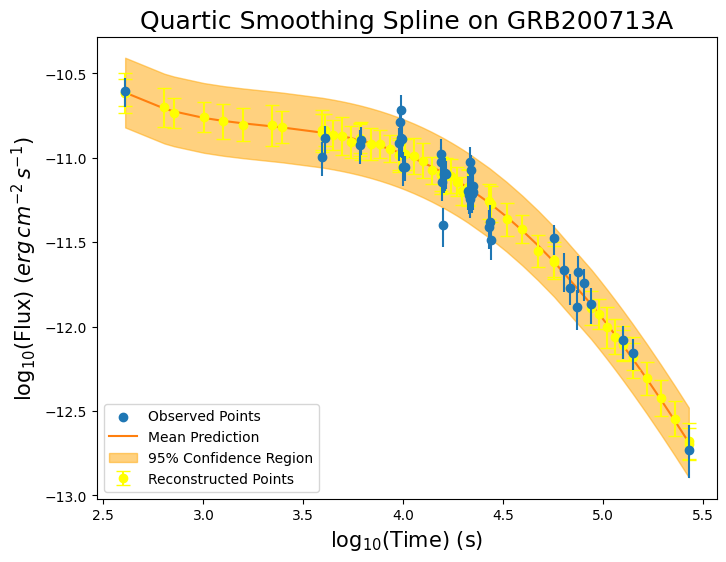

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200713A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 9.7247e-03  |  Val MSE (log‐flux): 1.8498e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.0894e-02  |  Val MSE (log‐flux): 2.6368e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.7478e-03  |  Val MSE (log‐flux): 4.8368e+00
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.1307e-02  |  Val MSE (log‐flux): 1.3052e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.0888e-02  |  Val MSE (log‐flux): 1.2432e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.0512e-02
Overall Mean Val   MSE: 9.8143e-01

----- TRAINING FOR GRB200716C -----



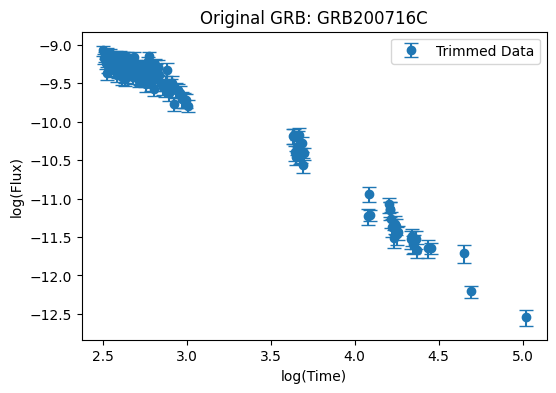


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



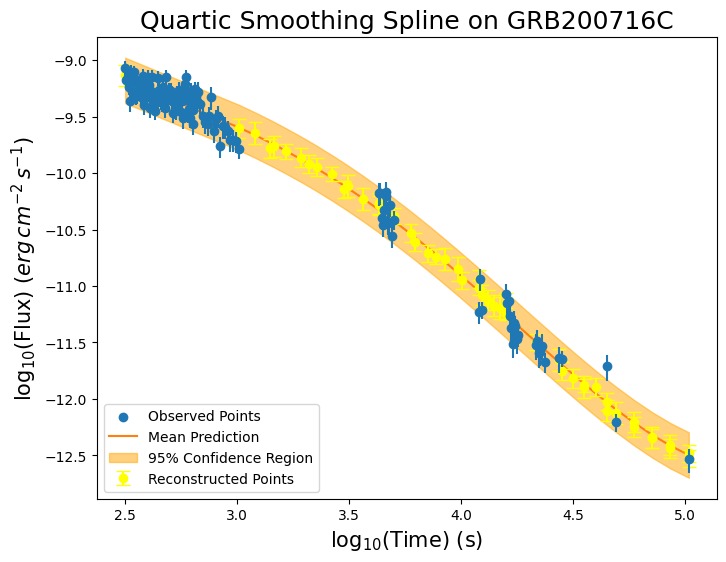

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200716C.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.0070e-02  |  Val MSE (log‐flux): 1.3067e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.0754e-02  |  Val MSE (log‐flux): 1.0103e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.1065e-02  |  Val MSE (log‐flux): 8.4872e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0156e-02  |  Val MSE (log‐flux): 1.2341e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.7515e-03  |  Val MSE (log‐flux): 1.6200e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.0359e-02
Overall Mean Val   MSE: 1.2040e-02

----- TRAINING FOR GRB200729A -----



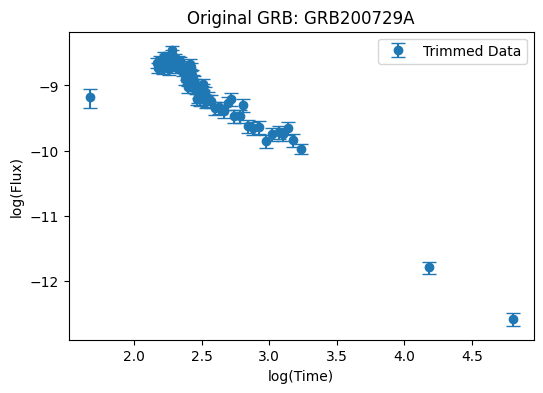


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



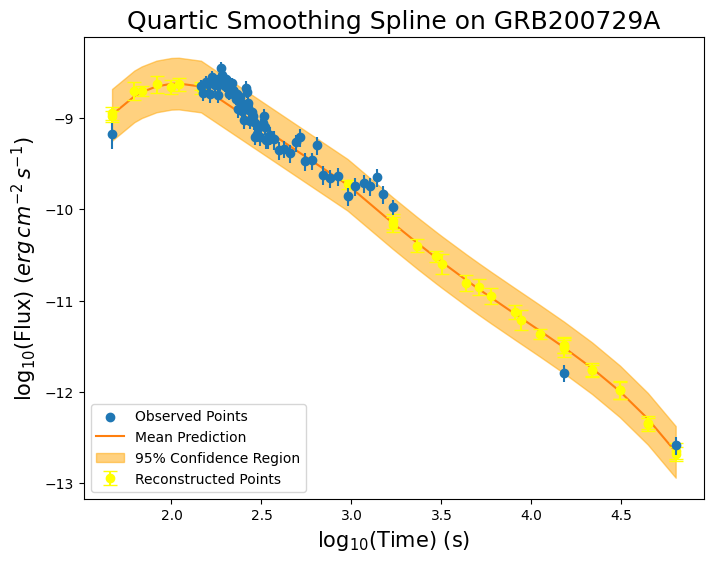

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200729A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.4588e-02  |  Val MSE (log‐flux): 4.8085e-01
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 2.1650e-02  |  Val MSE (log‐flux): 1.8354e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.1485e-02  |  Val MSE (log‐flux): 5.9817e+00
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.1456e-02  |  Val MSE (log‐flux): 4.2005e-01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.9433e-02  |  Val MSE (log‐flux): 2.7403e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.5722e-02
Overall Mean Val   MSE: 1.3857e+00

----- TRAINING FOR GRB200906A -----



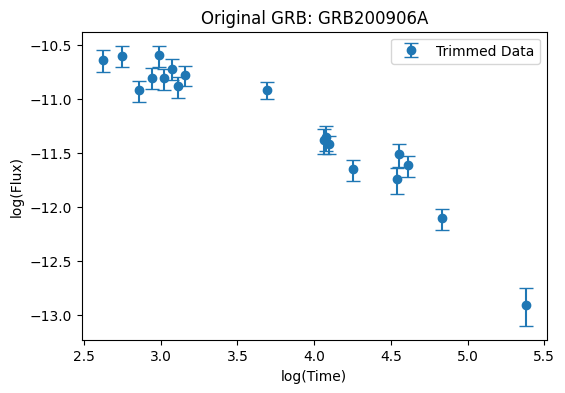


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



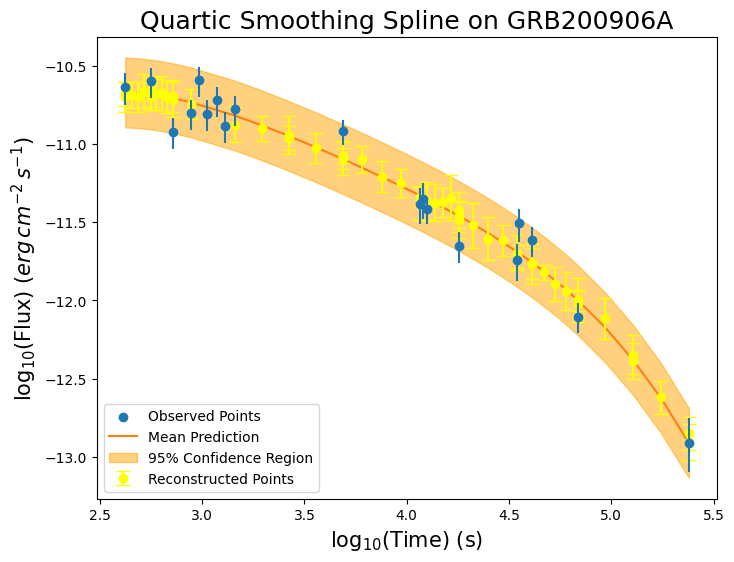

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200906A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.2383e-02  |  Val MSE (log‐flux): 1.4986e-01
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.1792e-02  |  Val MSE (log‐flux): 1.8913e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 5.8477e-03  |  Val MSE (log‐flux): 5.2785e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.3857e-02  |  Val MSE (log‐flux): 1.5269e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.4665e-02  |  Val MSE (log‐flux): 5.0839e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.1709e-02
Overall Mean Val   MSE: 4.8383e-02

----- TRAINING FOR GRB200925B -----



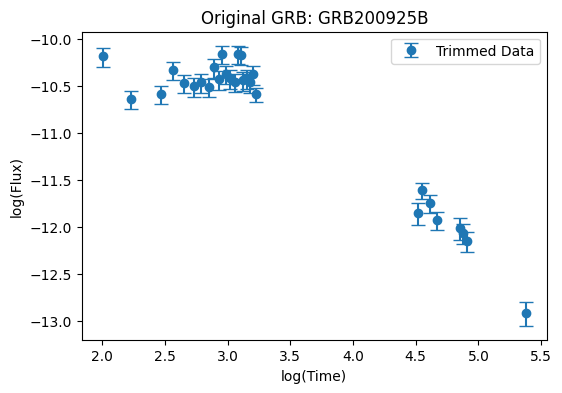


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



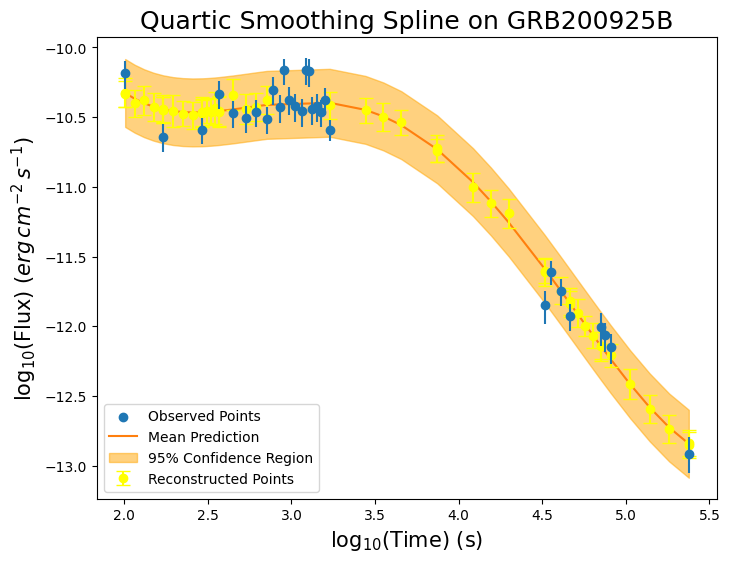

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB200925B.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.8274e-02  |  Val MSE (log‐flux): 5.4447e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 9.6279e-03  |  Val MSE (log‐flux): 1.0335e-01
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.3607e-02  |  Val MSE (log‐flux): 4.7708e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0205e-02  |  Val MSE (log‐flux): 3.8783e-01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.3184e-02  |  Val MSE (log‐flux): 2.9537e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.2979e-02
Overall Mean Val   MSE: 1.1477e-01

----- TRAINING FOR GRB201027A -----



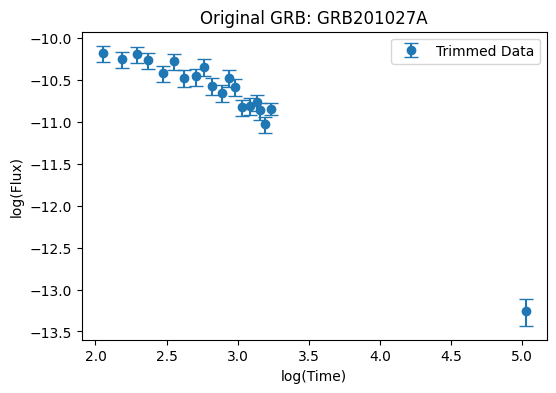


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



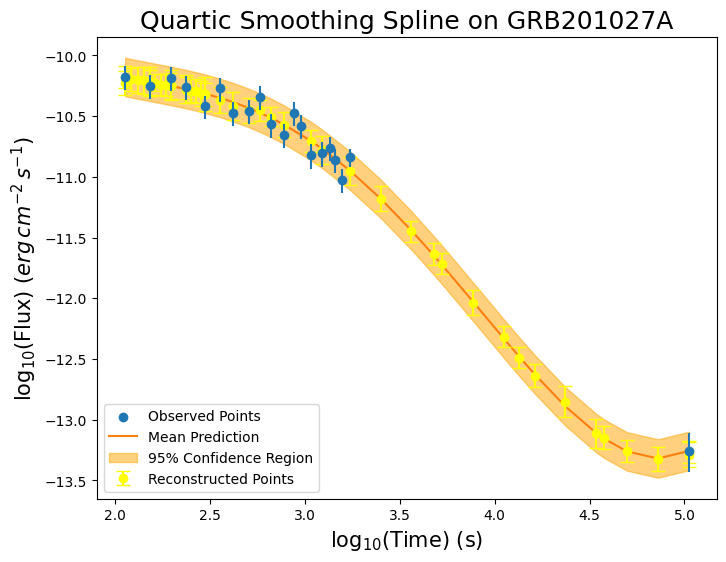

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB201027A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 6.4717e-03  |  Val MSE (log‐flux): 1.7214e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 4.1775e-03  |  Val MSE (log‐flux): 2.3104e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 5.5237e-03  |  Val MSE (log‐flux): 1.6353e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 6.5984e-03  |  Val MSE (log‐flux): 2.9366e+02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 6.7016e-03  |  Val MSE (log‐flux): 8.6357e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 5.8946e-03
Overall Mean Val   MSE: 5.8745e+01

----- TRAINING FOR GRB201128A -----



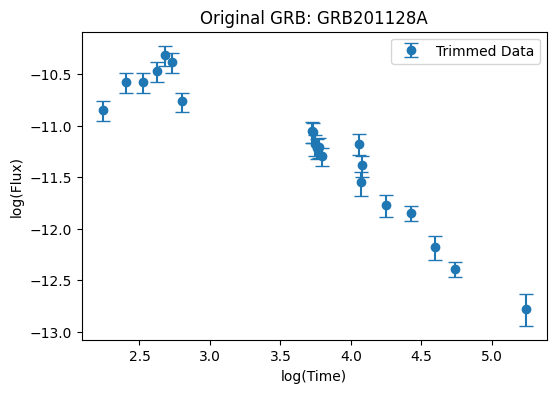


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



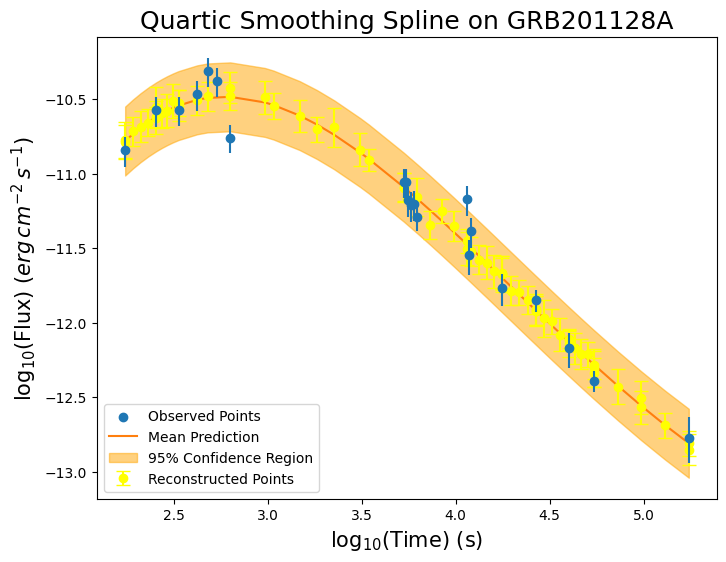

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB201128A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.5222e-02  |  Val MSE (log‐flux): 6.3640e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.5623e-02  |  Val MSE (log‐flux): 9.6021e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.1045e-02  |  Val MSE (log‐flux): 2.7664e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.1333e-02  |  Val MSE (log‐flux): 5.0630e-01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.5335e-03  |  Val MSE (log‐flux): 4.3446e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.2552e-02
Overall Mean Val   MSE: 1.3013e-01

----- TRAINING FOR GRB201209A -----



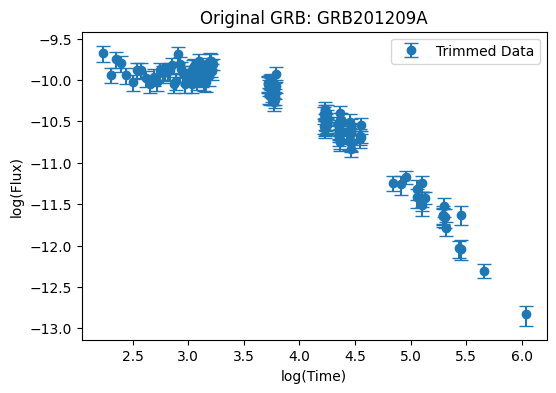


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



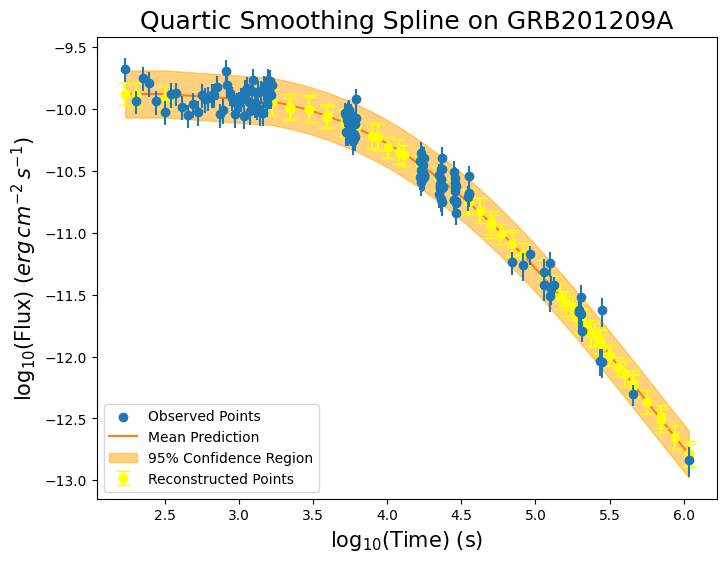

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB201209A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 9.8453e-03  |  Val MSE (log‐flux): 8.0907e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 9.1217e-03  |  Val MSE (log‐flux): 1.1215e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.3939e-03  |  Val MSE (log‐flux): 9.8037e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 9.0464e-03  |  Val MSE (log‐flux): 1.1230e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.4156e-03  |  Val MSE (log‐flux): 1.1970e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 9.3646e-03
Overall Mean Val   MSE: 1.0462e-02

----- TRAINING FOR GRB201223A -----



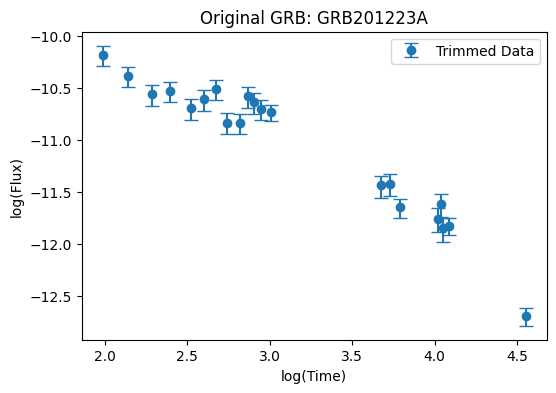


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



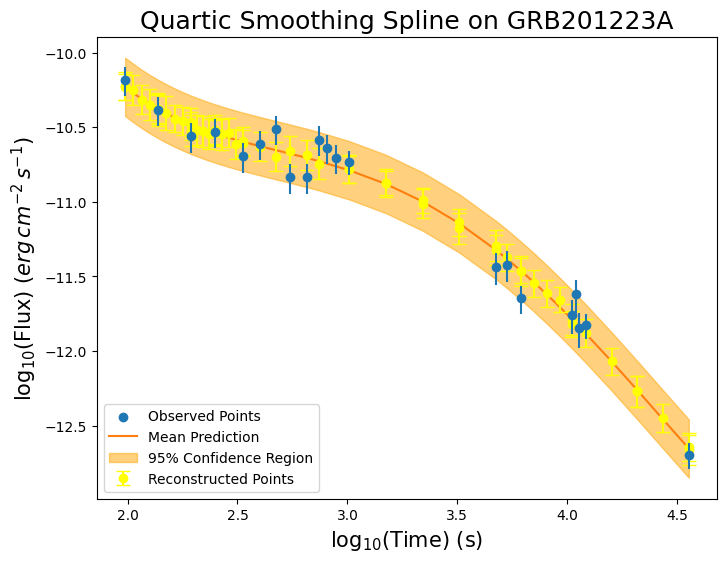

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB201223A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 6.0321e-03  |  Val MSE (log‐flux): 7.9889e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.2032e-02  |  Val MSE (log‐flux): 1.4977e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.7302e-03  |  Val MSE (log‐flux): 1.1696e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 5.8772e-03  |  Val MSE (log‐flux): 6.6005e-01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 9.7769e-03  |  Val MSE (log‐flux): 1.3052e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.6897e-03
Overall Mean Val   MSE: 1.5324e-01

----- TRAINING FOR GRB201229A -----



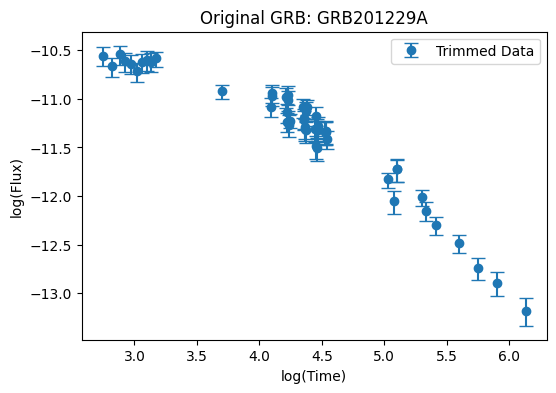


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



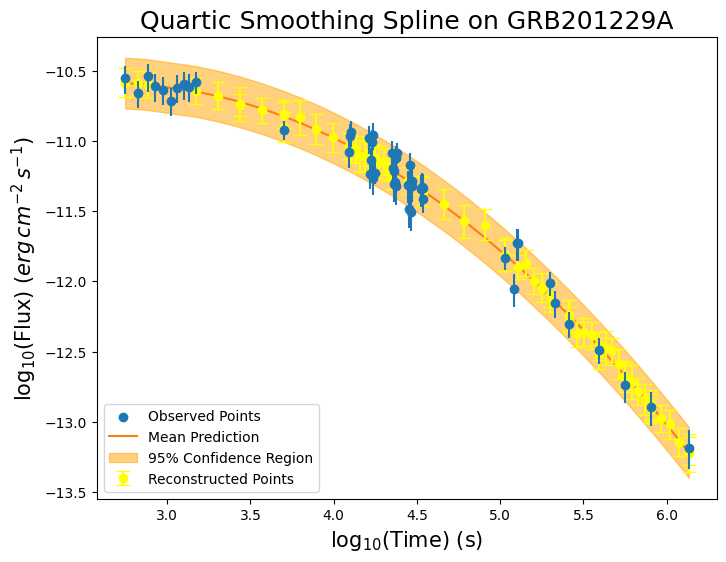

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB201229A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 7.7514e-03  |  Val MSE (log‐flux): 1.1340e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 8.3260e-03  |  Val MSE (log‐flux): 1.0217e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.4372e-03  |  Val MSE (log‐flux): 4.9856e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 8.6581e-03  |  Val MSE (log‐flux): 8.5093e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 7.5009e-03  |  Val MSE (log‐flux): 1.4123e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 8.3347e-03
Overall Mean Val   MSE: 9.8351e-03

----- TRAINING FOR GRB210104A -----



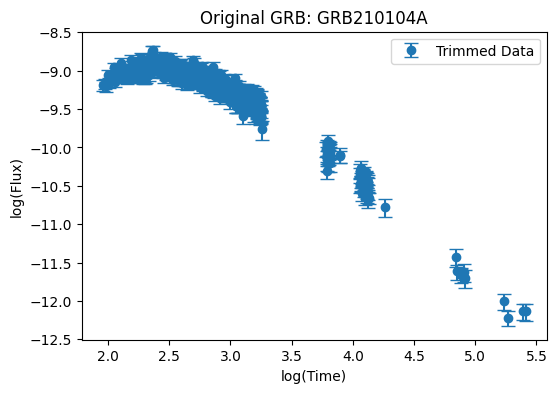


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



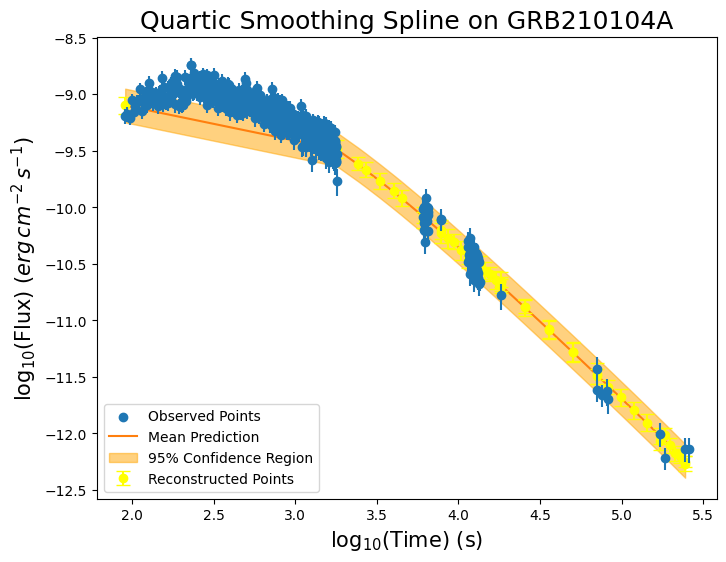

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB210104A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 5.7592e-03  |  Val MSE (log‐flux): 6.0134e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 5.6366e-03  |  Val MSE (log‐flux): 6.4928e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 5.8683e-03  |  Val MSE (log‐flux): 5.5822e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 5.8141e-03  |  Val MSE (log‐flux): 5.7941e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 5.8110e-03  |  Val MSE (log‐flux): 5.8184e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 5.7778e-03
Overall Mean Val   MSE: 5.9402e-03

----- TRAINING FOR GRB210104B -----



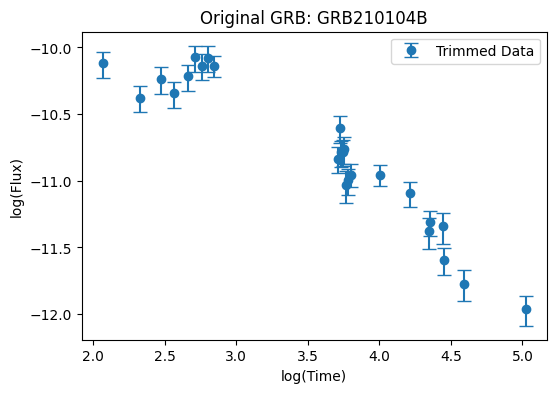


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



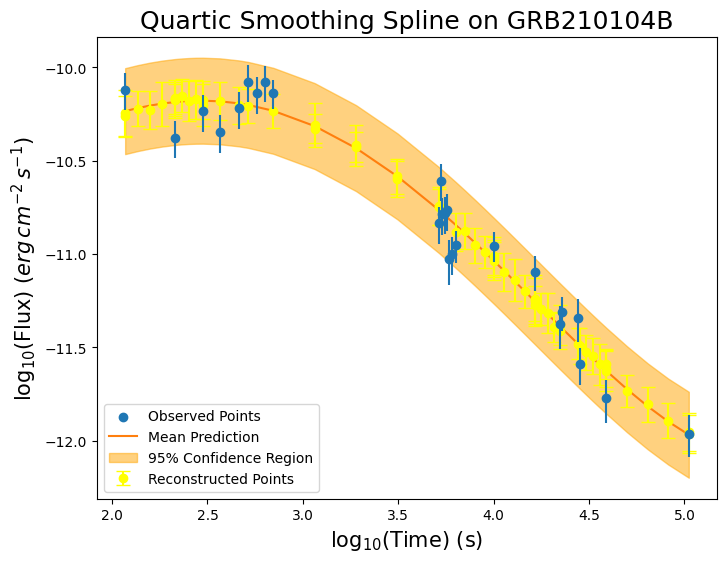

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB210104B.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.0258e-02  |  Val MSE (log‐flux): 1.4321e-01
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 1.3293e-02  |  Val MSE (log‐flux): 1.8409e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.3440e-02  |  Val MSE (log‐flux): 2.0425e-02
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0904e-02  |  Val MSE (log‐flux): 2.3204e-01
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.1797e-02  |  Val MSE (log‐flux): 2.4394e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.1939e-02
Overall Mean Val   MSE: 8.7696e-02

----- TRAINING FOR GRB210112A -----



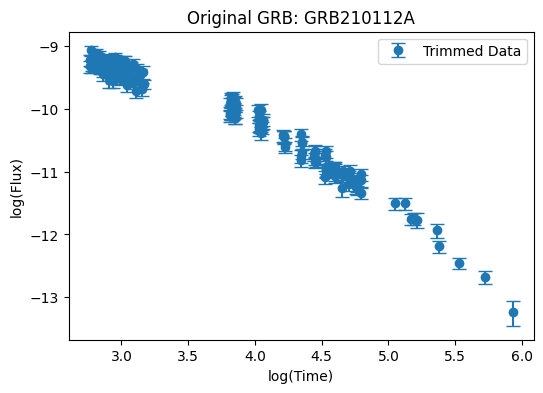


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



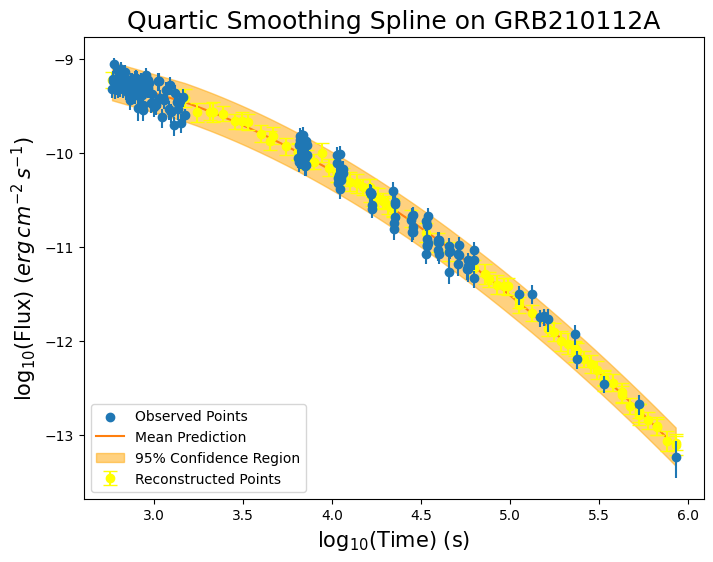

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB210112A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.0852e-02  |  Val MSE (log‐flux): 1.0550e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 9.8092e-03  |  Val MSE (log‐flux): 1.4728e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 1.1603e-02  |  Val MSE (log‐flux): 7.6487e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0827e-02  |  Val MSE (log‐flux): 1.1132e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 1.0294e-02  |  Val MSE (log‐flux): 1.6520e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 1.0677e-02
Overall Mean Val   MSE: 1.2116e-02

----- TRAINING FOR GRB210207B -----



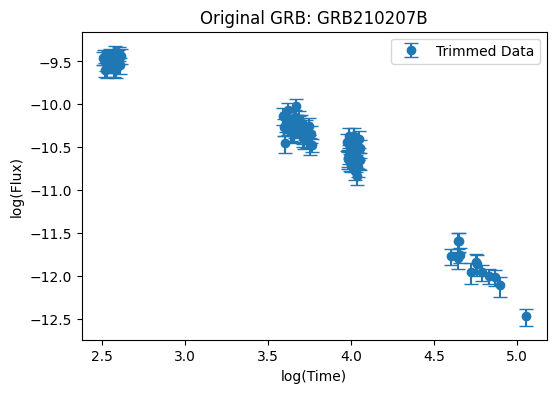


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



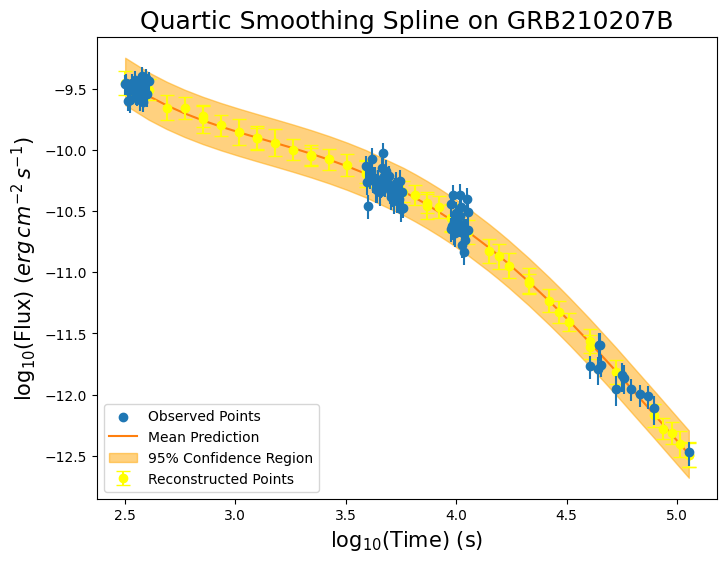

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB210207B.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 1.0192e-02  |  Val MSE (log‐flux): 8.5531e-03
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 9.3308e-03  |  Val MSE (log‐flux): 1.2563e-02
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 9.7629e-03  |  Val MSE (log‐flux): 9.9410e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 1.0180e-02  |  Val MSE (log‐flux): 8.5249e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 8.6278e-03  |  Val MSE (log‐flux): 1.5563e-02

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 9.6186e-03
Overall Mean Val   MSE: 1.1029e-02

----- TRAINING FOR GRB210217A -----



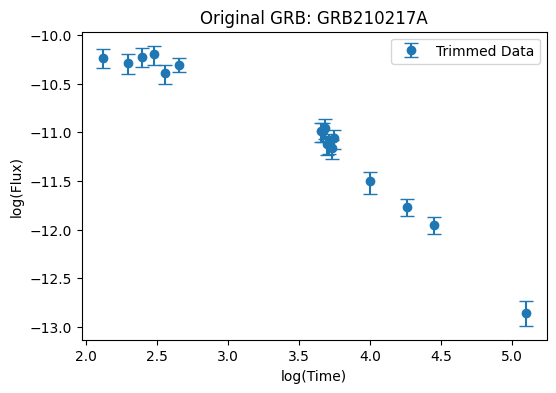


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



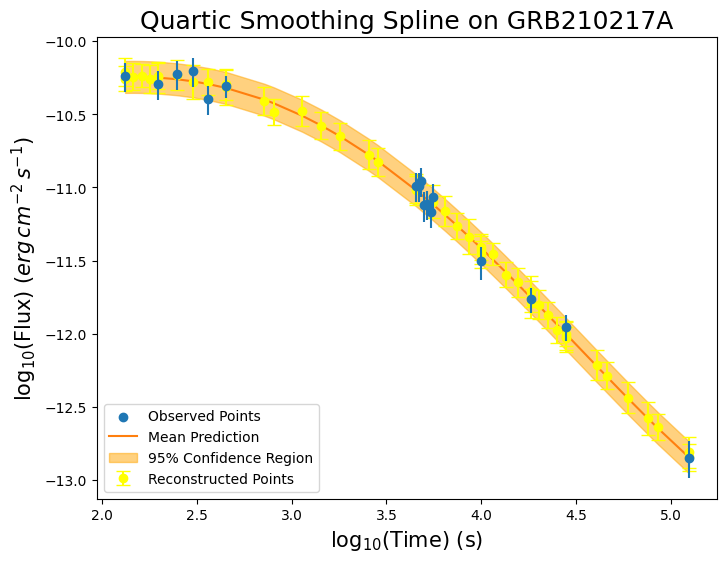

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB210217A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 3.0679e-03  |  Val MSE (log‐flux): 4.7508e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 2.1880e-03  |  Val MSE (log‐flux): 7.7338e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 2.5176e-03  |  Val MSE (log‐flux): 1.0497e+00
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 2.5579e-03  |  Val MSE (log‐flux): 7.2941e-03
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 2.9255e-03  |  Val MSE (log‐flux): 5.1206e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 2.6514e-03
Overall Mean Val   MSE: 2.2346e-01

----- TRAINING FOR GRB210226A -----



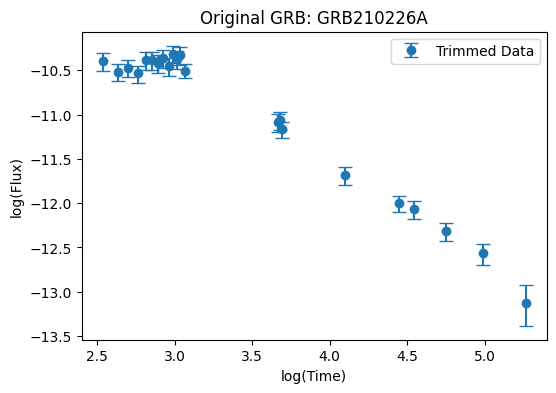


----- ORIGINAL GRB (WITH UPDATED ERROR BARS) PLOTTED ABOVE -----


----- TRAINING QUARTIC SMOOTHING SPLINE (SciPy) -----


----- RECONSTRUCTED GRB (Figure saved) -----



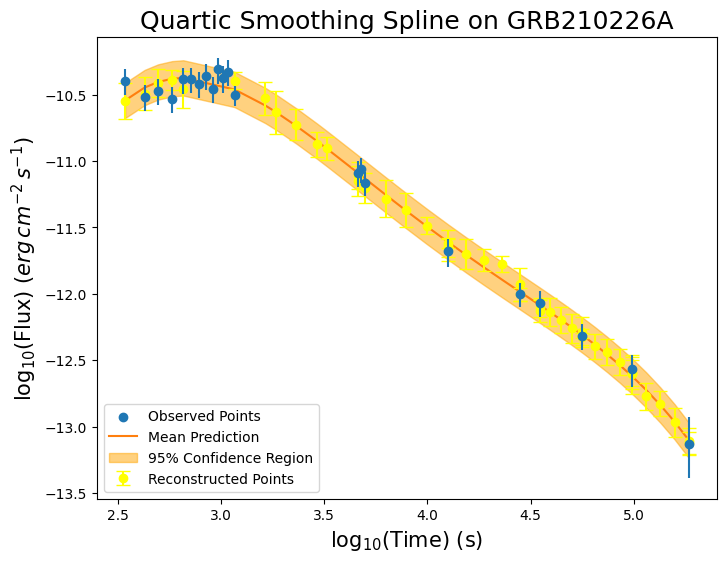

Saved combined CSV to: /content/drive/MyDrive/BQSP_test_1a/Saved_Outputs//CSV_data/GRB210226A.csv

----- 5‐FOLD VALIDATION BEGIN -----

--- Fold 1 / 5 ---
Fold 1 → Train MSE (log‐flux): 2.0701e-03  |  Val MSE (log‐flux): 4.7171e-02
--- Fold 2 / 5 ---
Fold 2 → Train MSE (log‐flux): 3.4303e-03  |  Val MSE (log‐flux): 9.3487e-03
--- Fold 3 / 5 ---
Fold 3 → Train MSE (log‐flux): 5.0918e-03  |  Val MSE (log‐flux): 3.4652e-03
--- Fold 4 / 5 ---
Fold 4 → Train MSE (log‐flux): 4.0502e-03  |  Val MSE (log‐flux): 2.8006e-02
--- Fold 5 / 5 ---
Fold 5 → Train MSE (log‐flux): 5.1721e-03  |  Val MSE (log‐flux): 2.4072e-03

----- 5‐FOLD VALIDATION COMPLETE -----

Overall Mean Train MSE: 3.9629e-03
Overall Mean Val   MSE: 1.8080e-02


In [ ]:
for grb_name in GRBs:
    run_model(grb_name)  # Process each GRB #GRB130211A,GRB160104A,GRB111117A,GRB230420A    error
